```python
file1 \_ |-----------------------------------|   -+-
file2 \_ |-----------------------------------|    |   training data
file3 \_ |-----------------------------------|    |        80%
file4 \_ |-----------------------------------|    |
                                                 -+-
file5 \_ |-----------------------------------|    |  validation data
file6 \_ |-----------------------------------|    |        20%
         |-----------------------------------|   -+-
```

In [18]:
import os
import glob

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# 解壓縮資料

In [2]:
def unzip_data(path):
    for folder, _, files in os.walk(path):
        for file in files:
            if file.endswith('zip'):
                file_path = os.path.join(folder, file)
                print(file_path)

                sotre_path = os.path.join(folder, file.rsplit('.')[0])
                # 開啟 ZIP 壓縮檔 
                with zipfile.ZipFile(file_path, 'r') as zf:
                    # 解壓縮所有檔案至 /my/folder 目錄
                    zf.extractall(path=sotre_path)

In [3]:
# unzip_data('./swing')

In [4]:
def convert_csv(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=',')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=',')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=',')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=',')
    device_df = pd.read_csv(os.path.join(path, 'meta', 'device.csv'), delimiter=',')
    time_df = pd.read_csv(os.path.join(path, 'meta', 'time.csv'), delimiter=',')
    
    acc_df.to_csv(os.path.join(path, 'Accelerometer.csv'), index=False, sep=';')
    gyo_df.to_csv(os.path.join(path, 'Gyroscope.csv'), index=False, sep=';')
    linacc_df.to_csv(os.path.join(path, 'Linear Accelerometer.csv'), index=False, sep=';')
    mag_df.to_csv(os.path.join(path, 'Magnetometer.csv'), index=False, sep=';')
    device_df.to_csv(os.path.join(path, 'meta', 'device.csv'), index=False, sep=';')
    time_df.to_csv(os.path.join(path, 'meta', 'time.csv'), index=False, sep=';')

In [5]:
# convert_csv('./pocket/202301101952/target')
# convert_csv('./pocket/202301101952/source')

# 讀檔

In [3]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path):
    time_df = pd.read_csv(path, delimiter=';', index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def load_original_data(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=';')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=';')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'))
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, gyo_df, linacc_df, mag_df], axis=1)
    total_df = rename_data(total_df)
    
    return total_df

In [4]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, seq_len=25):
    num_of_segs = int(np.floor(len(df) / seq_len))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * seq_len):int((i + 1) * seq_len)].to_numpy()
        segments.append(seg)
        
    return segments


def split_segments_overlap(df, seq_len=25, shift=15):
    
    segments = []
    for i in range(0, len(df) - seq_len, shift):
        seg = df.iloc[i:i + seq_len].to_numpy()
        segments.append(seg)
        
    return segments


def select_data(df):
    return df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'system_time']]


def preprocess_data(df, seq_len=25, shift=15, is_train_data=False):
    pre_df = select_data(df)
    
    if is_train_data:
        segs = split_segments_overlap(pre_df, seq_len, shift)
    else:
        segs = split_segments(pre_df, seq_len)
    
    return segs

In [69]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

#         print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num, file_index=None, is_train_data=False):
    prefix = 'train' if is_train_data else 'valid'
    pair_data = []
    folder_paths = glob.glob(f'*{os.path.normpath(root_folder)}/*')

    if file_index is not None:
        folder_paths = folder_paths[file_index[0]:file_index[1]]

    for i, folder_path in enumerate(folder_paths):
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(f'{prefix} {i + 1: >3}: {folder_path}')
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path)
        target_df = load_original_data(target_path)
        
#         print(source_df.system_time[0], target_df.system_time[0])
        
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        source_df, target_df = align_data(source_df, target_df)
        
#         print(source_df.system_time[0], target_df.system_time[0])
#         print(source_df.system_time[len(source_df) - 1], target_df.system_time[len(target_df) - 1])
#         print(len(source_df), len(target_df))
        
#         plt.figure(figsize=(30, 5))
#         plt.plot(np.arange(len(source_df)), source_df.acc_x)
#         plt.plot(np.arange(len(target_df)), target_df.acc_y)
#         plt.show()
        
        source_segs = preprocess_data(source_df, seq_len, shift, is_train_data)
        target_segs = preprocess_data(target_df, seq_len, shift, is_train_data)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
        
    return pair_data

In [6]:
datapoint_per_second = 20
duration = 2
seq_len = 25
shift = 15  # the shfit of the data
classes = {0: 'target', 1: 'front_pocket', 2: 'pocket', 3: 'swing'}

In [7]:
source_device_version = device_version('./front_pocket/202302071523/source/meta/device.csv')
target_device_version = device_version('./front_pocket/202302071523/target/meta/device.csv')
print(f"source device version: {source_device_version}")  # source version: 15.4
print(f"target device version: {target_device_version}")  # target version: 16.3

source device version: 15.4
target device version: 16.3


In [70]:
train_front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1, file_index=[0, 8], is_train_data=True)
valid_front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1, file_index=[8, 10], is_train_data=False)

train_pocket_pair_data = load_pair_data('./pocket', class_num=2, file_index=[0, 8], is_train_data=True)
valid_pocket_pair_data = load_pair_data('./pocket', class_num=2, file_index=[8, 10], is_train_data=False)

train_swing_pair_data = load_pair_data('./swing', class_num=3, file_index=[0, 8], is_train_data=True)
valid_swing_pair_data = load_pair_data('./swing', class_num=3, file_index=[8, 10], is_train_data=False)

train   1: front_pocket/202302071628
train   2: front_pocket/202302071652
train   3: front_pocket/202302071523
train   4: front_pocket/202302071531
train   5: front_pocket/202302071715
train   6: front_pocket/202302071641
train   7: front_pocket/202302071541
train   8: front_pocket/202302071619
valid   1: front_pocket/202302071704
valid   2: front_pocket/202302071724
train   1: pocket/202302132108
train   2: pocket/202302131750
train   3: pocket/202302131601
train   4: pocket/202302071606
train   5: pocket/202302132053
train   6: pocket/202302122132
train   7: pocket/202302132116
train   8: pocket/202302131643
valid   1: pocket/202301101952
valid   2: pocket/202302132101
train   1: swing/202302142339
train   2: swing/202302132131
train   3: swing/202302142117
train   4: swing/202302132124
train   5: swing/202302121947
train   6: swing/202302121857
train   7: swing/202302142128
train   8: swing/202302121920
valid   1: swing/202302121909
valid   2: swing/202302142331


In [12]:
print(len(train_front_pocket_pair_data), len(train_pocket_pair_data), len(train_swing_pair_data))

2697 2640 2559


In [13]:
train_front_pocket_pair_data[0][0][0], train_front_pocket_pair_data[0][2][0]

(array([-1.14233120e+00, -1.94808760e-01,  1.75476462e+00, -2.18800381e-01,
        -2.56263137e-01, -2.19771296e-01,  1.68020420e+01, -1.84701080e+01,
         3.61005859e+01,  1.67575811e+09]),
 array([-4.94412891e-01,  3.02118031e-01, -7.15015656e-01, -5.08982837e-02,
        -8.86559859e-02,  1.07779831e-01, -3.95247726e+01, -8.10098648e+00,
        -1.99851685e+01,  1.67575811e+09]))

# 建立dataloader

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [15]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [16]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(FirstDerivativeLoss, self).__init__()

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), -1))
        target_o = torch.reshape(target, (len(target), -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]
        deriv = d_source - d_target

        # calculate the loss as the mean squared error of the derivative
        loss = torch.mean(torch.pow(deriv, 2))

        return loss

In [17]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag):
    imu_loss = mse_loss(z_imu, target_imu)
    mag_loss = mse_loss(predict_mag, target_mag)
    d1_loss = div_loss(predict_mag, target_mag)

    total_loss = imu_loss + mag_loss #+ d1_loss
    return total_loss, imu_loss, mag_loss, d1_loss

# def discriminator_loss(d_real, d_fake):
#     real_loss = bce_loss(d_real, torch.ones_like(d_real))
#     fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

#     return real_loss + fake_loss

In [18]:
train_data = train_front_pocket_pair_data + train_pocket_pair_data + train_swing_pair_data
valid_data = valid_front_pocket_pair_data + valid_pocket_pair_data + valid_swing_pair_data

# train
train_source_data = np.array([d[0] for d in train_data])
train_source_label = np.array([d[1] for d in train_data])
train_target_data = np.array([d[2] for d in train_data])
train_target_label = np.array([d[3] for d in train_data])
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                )
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# valid
valid_source_data = np.array([d[0] for d in valid_data])
valid_source_label = np.array([d[1] for d in valid_data])
valid_target_data = np.array([d[2] for d in valid_data])
valid_target_label = np.array([d[3] for d in valid_data])
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                )
valid_loader = DataLoader(valid_dataset, batch_size=512)

In [19]:
batch = next(iter(train_loader))

In [20]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]

    return mask

In [21]:
class Classifier(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(Classifier, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.nn = nn.Sequential(
            nn.Linear(6, 16),
            nn.SELU(),
            nn.Linear(16, 16),
            nn.SELU(),
        )
        
        # 16 * (seq_len-8)
        self.rnn = nn.RNN(input_size=16, hidden_size=32, num_layers=2, batch_first=True, bidirectional=True)
        
        self.last = nn.Sequential(
            nn.Linear(64 * self.seq_len, 16),
            nn.Tanh(),
            nn.Linear(16, num_of_classes),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):  # input: (bs, seq_len, 6)
        h = self.nn(x)

        hz, _ = self.rnn(h)
        
        hz = hz.reshape(len(x), -1)
        out = self.last(hz)

        out = torch.reshape(out, (len(x), self.num_of_classes))
        
        return out, hz
    
    def predict_label(self, x):
        predict_probability, _ = self(x)
        predict_probability = predict_probability.reshape((-1, self.num_of_classes))
        _, predict_classes = torch.max(predict_probability, 1)
        one_hot = F.one_hot(predict_classes, num_classes=self.num_of_classes).to(device).float()
        class_result = one_hot.reshape(-1, self.num_of_classes)
        
        return class_result


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.imu_layer = nn.Sequential(
            nn.Linear(6, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 16),
            nn.LeakyReLU(),
        )
        self.mag_layer = nn.Sequential(
            nn.Linear(3, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 16),
            nn.LeakyReLU(),
        )
        self.pos_encoder = PositionalEncoding(16, 0.1)
        self.mag_pos_encoder = PositionalEncoding(16, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=16, nhead=8, dropout=0.2, batch_first=True), num_layers=4)
        self.nn = nn.Sequential(
            nn.Linear(16, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 6),
        )
        
        self.task_controller_net = nn.Sequential(
            nn.Linear(16 * self.seq_len + self.num_of_classes, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.LeakyReLU(), 
            nn.Linear(64, 9),
        )
        
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=16, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
        
#         self.mag_last = nn.Sequential(
#             nn.Linear(64, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 3),
#         )

        self.mag_last = nn.Sequential(
            nn.Linear(16, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 3),
        )
        
    def forward(self, source_imu, source_mag, class_result):
        
        ### step 1
        h_imu = self.imu_layer(source_imu)
        h_imu = self.pos_encoder(h_imu)

        
        h_mag = source_mag
#         h_mag = h_mag.reshape((len(source_mag), self.chunk_size, -1))
#         h_mag = self.mag_pos_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = self.nn(z)

        z = z.reshape(len(z), -1)
        z_class = torch.concat([z, class_result], dim=-1)
        task_latent = self.task_controller_net(z_class)
        
        ### step 3
#         pred_latent = self.decoder(h_mag, z)
#         pred_mag = pred_latent.reshape((len(source_mag), self.chunk_size, self.seq_len, -1))
        
#         pred_mag = pred_mag + task_latent[:, :, None, :]
#         pred_mag = self.mag_last(pred_mag)

        task_matrix = task_latent.reshape((len(source_mag), 3, 3))  # (bs, cs, 3, 3)
        #task_matrix = self.mag_last(task_matrix)
        pred_mag = torch.matmul(h_mag, task_matrix)
        
#         pred_mag = self.mag_last(pred_mag)
#         pred_mag = pred_mag + finetune_mag
        
        
        return z_imu, pred_mag
        

In [22]:
# class Discriminator(nn.Module):
#     def __init__(self, chunk_size=5, seq_len=21):
#         super(Discriminator, self).__init__()
        
#         self.chunk_size = chunk_size
#         self.seq_len = seq_len
        
#         self.feature_extractor = nn.Sequential(
#             nn.Linear(3, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 32),
#             nn.LeakyReLU(),
#         )
        
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
        
#         self.discriminant_layer = nn.Sequential(
#             nn.Linear(64 * self.seq_len, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 1),
#             nn.Sigmoid(),
#         )
        
#     def forward(self, x):
#         h = self.feature_extractor(x)  # (bs, chunk_size, seq_len, 3) -> (bs, chunk_size, seq_len, 16)
        
#         h = h.reshape((len(x), self.chunk_size, -1))  # (bs, chunk_size, seq_len, 16) -> (bs, chunk_size, seq_len * 16)
#         hz, _ = self.lstm(h)  # (bs, chunk_size, seq_len * 16) -> (bs, chunk_size, seq_len * 16 * 2)
        
#         out = self.discriminant_layer(hz)
        
#         return out

In [23]:
EPOCH = 2000
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss()

# Train classifier

In [24]:
classifier = Classifier(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer_C = torch.optim.Adam(classifier.parameters(), lr=0.0005)
lr_scheduler_C = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_C, T_max=50, eta_min=0.0000001)

In [25]:
from torchinfo import summary
summary(classifier, input_size=[(1, 25, 6)])

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [1, 4]                    --
├─Sequential: 1-1                        [1, 25, 16]               --
│    └─Linear: 2-1                       [1, 25, 16]               112
│    └─SELU: 2-2                         [1, 25, 16]               --
│    └─Linear: 2-3                       [1, 25, 16]               272
│    └─SELU: 2-4                         [1, 25, 16]               --
├─RNN: 1-2                               [1, 25, 64]               9,472
├─Sequential: 1-3                        [1, 4]                    --
│    └─Linear: 2-5                       [1, 16]                   25,616
│    └─Tanh: 2-6                         [1, 16]                   --
│    └─Linear: 2-7                       [1, 4]                    68
│    └─Softmax: 2-8                      [1, 4]                    --
Total params: 35,540
Trainable params: 35,540
Non-trainable params: 0
Total 

In [26]:
def train_C(model, dataloader, optimizer):
    model.train()

    losses = []
    accuracies = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        sequences = torch.concat([source_data[:, :, :6], target_data[::3, :, :6]])
        labels = torch.concat([source_label, target_label[::3]])
        
        sequences = sequences.to(device)
        one_hot = F.one_hot(labels, num_classes=num_of_classes).to(device).float()

        #############
        # generator #
        #############
        predict_probability, _ = model(sequences)
        
        loss = ce_loss(predict_probability, one_hot)
        
        # backward
        loss.backward()
        optimizer.step()
        
        _, predict_classes = torch.max(predict_probability, 1)
        predict_classes = predict_classes.cpu().detach().numpy()
        _, labels = torch.max(one_hot, 1)
        labels = labels.cpu().detach().numpy()
        
        losses.append(loss.item())
        accuracies.append(accuracy_score(labels, predict_classes))
    
    return np.mean(losses), np.mean(accuracies)

In [27]:
def evalute_C(model, dataloader):
    model.eval()

    losses = []
    accuracies = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            
            sequences = torch.concat([source_data[:, :, :6], target_data[:, :, :6]])
            labels = torch.concat([source_label, target_label])
            
            sequences = sequences.to(device)
            one_hot = F.one_hot(labels, num_classes=num_of_classes).to(device).float()

            #############
            # generator #
            #############
            predict_probability, _ = model(sequences[:, :, :9])
            
            loss = ce_loss(predict_probability, one_hot)

            _, predict_classes = torch.max(predict_probability, 1)
            predict_classes = predict_classes.cpu().detach().numpy()
            _, labels = torch.max(one_hot, 1)
            labels = labels.cpu().detach().numpy()
            
            losses.append(loss.item())
            accuracies.append(accuracy_score(labels, predict_classes))
    
    return np.mean(losses), np.mean(accuracies)

In [28]:
for epoch in range(500):
    train_loss, train_acc = train_C(classifier, train_loader, optimizer_C)
    lr_scheduler_C.step()
    valid_loss, valid_acc = evalute_C(classifier, valid_loader)
    
    ep = str(epoch).zfill(5)

    print(f'{ep}: train loss: {train_loss:2.3f}, acc: {train_acc:2.3f}   valid loss: {valid_loss:2.3f}, acc: {valid_acc:2.3f}')

00000: train loss: 1.331, acc: 0.414   valid loss: 1.215, acc: 0.700
00001: train loss: 1.210, acc: 0.679   valid loss: 1.160, acc: 0.753
00002: train loss: 1.106, acc: 0.843   valid loss: 1.105, acc: 0.810
00003: train loss: 1.032, acc: 0.879   valid loss: 1.055, acc: 0.845
00004: train loss: 0.990, acc: 0.895   valid loss: 1.018, acc: 0.865
00005: train loss: 0.964, acc: 0.907   valid loss: 0.997, acc: 0.869
00006: train loss: 0.944, acc: 0.916   valid loss: 0.967, acc: 0.891
00007: train loss: 0.926, acc: 0.924   valid loss: 0.934, acc: 0.923
00008: train loss: 0.906, acc: 0.936   valid loss: 0.910, acc: 0.933
00009: train loss: 0.884, acc: 0.948   valid loss: 0.870, acc: 0.966
00010: train loss: 0.860, acc: 0.963   valid loss: 0.847, acc: 0.977
00011: train loss: 0.841, acc: 0.975   valid loss: 0.845, acc: 0.971
00012: train loss: 0.826, acc: 0.985   valid loss: 0.826, acc: 0.980
00013: train loss: 0.813, acc: 0.992   valid loss: 0.829, acc: 0.970
00014: train loss: 0.806, acc: 0.9

# Train whole model

In [29]:
#del model
model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# discriminator = Discriminator(chunk_size=chunk_size, seq_len=seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.000025)

In [30]:
output_imu, output_mag = model(torch.empty(1, 25, 6).to(device), torch.empty(1, 25, 3).to(device), torch.empty(1, 4).to(device))
output_imu.shape, output_mag.shape

(torch.Size([1, 25, 6]), torch.Size([1, 25, 3]))

In [31]:
from torchinfo import summary
summary(model, input_size=[(1, 25, 6), (1, 25, 3), (1, 4)])

Layer (type:depth-idx)                        Output Shape              Param #
NotSimpleTransformer                          [1, 25, 6]                279,827
├─Sequential: 1-1                             [1, 25, 16]               --
│    └─Linear: 2-1                            [1, 25, 8]                56
│    └─LeakyReLU: 2-2                         [1, 25, 8]                --
│    └─Linear: 2-3                            [1, 25, 16]               144
│    └─LeakyReLU: 2-4                         [1, 25, 16]               --
├─PositionalEncoding: 1-2                     [1, 25, 16]               --
│    └─Dropout: 2-5                           [1, 25, 16]               --
├─TransformerEncoder: 1-3                     [1, 25, 16]               --
│    └─ModuleList: 2-6                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 25, 16]               68,752
│    │    └─TransformerEncoderLayer: 3-2      [1, 25, 16]               68,752
│    │

In [49]:
def plot_result1(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [50]:
def train(dataloader, draw=False):
    model.train()
    classifier.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, :6]
        source_mag = source_data[:, :, 6:9]
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, :6]
        target_mag = target_data[:, :, 6:9]

        # generate mag
        class_result = classifier.predict_label(source_imu)
        
        z_imu, predict_mag = model(source_imu, source_mag, class_result)
        
        # generator loss
        gen_loss, imu_loss, mag_loss, d1_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
        d1_losses.append(d1_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result1(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses)

In [51]:
def evalute(dataloader, draw=False):
    model.eval()
    classifier.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :6]
            source_mag = source_data[:, :, 6:9]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :6]
            target_mag = target_data[:, :, 6:9]

            # generate mag
            class_result = classifier.predict_label(source_imu)
            
            z_imu, predict_mag = model(source_imu, source_mag, class_result)

            # generator loss
            gen_loss, imu_loss, mag_loss, d1_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
            d1_losses.append(d1_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result1(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses)

In [35]:
for param in classifier.parameters():
    param.requires_grad = False

In [36]:
def check():
    for source_data, source_label, target_data, target_label in train_loader:
        source_data = source_data.to(device)
        source_imu = source_data[:, :, :, :6]
        source_mag = source_data[:, :, :, 6:9]
        
        predict_probability, _ = classifier(source_imu)
        predict_probability = predict_probability.reshape((-1, num_of_classes))
        _, predict_classes = torch.max(predict_probability, 1)
        one_hot = F.one_hot(predict_classes, num_classes=num_of_classes).to(device).float()
        class_result = one_hot.reshape(-1, chunk_size, num_of_classes)
        
        ### step 1
        h_imu = model.imu_layer(source_imu)
        h_imu = h_imu.reshape((len(source_imu), chunk_size, -1))
        h_imu = model.pos_encoder(h_imu)
        
        h_mag = model.mag_layer(source_mag)
        h_mag = h_mag.reshape((len(source_mag), chunk_size, -1))
        h_mag = model.pos_encoder(h_mag)
        
        ### step 2
        z = model.encoder(h_imu)
        z_imu = z.reshape((len(source_imu), chunk_size, seq_len, -1))
        z_imu = model.nn(z_imu)

        z_class = torch.concat([z, class_result], dim=-1)
        task_latent = model.task_controller_net(z_class)
        
        ### step 3
        pred_latent = model.decoder(h_mag, z)
        pred_mag = pred_latent.reshape((len(source_mag), chunk_size, seq_len, -1))
        
        pred_mag = pred_mag + task_latent[:, :, None, :]
        pred_mag = model.mag_last(pred_mag)
        
        
        return z_imu, pred_mag

00019: train loss:  45.725, imu loss:  0.699, mag loss:  45.026, div loss:  87.925
       valid loss:  302.094, imu loss:  0.430, mag loss:  301.664, div loss:  221.534
00039: train loss:  44.564, imu loss:  0.697, mag loss:  43.867, div loss:  86.376
       valid loss:  304.295, imu loss:  0.430, mag loss:  303.866, div loss:  223.862


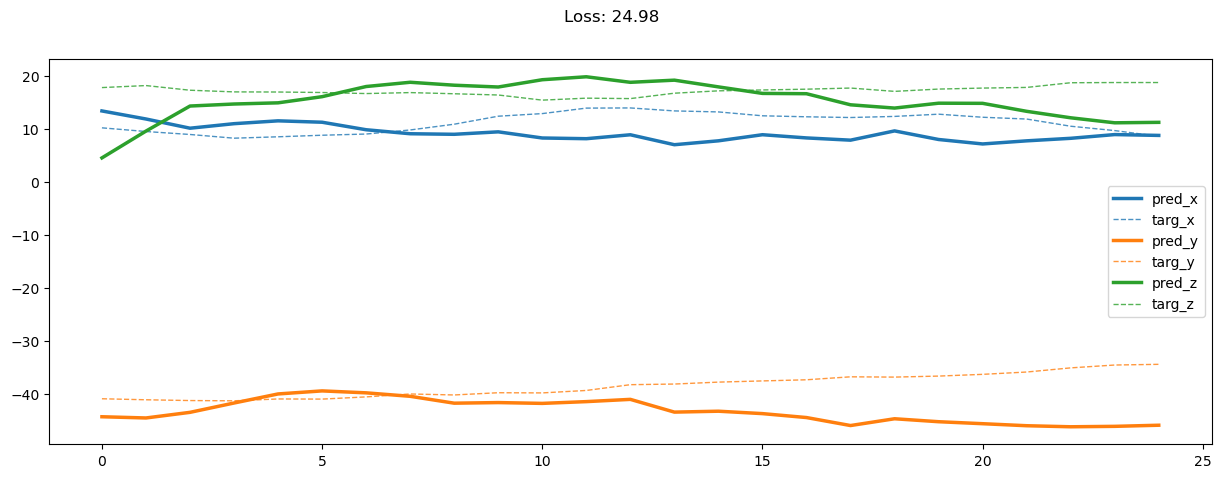

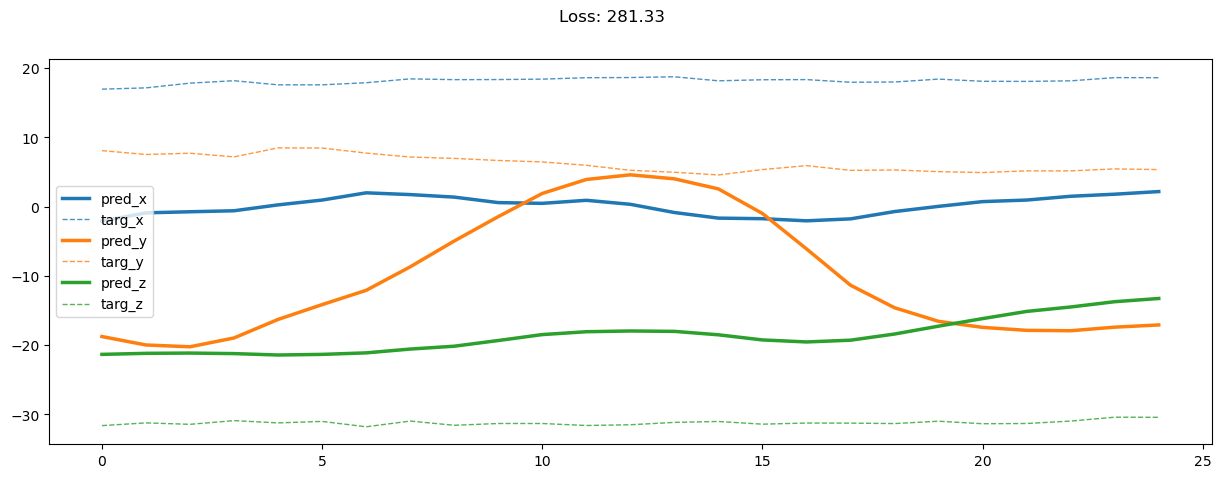

00059: train loss:  44.528, imu loss:  0.698, mag loss:  43.830, div loss:  86.617
       valid loss:  305.814, imu loss:  0.430, mag loss:  305.384, div loss:  226.302
00079: train loss:  44.703, imu loss:  0.700, mag loss:  44.002, div loss:  86.598
       valid loss:  307.609, imu loss:  0.430, mag loss:  307.179, div loss:  224.009


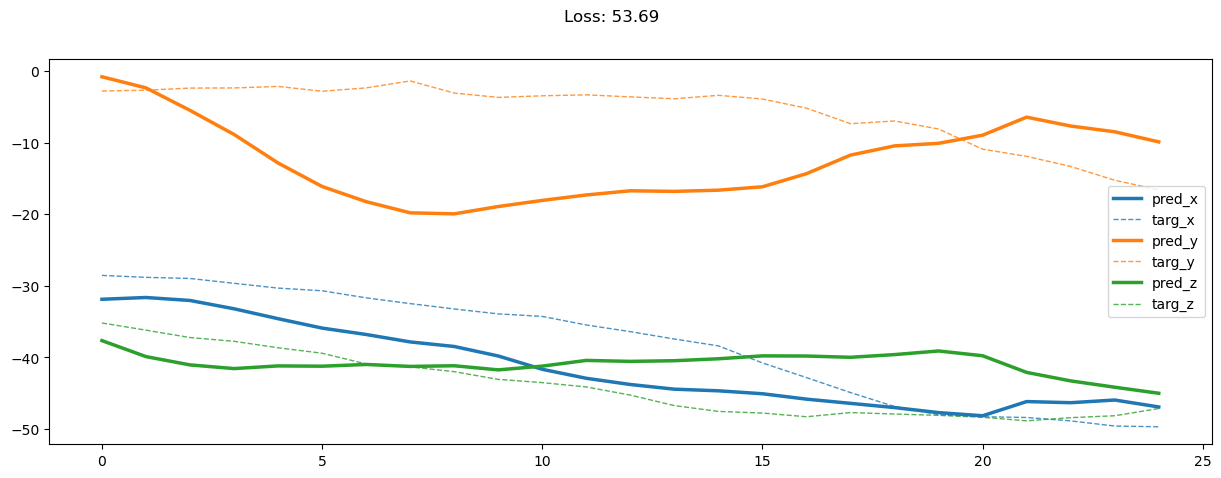

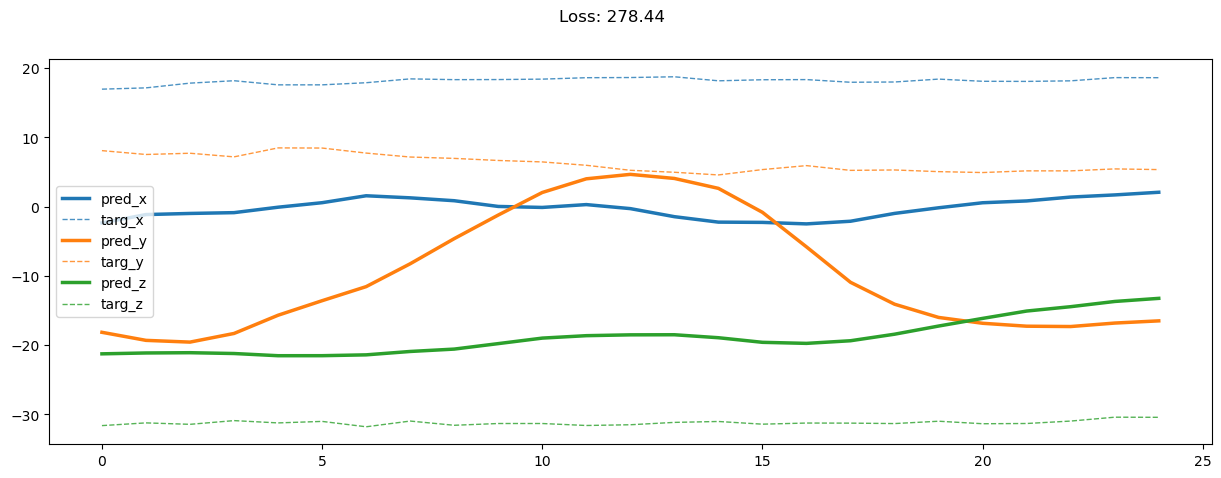

00099: train loss:  44.408, imu loss:  0.700, mag loss:  43.709, div loss:  85.977
       valid loss:  307.566, imu loss:  0.430, mag loss:  307.136, div loss:  224.104
00119: train loss:  43.680, imu loss:  0.699, mag loss:  42.981, div loss:  84.654
       valid loss:  309.035, imu loss:  0.430, mag loss:  308.605, div loss:  225.404
00139: train loss:  43.580, imu loss:  0.698, mag loss:  42.882, div loss:  84.497
       valid loss:  307.916, imu loss:  0.430, mag loss:  307.486, div loss:  226.213


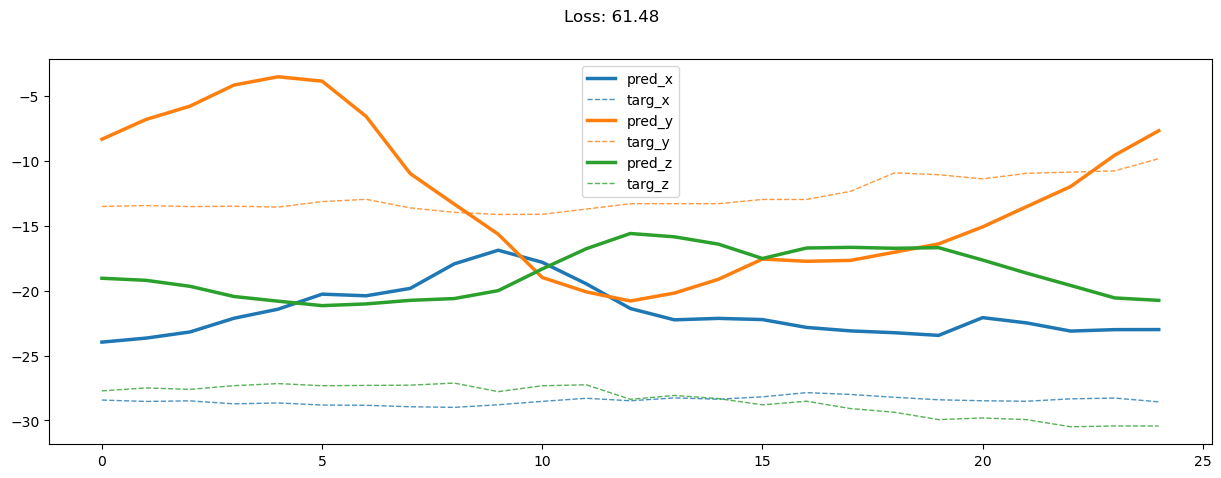

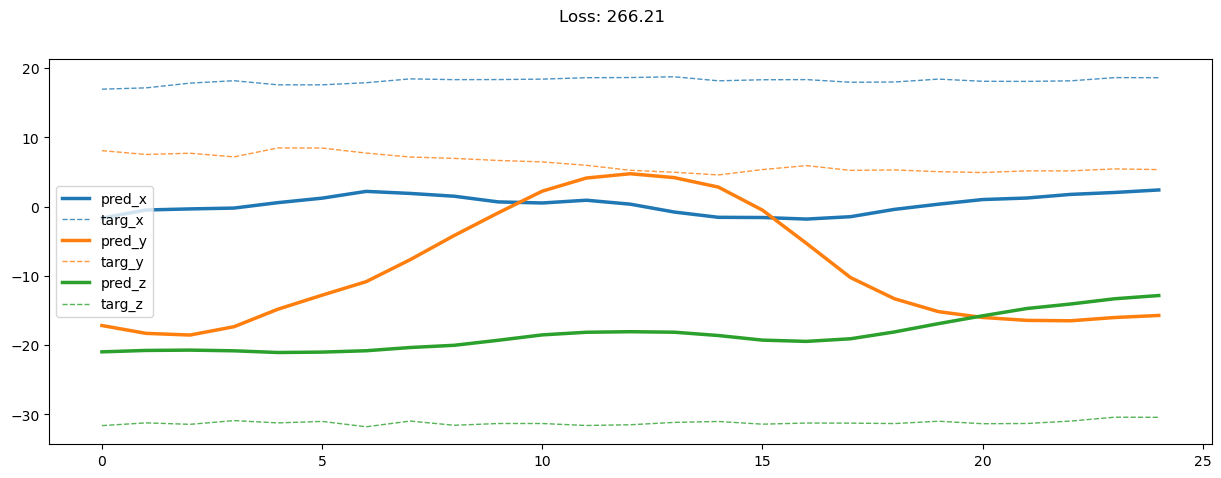

00159: train loss:  43.127, imu loss:  0.698, mag loss:  42.429, div loss:  83.244
       valid loss:  307.877, imu loss:  0.430, mag loss:  307.448, div loss:  226.380
00179: train loss:  43.007, imu loss:  0.698, mag loss:  42.309, div loss:  82.833
       valid loss:  313.024, imu loss:  0.430, mag loss:  312.595, div loss:  226.568


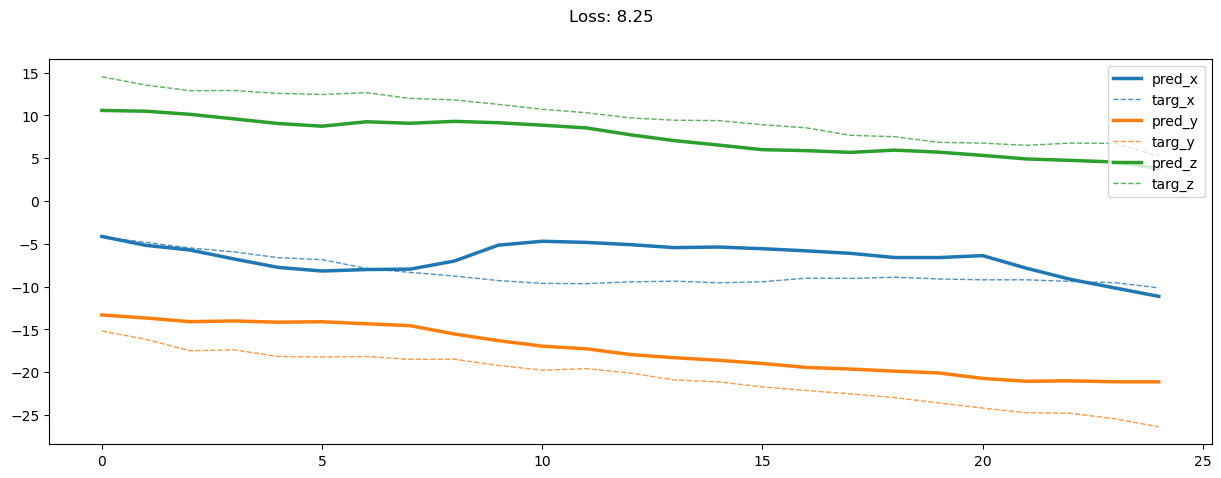

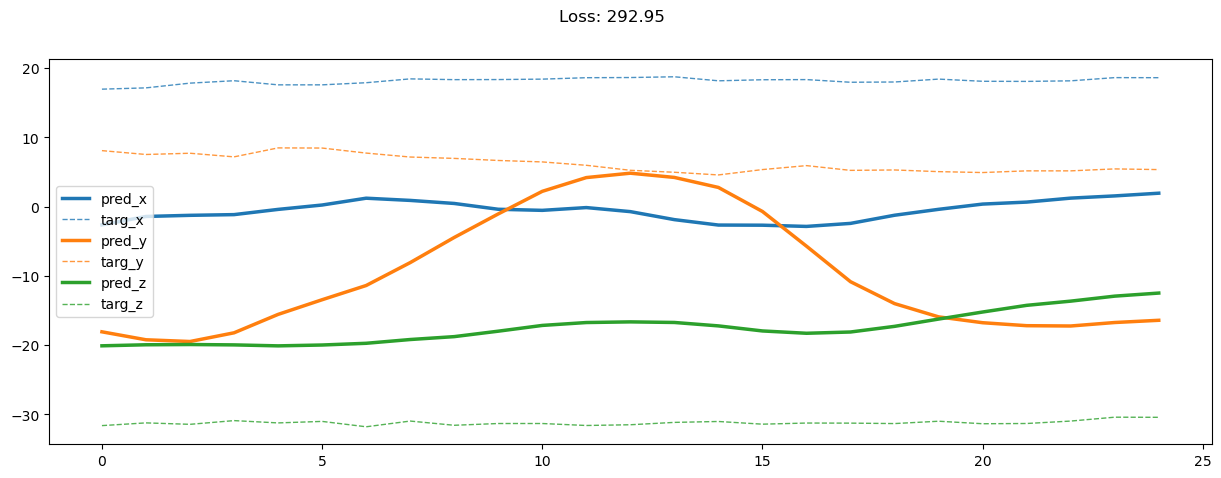

00199: train loss:  42.453, imu loss:  0.700, mag loss:  41.753, div loss:  82.397
       valid loss:  311.479, imu loss:  0.430, mag loss:  311.049, div loss:  228.201
00219: train loss:  42.487, imu loss:  0.700, mag loss:  41.787, div loss:  82.350
       valid loss:  309.481, imu loss:  0.430, mag loss:  309.051, div loss:  228.019
00239: train loss:  41.976, imu loss:  0.699, mag loss:  41.277, div loss:  81.239
       valid loss:  314.609, imu loss:  0.430, mag loss:  314.180, div loss:  227.347


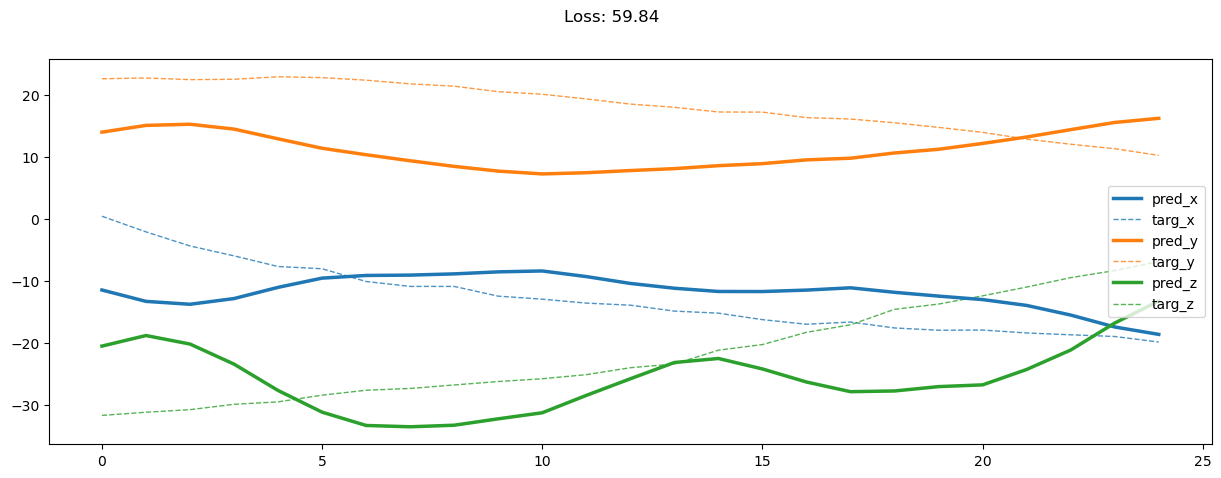

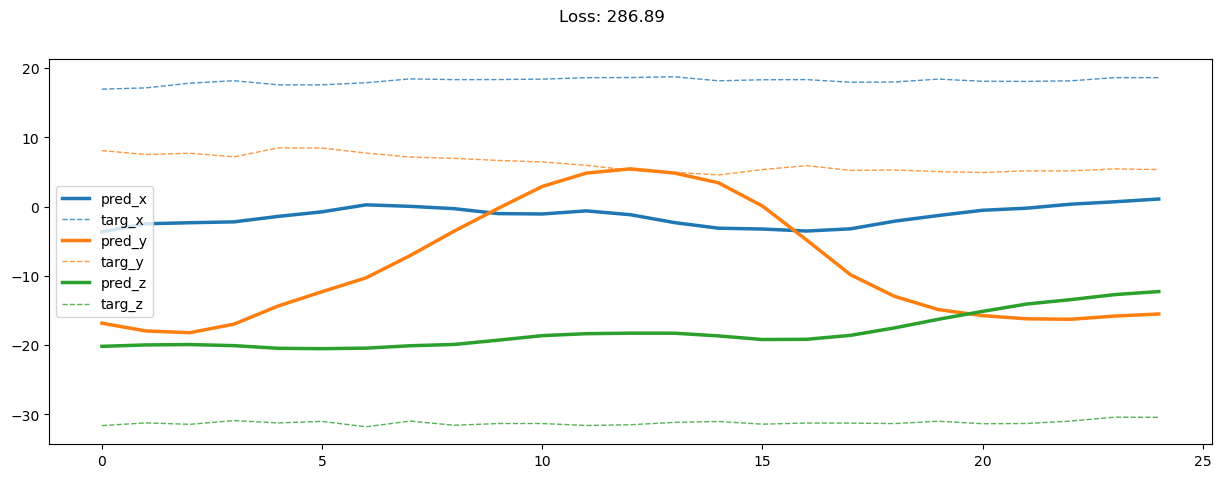

00259: train loss:  41.987, imu loss:  0.701, mag loss:  41.286, div loss:  81.276
       valid loss:  311.357, imu loss:  0.430, mag loss:  310.927, div loss:  227.154
00279: train loss:  41.719, imu loss:  0.702, mag loss:  41.016, div loss:  80.875
       valid loss:  316.826, imu loss:  0.430, mag loss:  316.396, div loss:  230.078


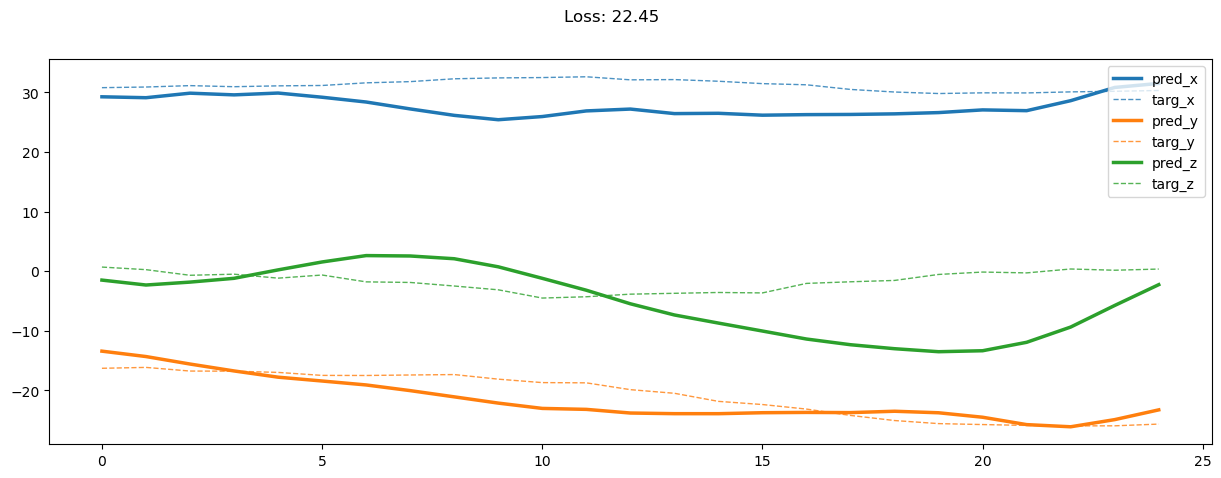

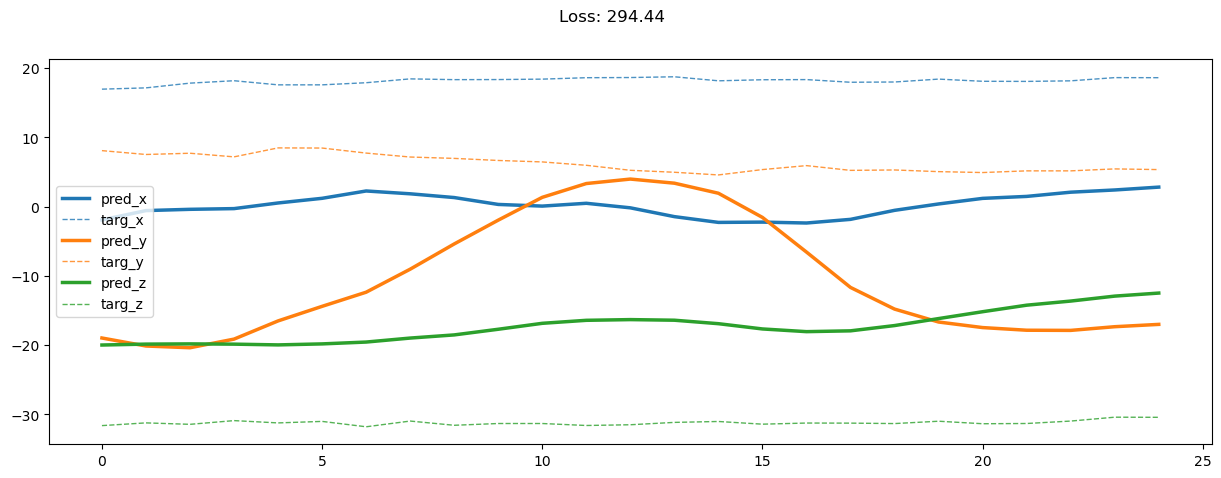

00299: train loss:  41.561, imu loss:  0.699, mag loss:  40.862, div loss:  80.718
       valid loss:  318.538, imu loss:  0.430, mag loss:  318.109, div loss:  229.502
00319: train loss:  41.442, imu loss:  0.700, mag loss:  40.743, div loss:  80.677
       valid loss:  317.781, imu loss:  0.430, mag loss:  317.351, div loss:  230.791
00339: train loss:  41.271, imu loss:  0.700, mag loss:  40.571, div loss:  80.066
       valid loss:  315.438, imu loss:  0.430, mag loss:  315.008, div loss:  229.177


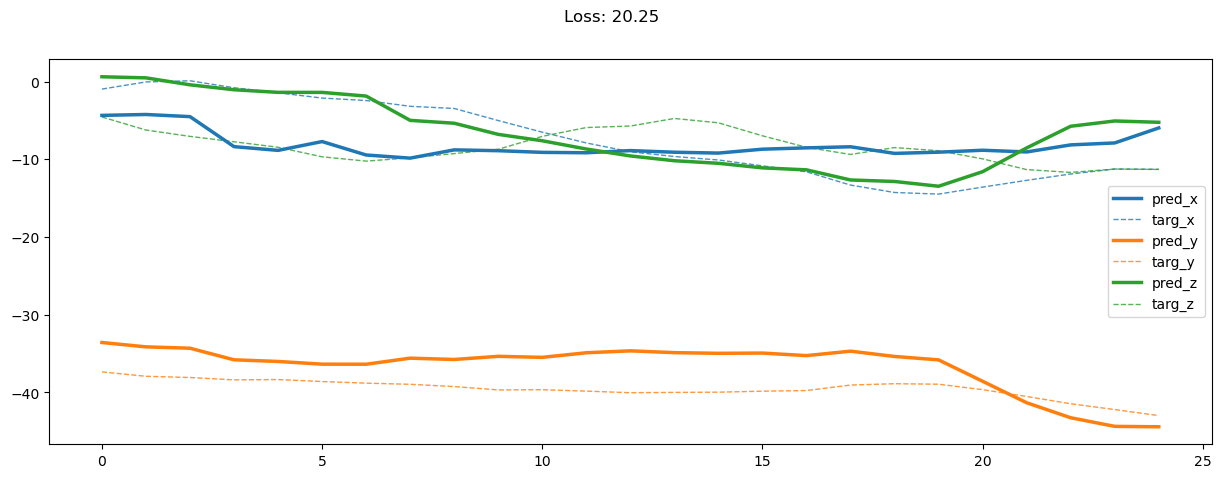

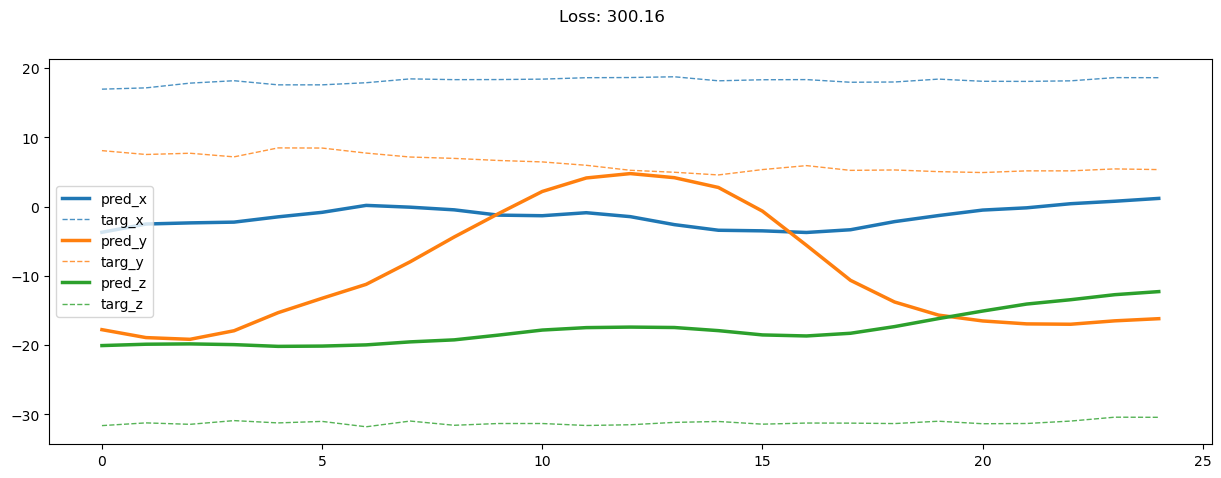

00359: train loss:  40.838, imu loss:  0.701, mag loss:  40.137, div loss:  79.278
       valid loss:  320.555, imu loss:  0.430, mag loss:  320.125, div loss:  229.199
00379: train loss:  40.591, imu loss:  0.698, mag loss:  39.893, div loss:  78.521
       valid loss:  318.884, imu loss:  0.430, mag loss:  318.454, div loss:  228.971


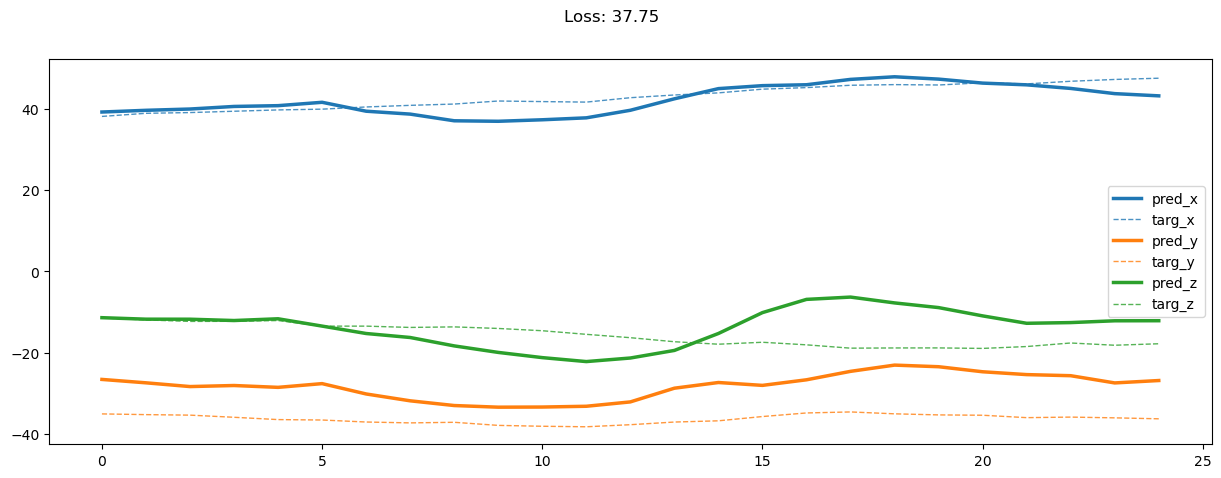

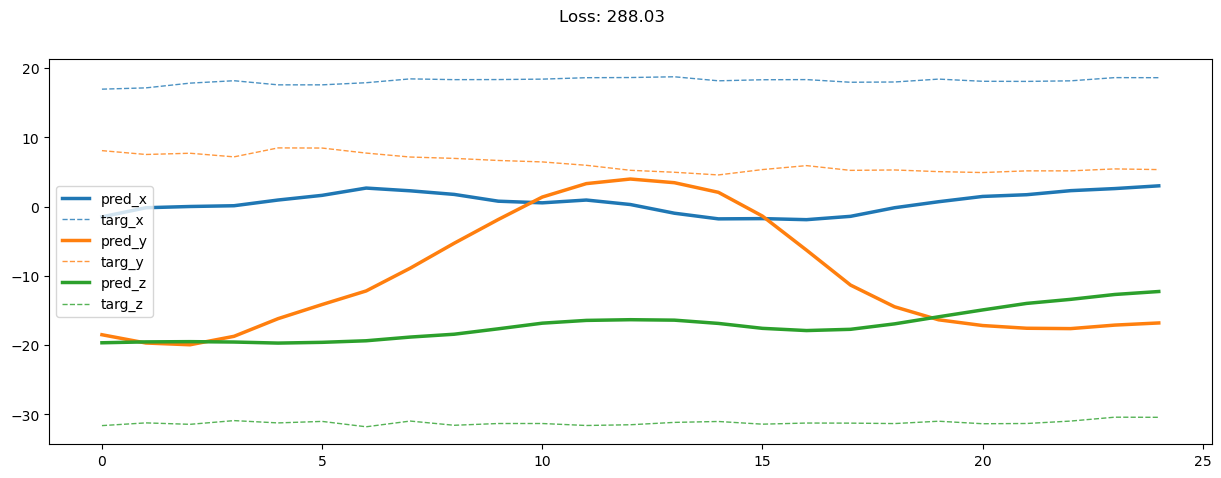

00399: train loss:  40.283, imu loss:  0.703, mag loss:  39.579, div loss:  78.023
       valid loss:  316.770, imu loss:  0.430, mag loss:  316.340, div loss:  229.380
00419: train loss:  40.079, imu loss:  0.700, mag loss:  39.379, div loss:  77.613
       valid loss:  318.806, imu loss:  0.430, mag loss:  318.376, div loss:  229.709
00439: train loss:  39.881, imu loss:  0.702, mag loss:  39.180, div loss:  77.285
       valid loss:  312.974, imu loss:  0.430, mag loss:  312.544, div loss:  229.837


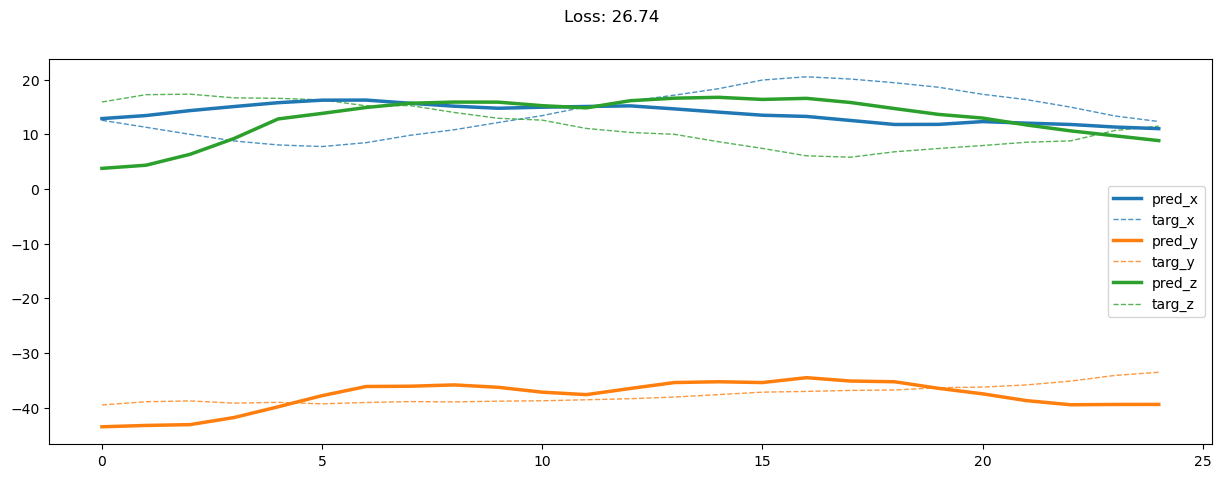

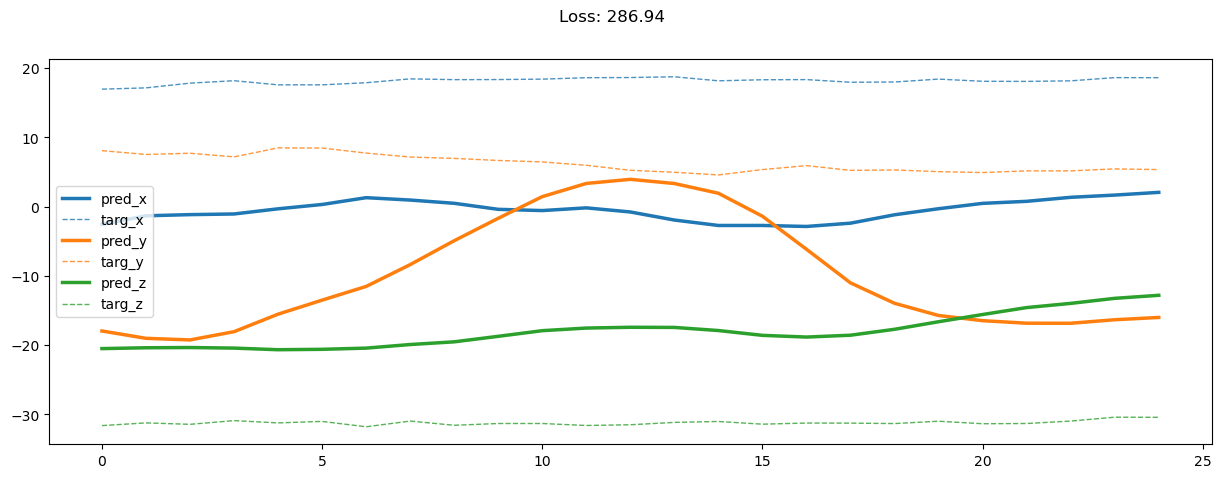

00459: train loss:  39.654, imu loss:  0.701, mag loss:  38.953, div loss:  77.420
       valid loss:  320.764, imu loss:  0.430, mag loss:  320.334, div loss:  231.775
00479: train loss:  39.168, imu loss:  0.699, mag loss:  38.469, div loss:  76.291
       valid loss:  320.728, imu loss:  0.430, mag loss:  320.299, div loss:  232.798


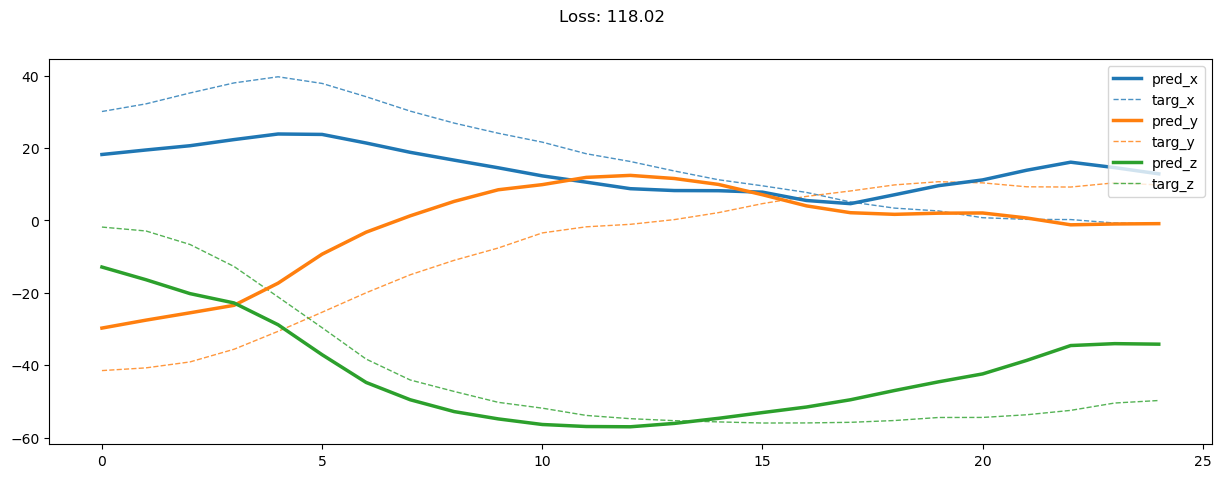

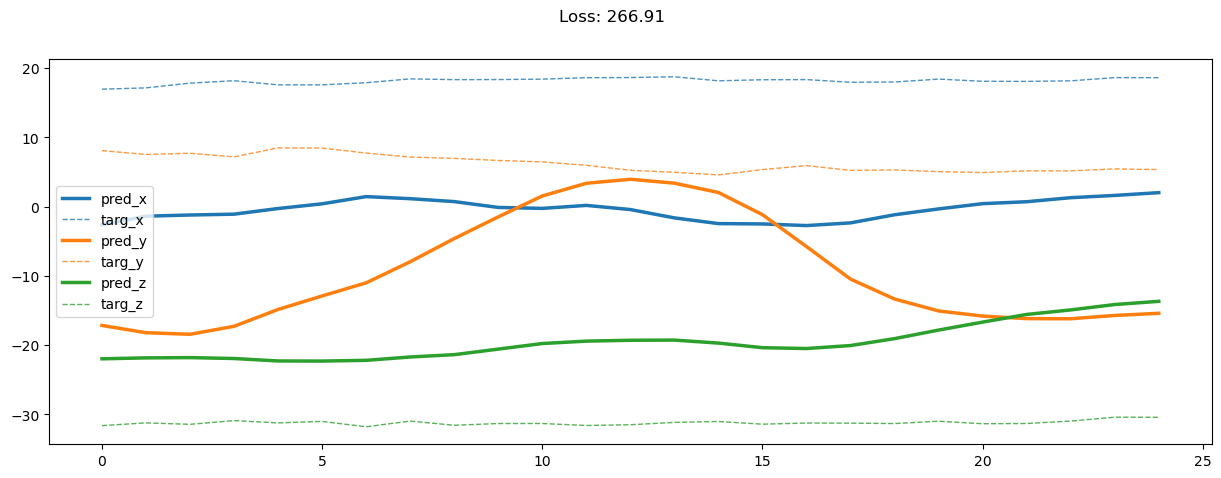

00499: train loss:  39.501, imu loss:  0.698, mag loss:  38.803, div loss:  76.873
       valid loss:  316.017, imu loss:  0.430, mag loss:  315.587, div loss:  231.836
00519: train loss:  38.937, imu loss:  0.700, mag loss:  38.237, div loss:  75.585
       valid loss:  325.531, imu loss:  0.430, mag loss:  325.101, div loss:  233.665
00539: train loss:  38.576, imu loss:  0.699, mag loss:  37.877, div loss:  74.307
       valid loss:  320.998, imu loss:  0.430, mag loss:  320.568, div loss:  232.837


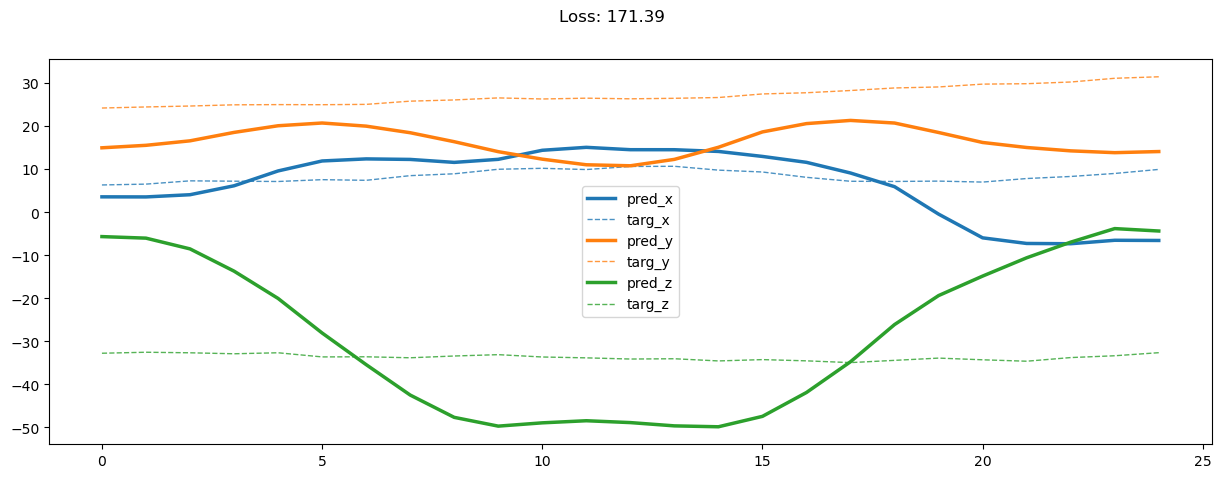

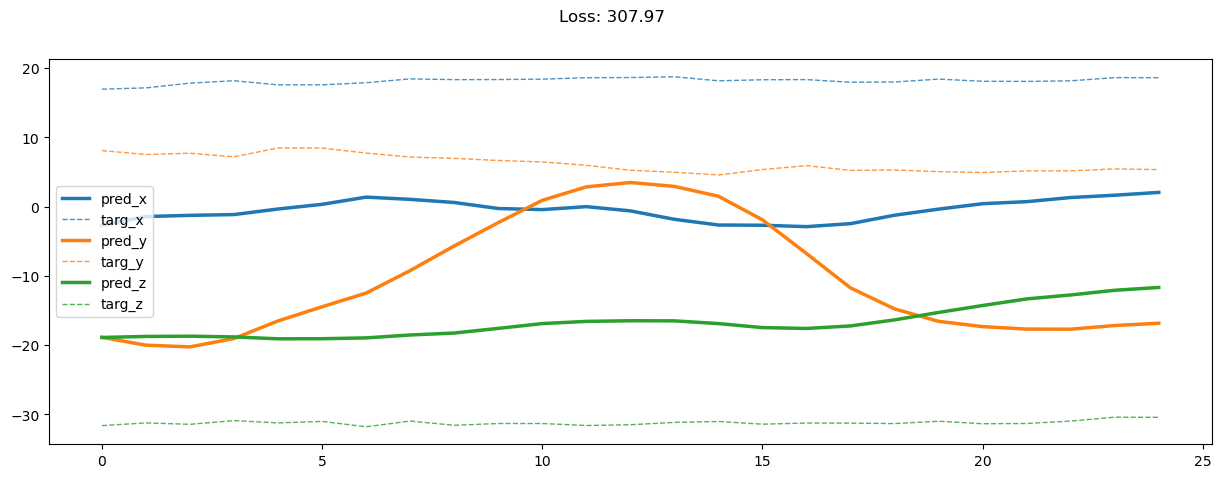

00559: train loss:  38.508, imu loss:  0.696, mag loss:  37.812, div loss:  74.603
       valid loss:  322.648, imu loss:  0.430, mag loss:  322.218, div loss:  233.165
00579: train loss:  38.615, imu loss:  0.699, mag loss:  37.915, div loss:  74.808
       valid loss:  320.623, imu loss:  0.430, mag loss:  320.193, div loss:  232.630


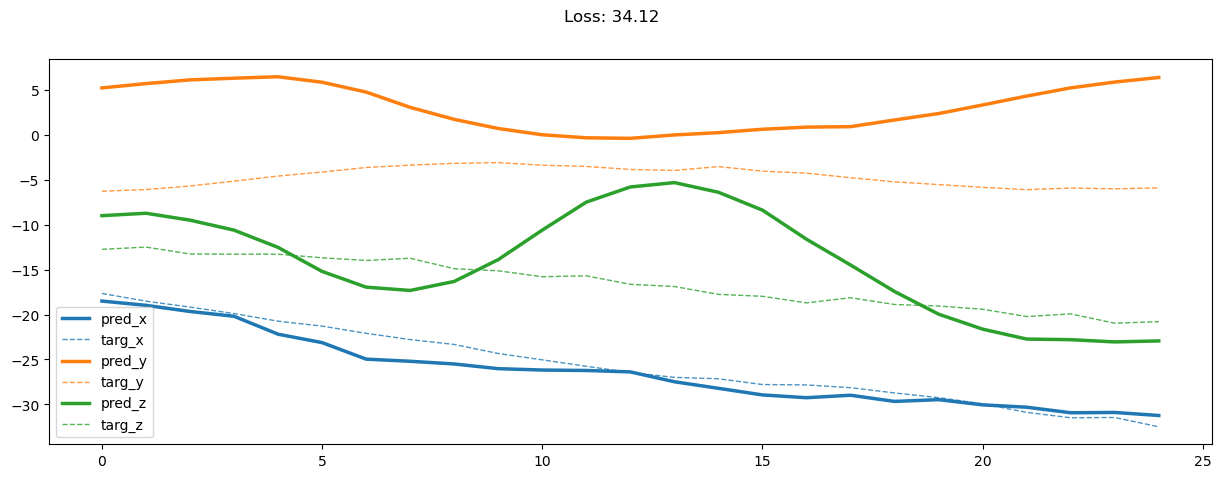

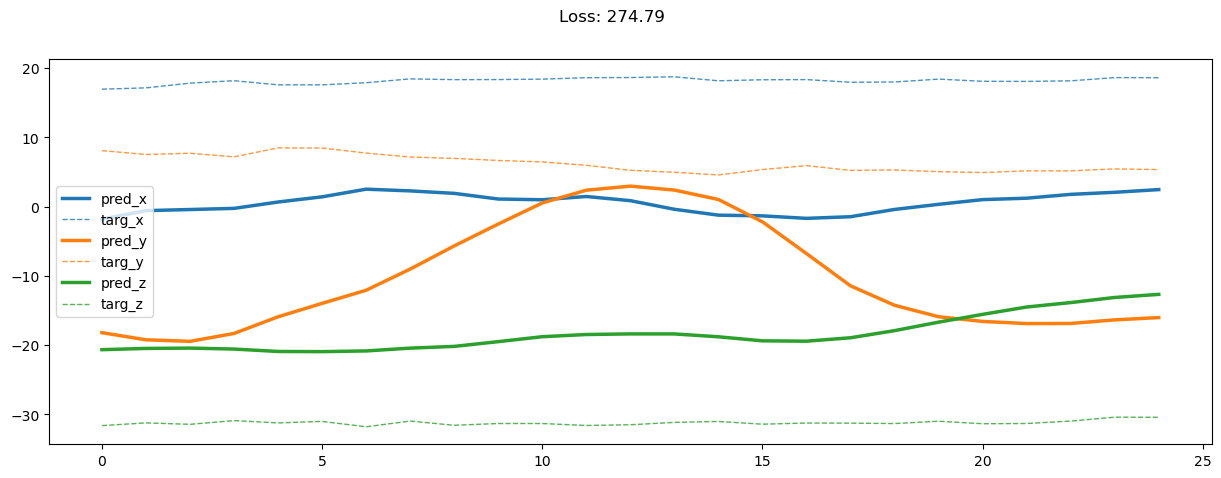

00599: train loss:  37.946, imu loss:  0.696, mag loss:  37.250, div loss:  73.332
       valid loss:  321.334, imu loss:  0.430, mag loss:  320.904, div loss:  231.858
00619: train loss:  38.356, imu loss:  0.698, mag loss:  37.658, div loss:  74.128
       valid loss:  322.899, imu loss:  0.430, mag loss:  322.470, div loss:  233.238
00639: train loss:  38.002, imu loss:  0.697, mag loss:  37.305, div loss:  73.656
       valid loss:  326.962, imu loss:  0.430, mag loss:  326.532, div loss:  234.963


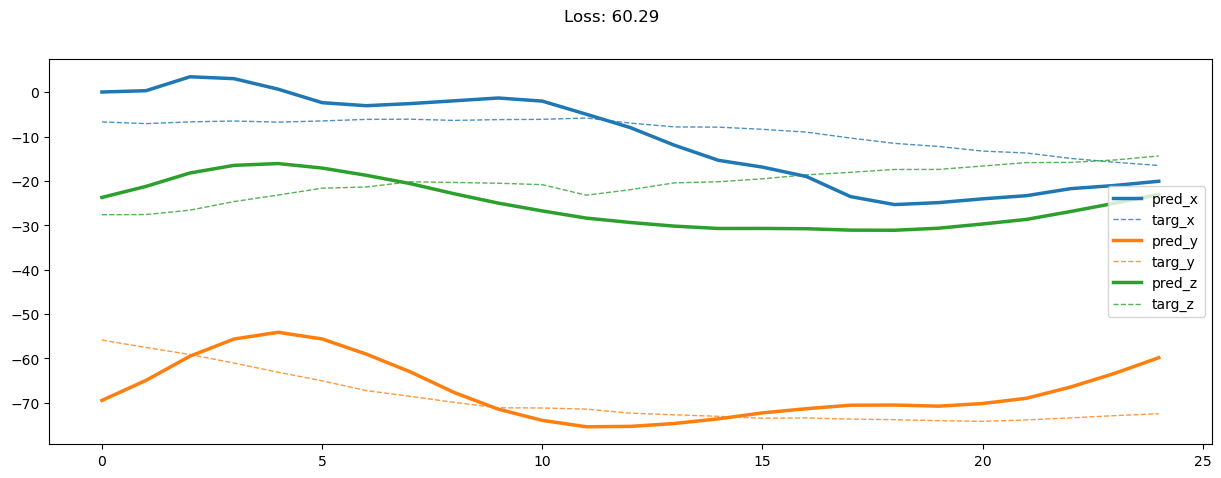

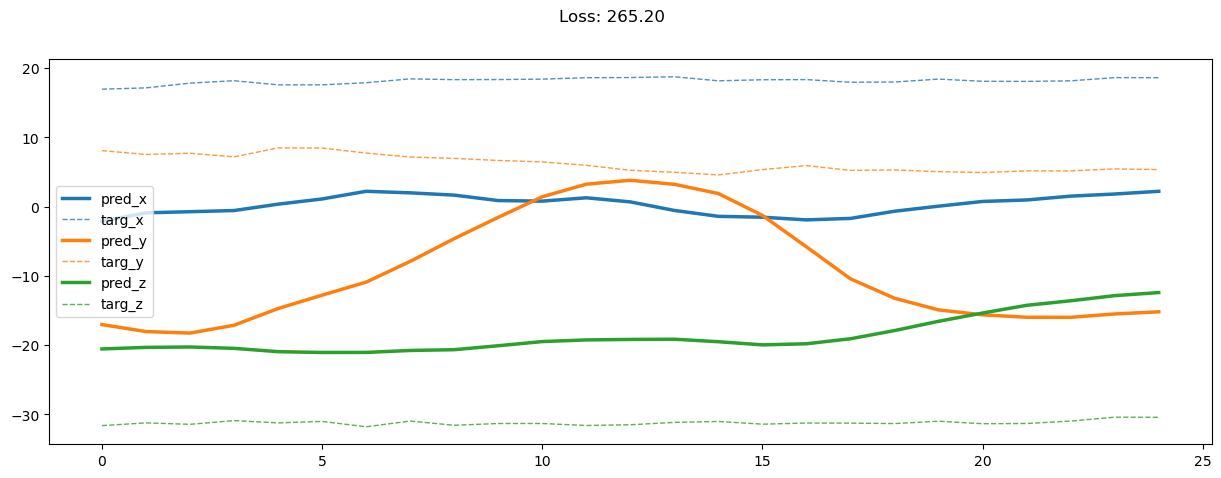

00659: train loss:  37.777, imu loss:  0.700, mag loss:  37.077, div loss:  73.592
       valid loss:  325.295, imu loss:  0.430, mag loss:  324.865, div loss:  233.061
00679: train loss:  37.249, imu loss:  0.699, mag loss:  36.551, div loss:  72.082
       valid loss:  323.963, imu loss:  0.430, mag loss:  323.534, div loss:  235.191


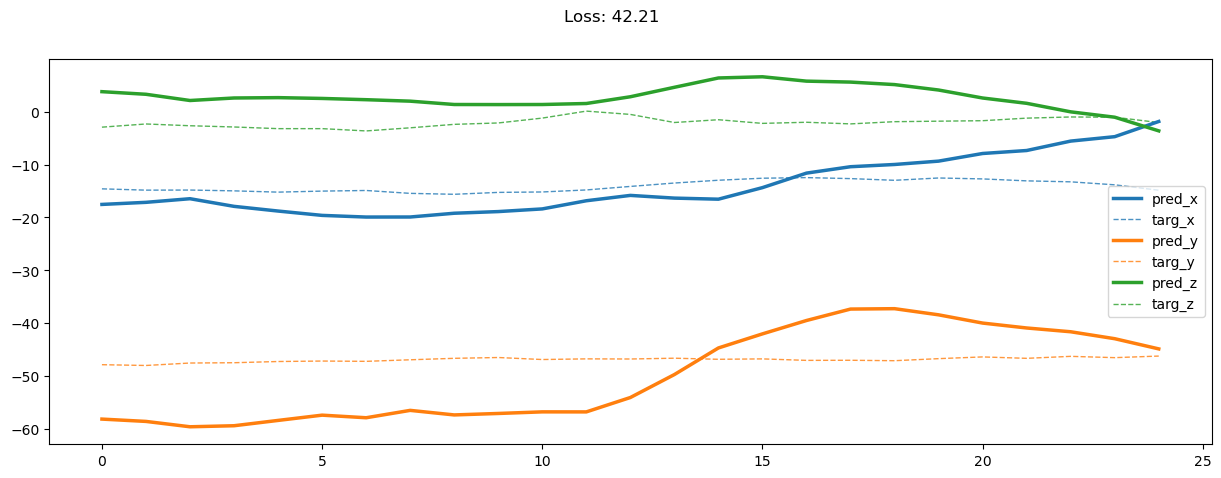

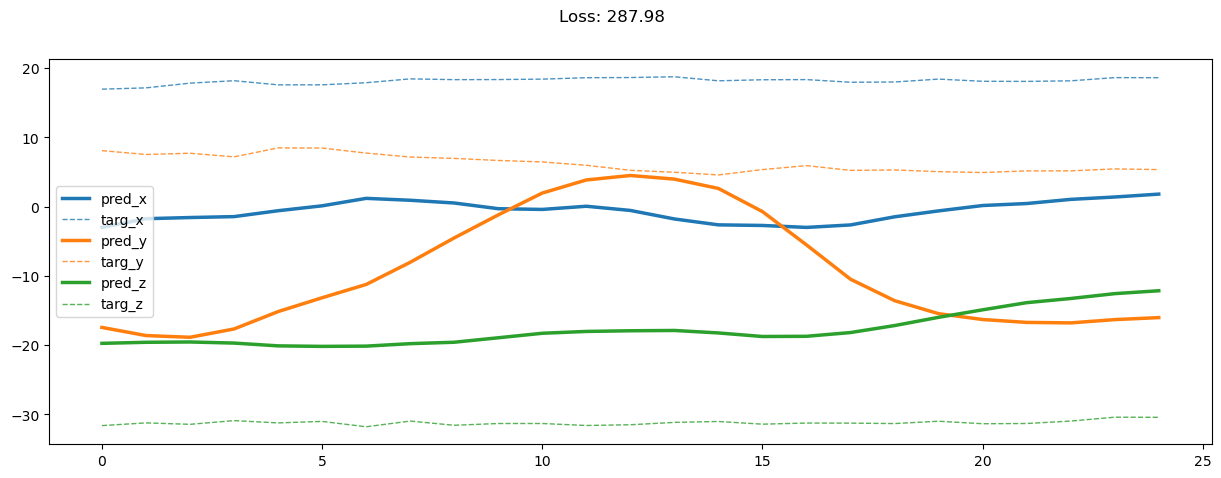

00699: train loss:  36.985, imu loss:  0.701, mag loss:  36.284, div loss:  71.797
       valid loss:  325.388, imu loss:  0.430, mag loss:  324.958, div loss:  234.168
00719: train loss:  36.779, imu loss:  0.698, mag loss:  36.081, div loss:  71.280
       valid loss:  327.350, imu loss:  0.430, mag loss:  326.920, div loss:  234.386
00739: train loss:  36.772, imu loss:  0.700, mag loss:  36.073, div loss:  71.652
       valid loss:  326.185, imu loss:  0.430, mag loss:  325.755, div loss:  235.458


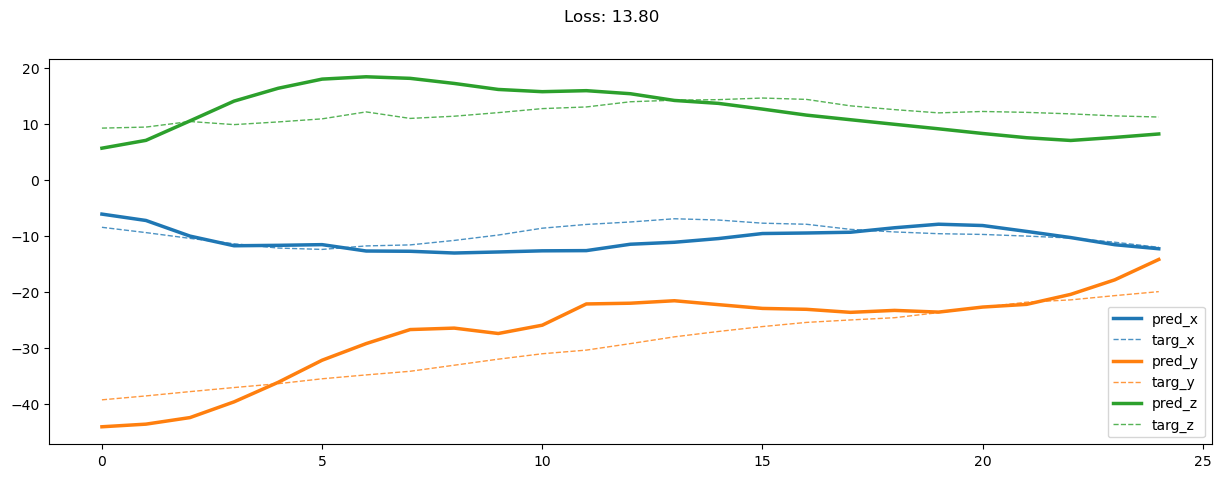

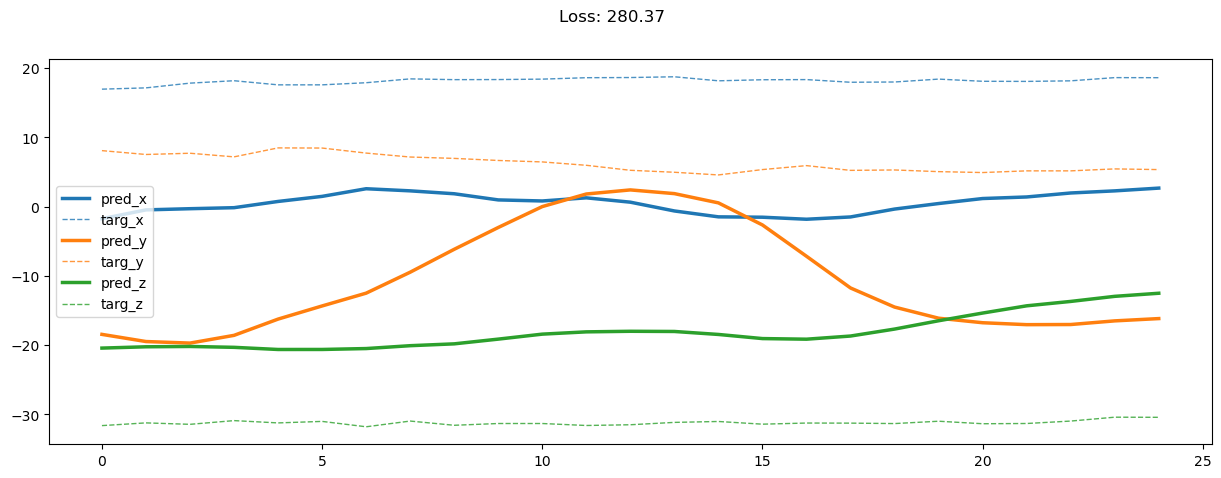

00759: train loss:  36.846, imu loss:  0.701, mag loss:  36.145, div loss:  71.830
       valid loss:  323.678, imu loss:  0.430, mag loss:  323.248, div loss:  234.557
00779: train loss:  36.648, imu loss:  0.698, mag loss:  35.950, div loss:  71.016
       valid loss:  331.392, imu loss:  0.430, mag loss:  330.962, div loss:  235.374


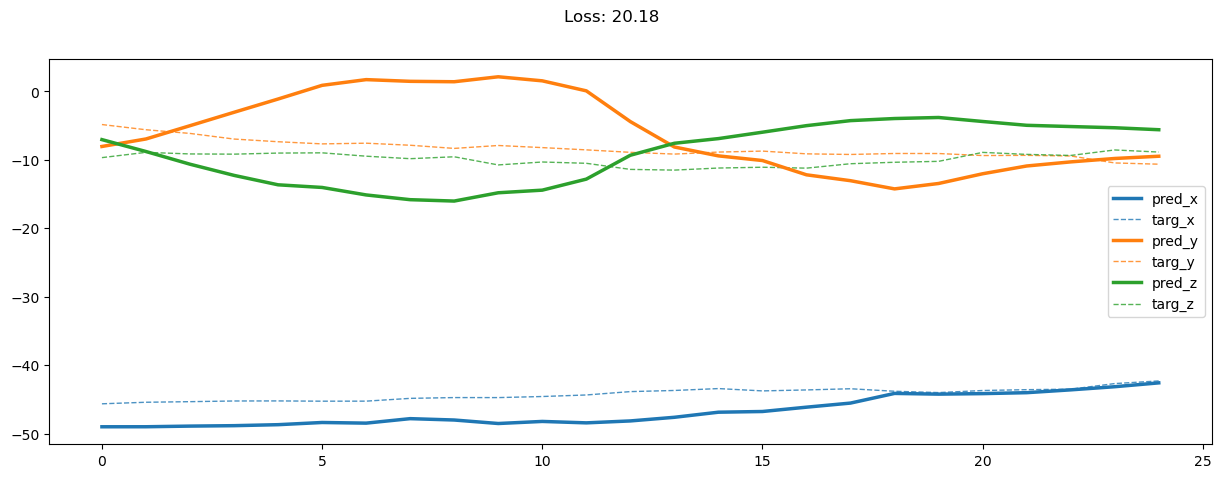

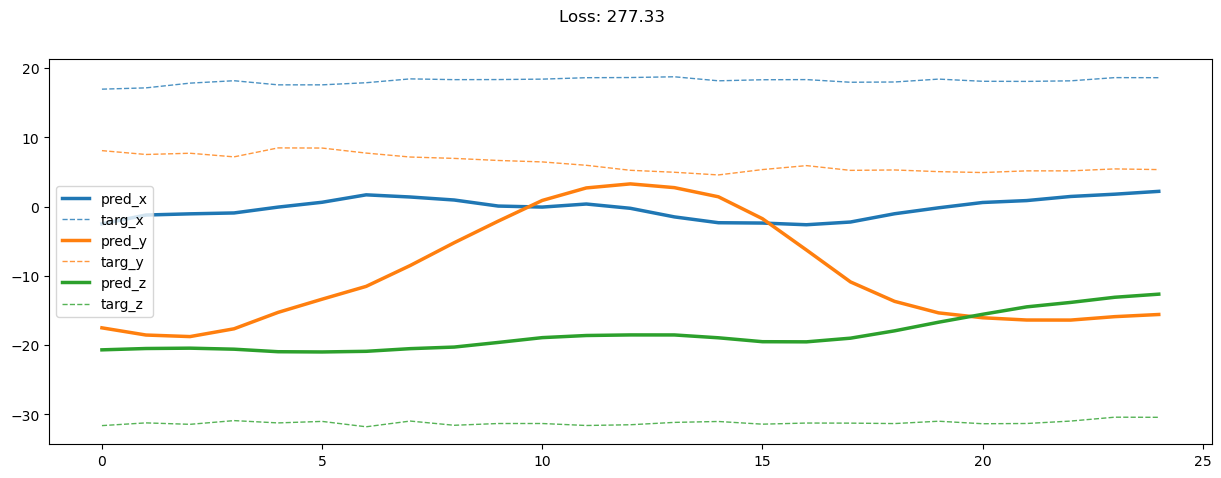

00799: train loss:  36.157, imu loss:  0.697, mag loss:  35.459, div loss:  69.574
       valid loss:  325.966, imu loss:  0.430, mag loss:  325.536, div loss:  234.790
00819: train loss:  36.000, imu loss:  0.698, mag loss:  35.301, div loss:  69.647
       valid loss:  328.563, imu loss:  0.430, mag loss:  328.133, div loss:  237.438
00839: train loss:  36.018, imu loss:  0.699, mag loss:  35.319, div loss:  69.506
       valid loss:  323.301, imu loss:  0.430, mag loss:  322.871, div loss:  235.840


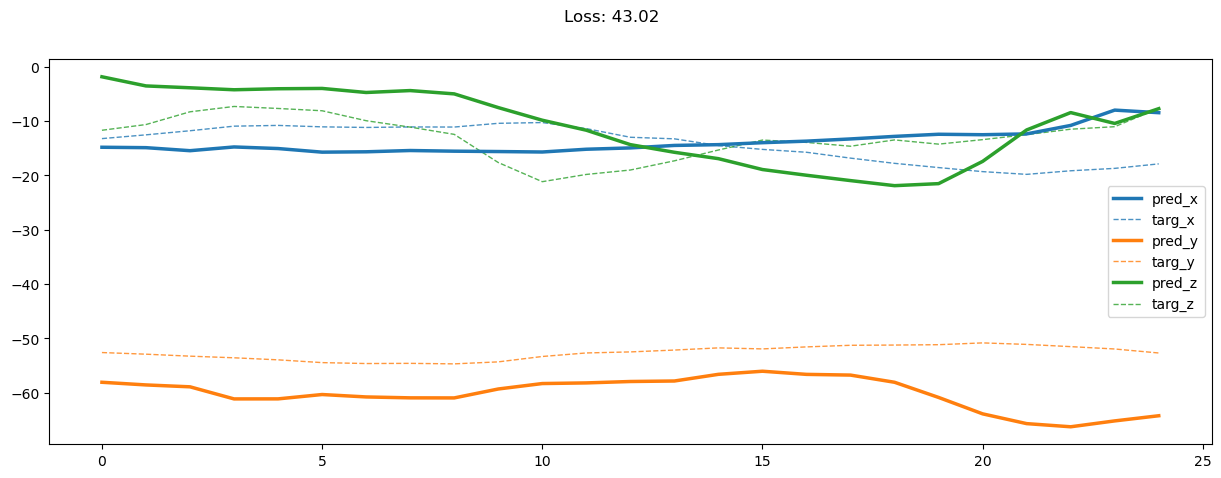

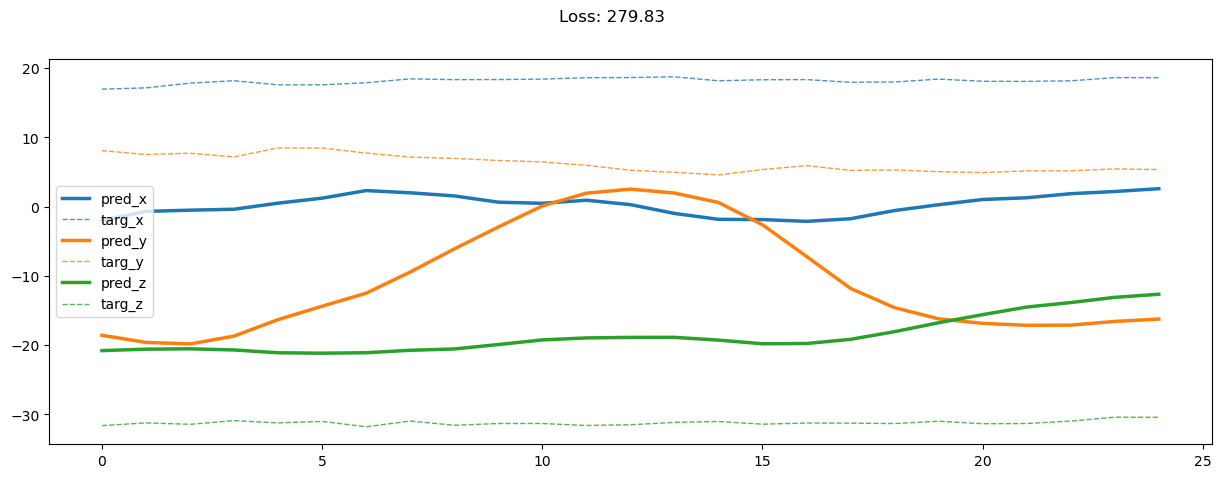

00859: train loss:  35.609, imu loss:  0.697, mag loss:  34.912, div loss:  69.101
       valid loss:  327.428, imu loss:  0.430, mag loss:  326.998, div loss:  237.159
00879: train loss:  35.426, imu loss:  0.699, mag loss:  34.726, div loss:  68.855
       valid loss:  333.676, imu loss:  0.430, mag loss:  333.247, div loss:  238.170


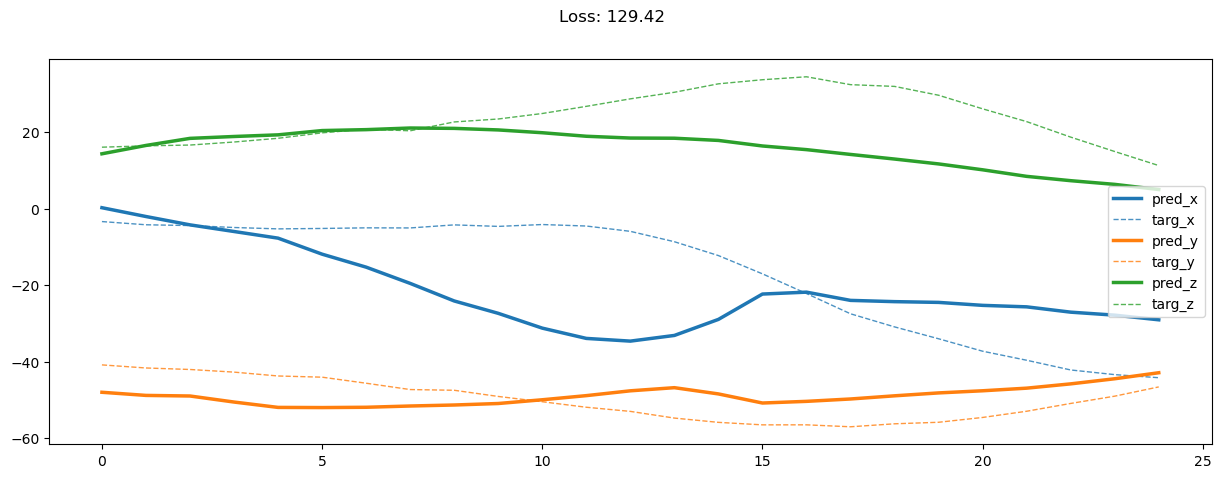

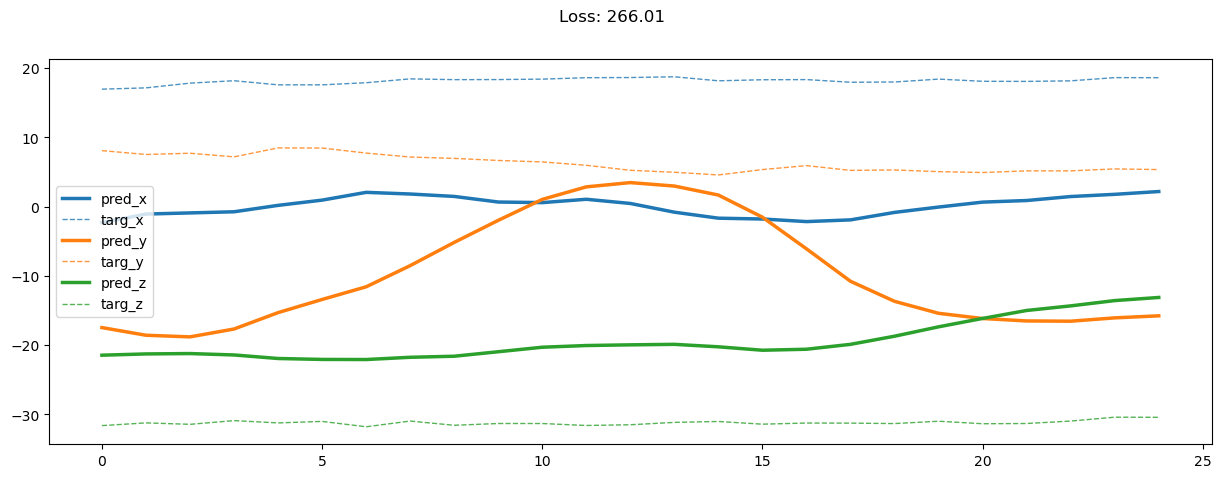

00899: train loss:  35.349, imu loss:  0.702, mag loss:  34.646, div loss:  68.278
       valid loss:  330.859, imu loss:  0.430, mag loss:  330.429, div loss:  237.418
00919: train loss:  35.114, imu loss:  0.700, mag loss:  34.414, div loss:  67.909
       valid loss:  329.173, imu loss:  0.430, mag loss:  328.743, div loss:  237.677
00939: train loss:  34.892, imu loss:  0.697, mag loss:  34.195, div loss:  67.846
       valid loss:  332.235, imu loss:  0.430, mag loss:  331.805, div loss:  236.405


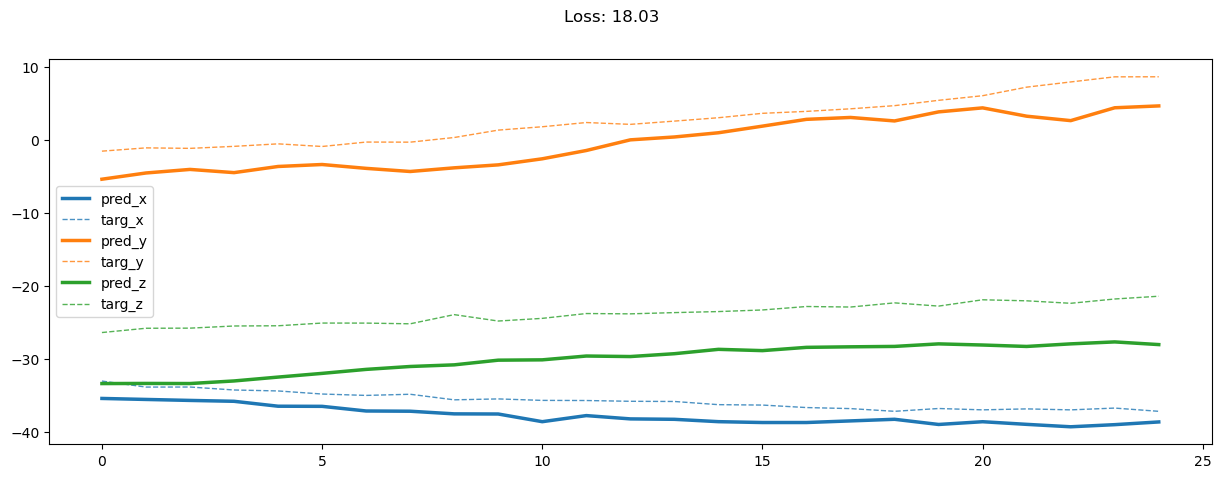

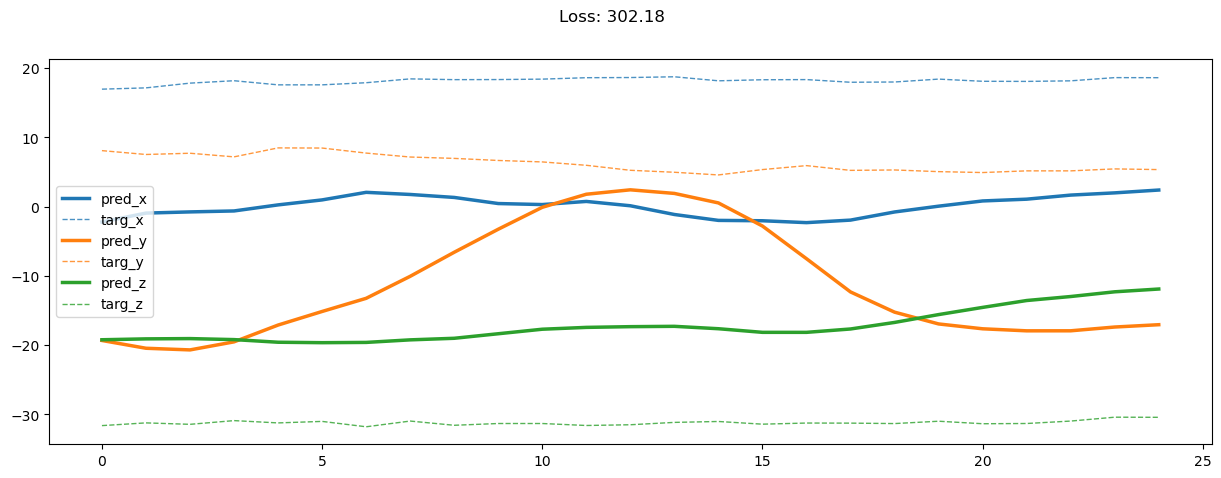

00959: train loss:  35.134, imu loss:  0.698, mag loss:  34.436, div loss:  68.484
       valid loss:  332.010, imu loss:  0.430, mag loss:  331.580, div loss:  237.884
00979: train loss:  34.733, imu loss:  0.701, mag loss:  34.032, div loss:  67.348
       valid loss:  333.245, imu loss:  0.430, mag loss:  332.815, div loss:  238.647


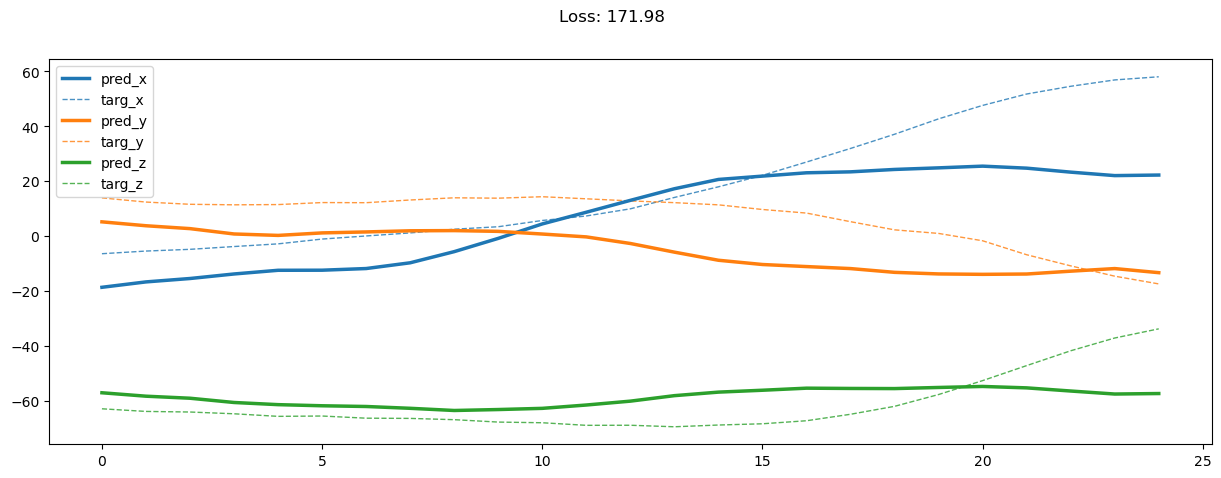

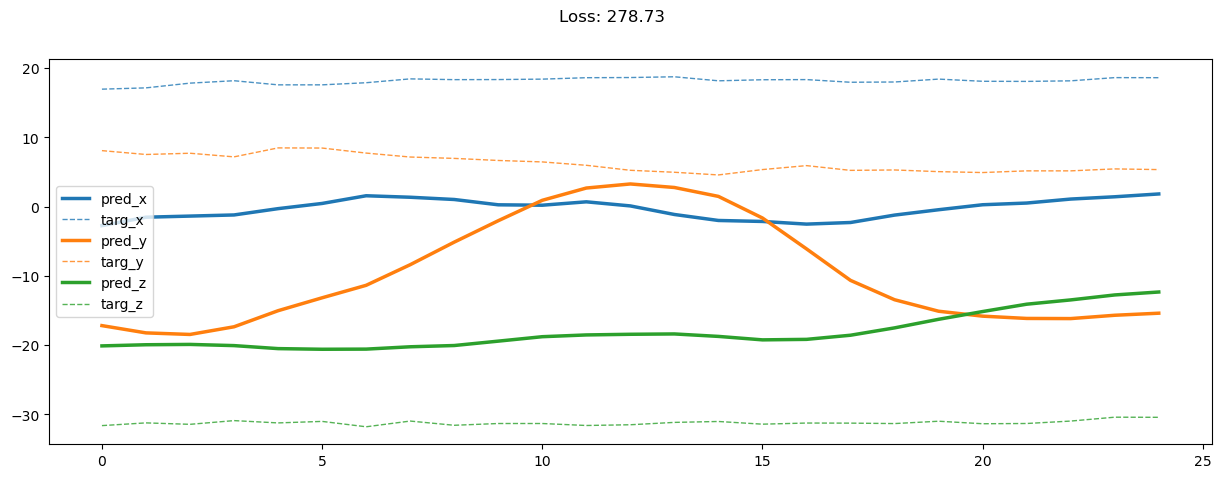

00999: train loss:  34.688, imu loss:  0.700, mag loss:  33.988, div loss:  67.113
       valid loss:  331.610, imu loss:  0.430, mag loss:  331.181, div loss:  236.623
01019: train loss:  34.459, imu loss:  0.699, mag loss:  33.760, div loss:  66.981
       valid loss:  333.816, imu loss:  0.430, mag loss:  333.387, div loss:  240.097
01039: train loss:  34.538, imu loss:  0.698, mag loss:  33.840, div loss:  66.716
       valid loss:  328.677, imu loss:  0.430, mag loss:  328.247, div loss:  237.444


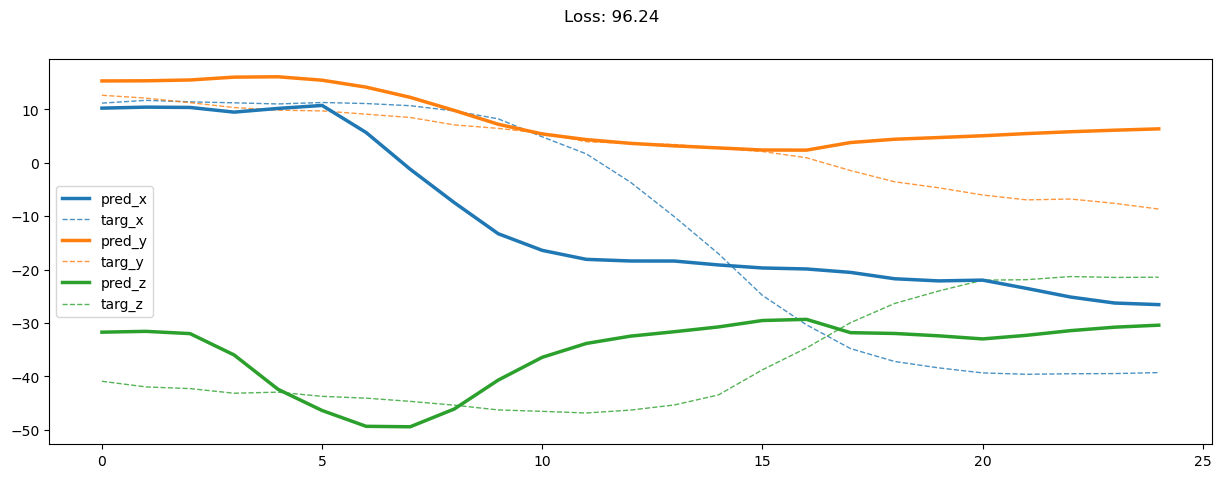

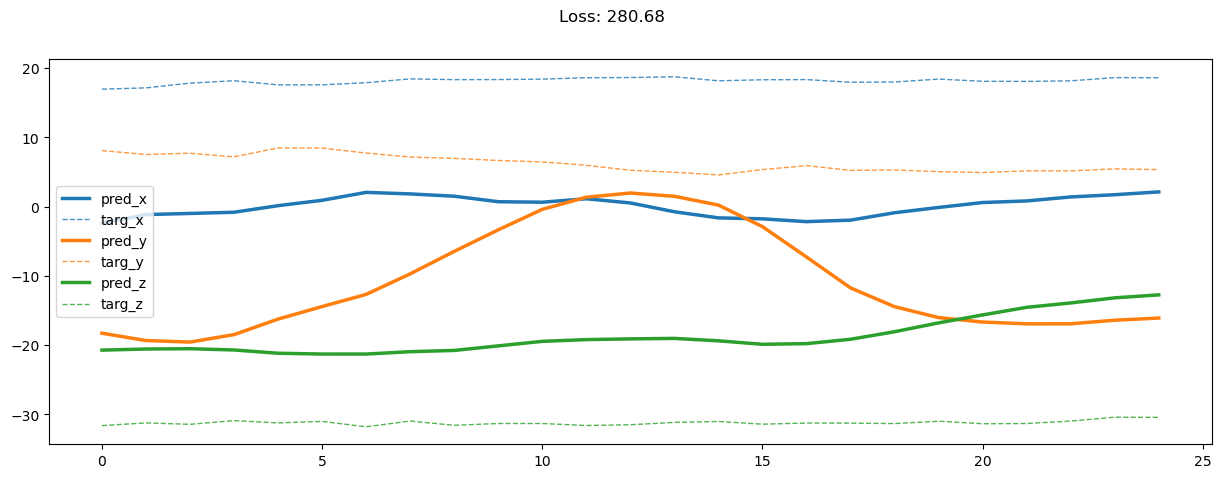

01059: train loss:  34.276, imu loss:  0.700, mag loss:  33.576, div loss:  66.405
       valid loss:  330.212, imu loss:  0.430, mag loss:  329.782, div loss:  239.274
01079: train loss:  34.022, imu loss:  0.698, mag loss:  33.324, div loss:  65.811
       valid loss:  333.657, imu loss:  0.430, mag loss:  333.228, div loss:  239.211


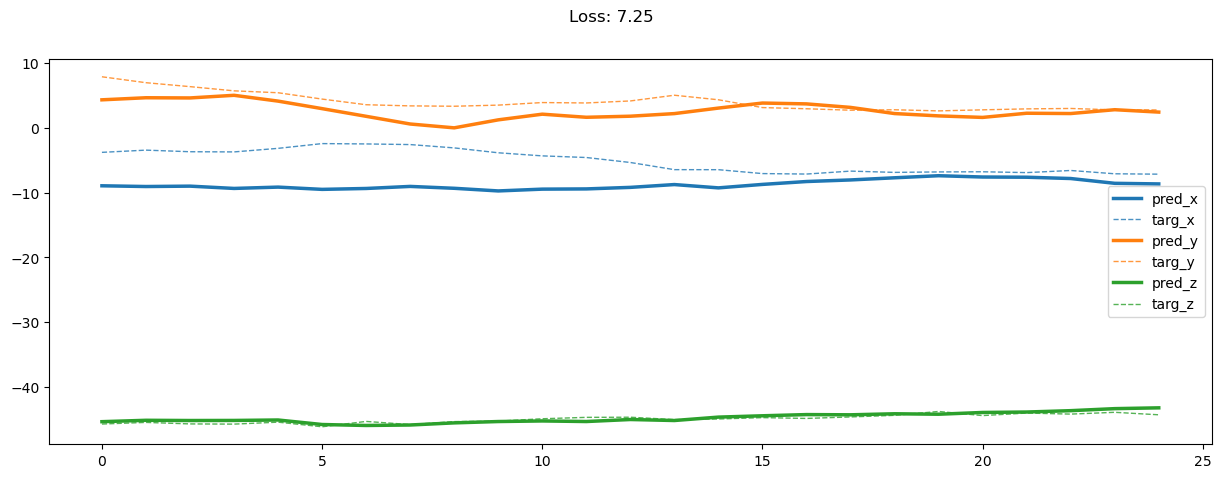

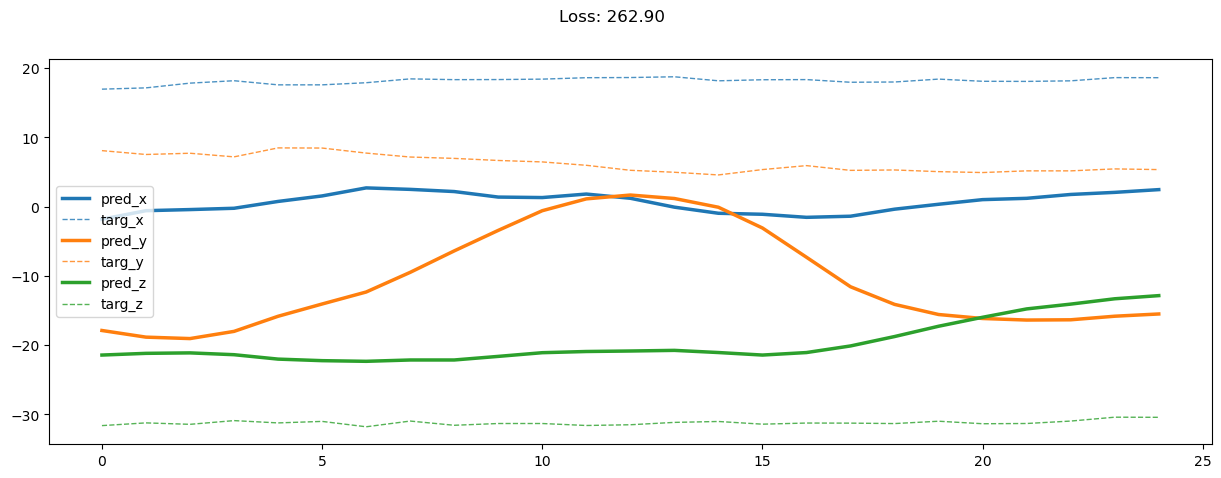

01099: train loss:  33.791, imu loss:  0.700, mag loss:  33.091, div loss:  65.305
       valid loss:  331.081, imu loss:  0.430, mag loss:  330.651, div loss:  240.247
01119: train loss:  33.864, imu loss:  0.700, mag loss:  33.164, div loss:  65.495
       valid loss:  333.722, imu loss:  0.430, mag loss:  333.292, div loss:  239.960
01139: train loss:  33.676, imu loss:  0.698, mag loss:  32.978, div loss:  65.262
       valid loss:  334.330, imu loss:  0.430, mag loss:  333.900, div loss:  240.778


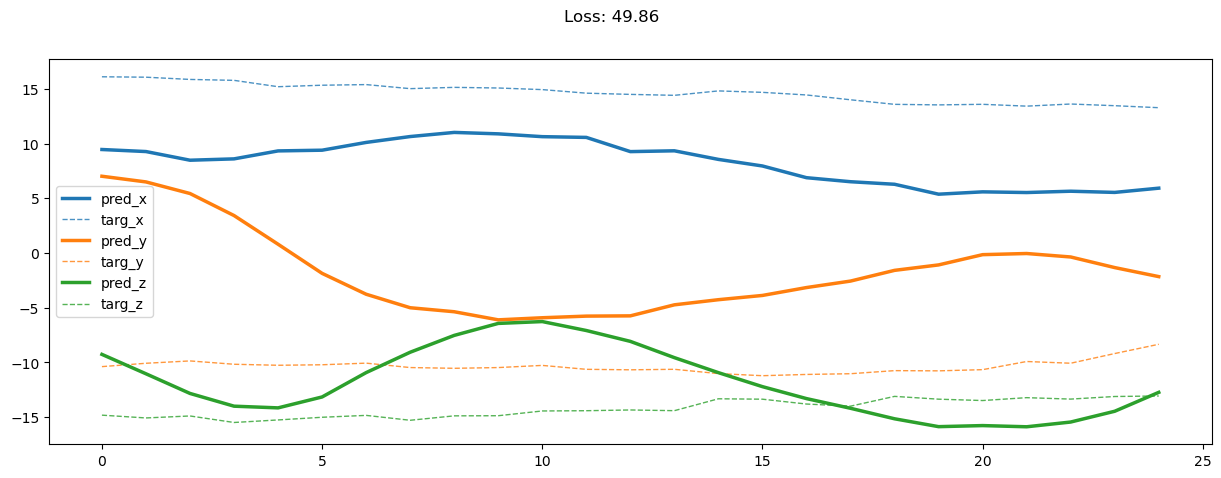

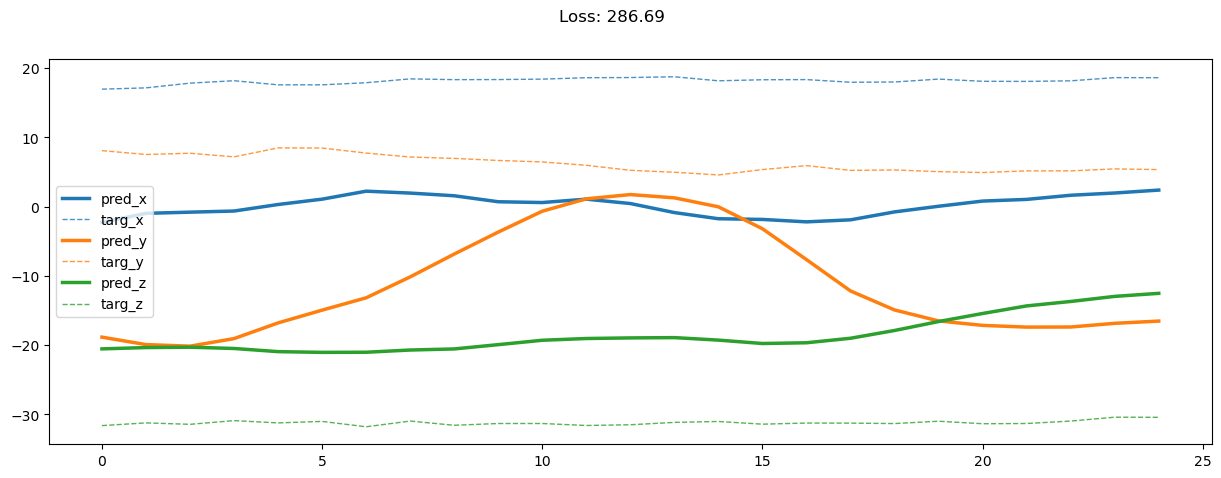

01159: train loss:  33.405, imu loss:  0.697, mag loss:  32.708, div loss:  64.880
       valid loss:  331.537, imu loss:  0.430, mag loss:  331.107, div loss:  239.811
01179: train loss:  33.171, imu loss:  0.700, mag loss:  32.472, div loss:  64.584
       valid loss:  335.436, imu loss:  0.430, mag loss:  335.007, div loss:  241.159


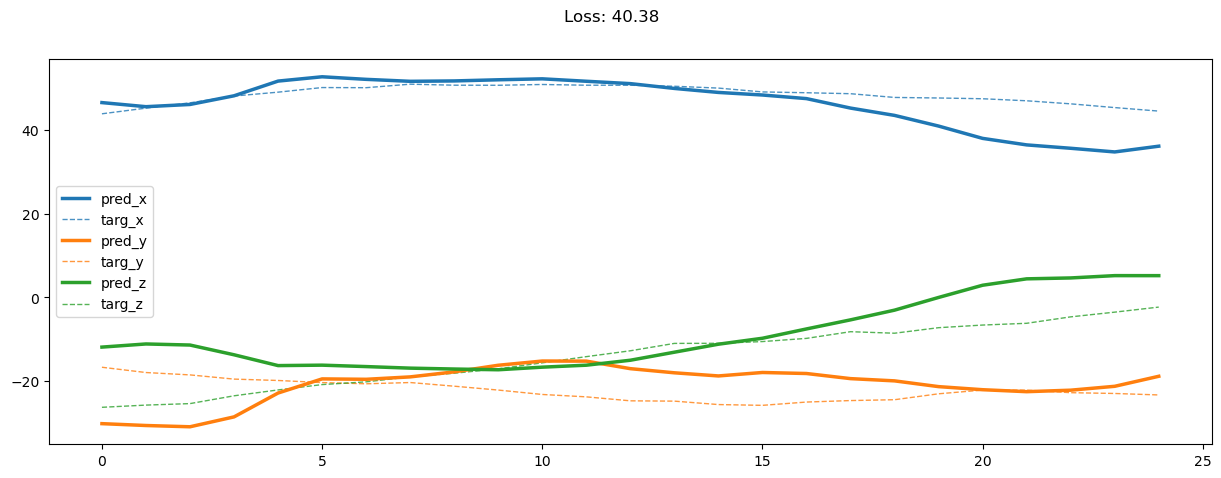

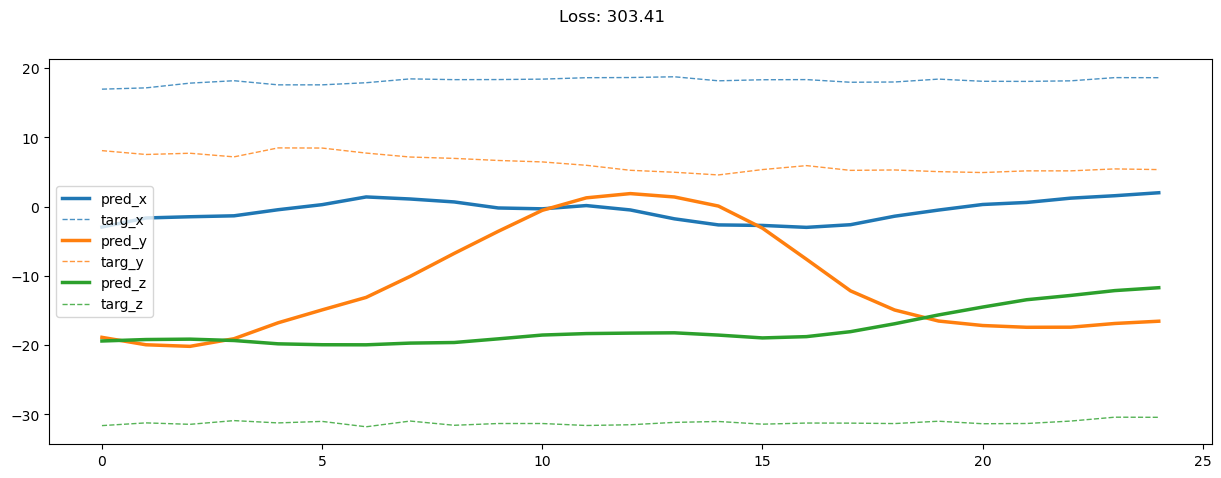

01199: train loss:  33.391, imu loss:  0.700, mag loss:  32.691, div loss:  64.871
       valid loss:  339.390, imu loss:  0.430, mag loss:  338.960, div loss:  240.780
01219: train loss:  33.192, imu loss:  0.699, mag loss:  32.493, div loss:  64.117
       valid loss:  335.293, imu loss:  0.430, mag loss:  334.863, div loss:  241.700
01239: train loss:  33.222, imu loss:  0.704, mag loss:  32.518, div loss:  64.252
       valid loss:  334.205, imu loss:  0.430, mag loss:  333.775, div loss:  241.364


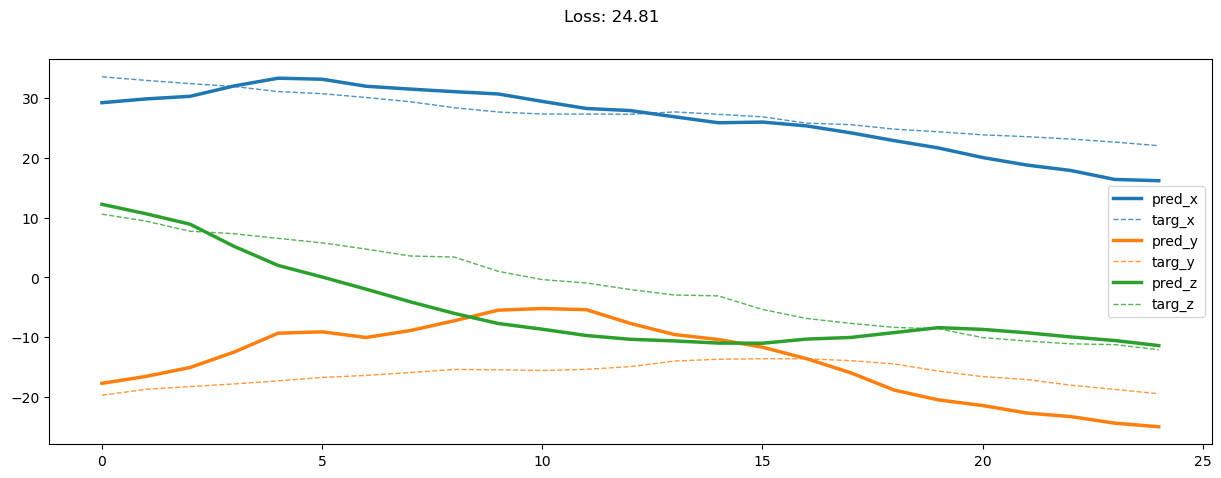

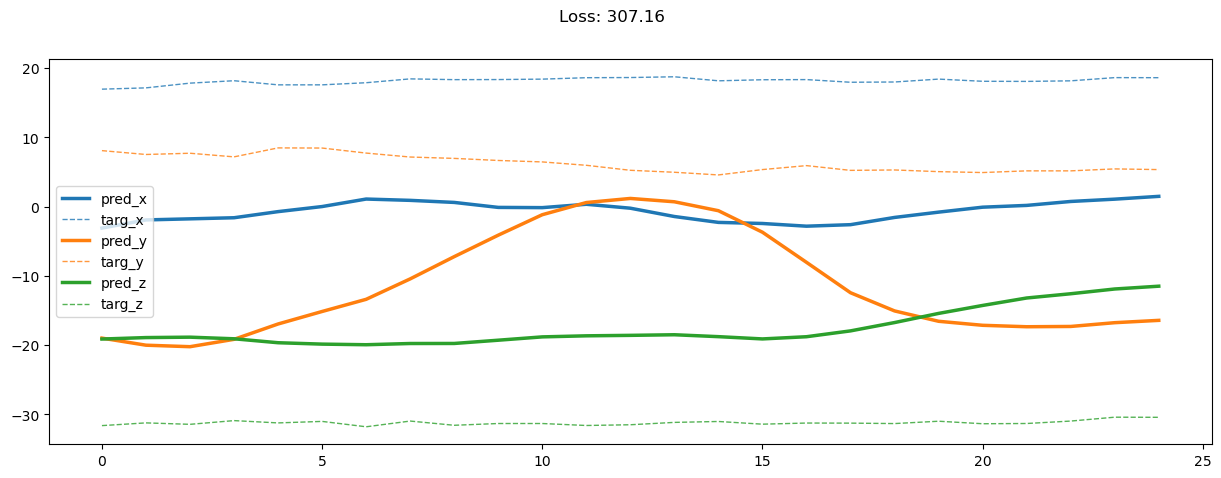

01259: train loss:  33.006, imu loss:  0.699, mag loss:  32.307, div loss:  64.177
       valid loss:  339.033, imu loss:  0.430, mag loss:  338.603, div loss:  240.760
01279: train loss:  32.335, imu loss:  0.698, mag loss:  31.637, div loss:  62.605
       valid loss:  333.629, imu loss:  0.430, mag loss:  333.199, div loss:  242.301


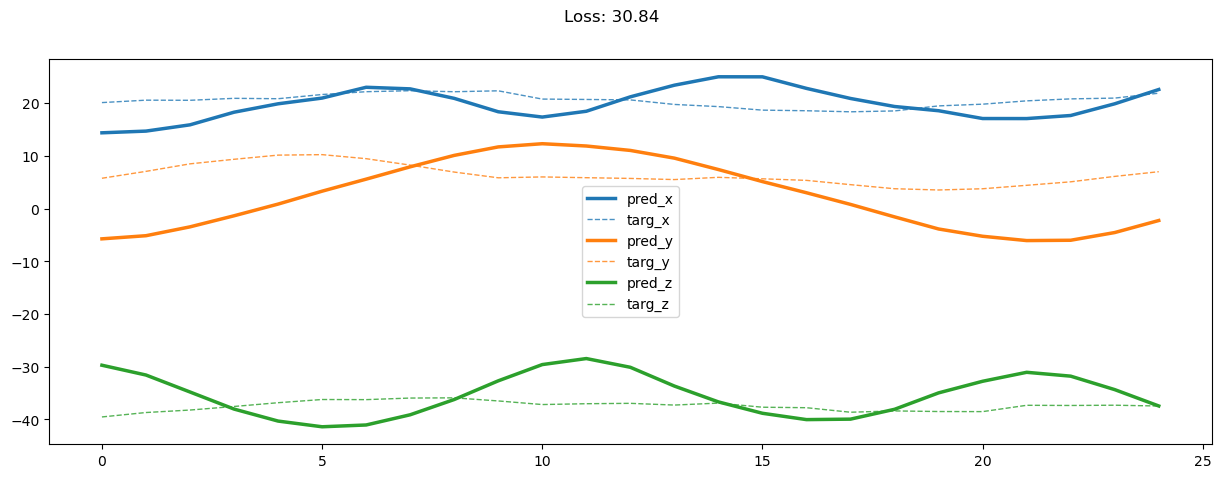

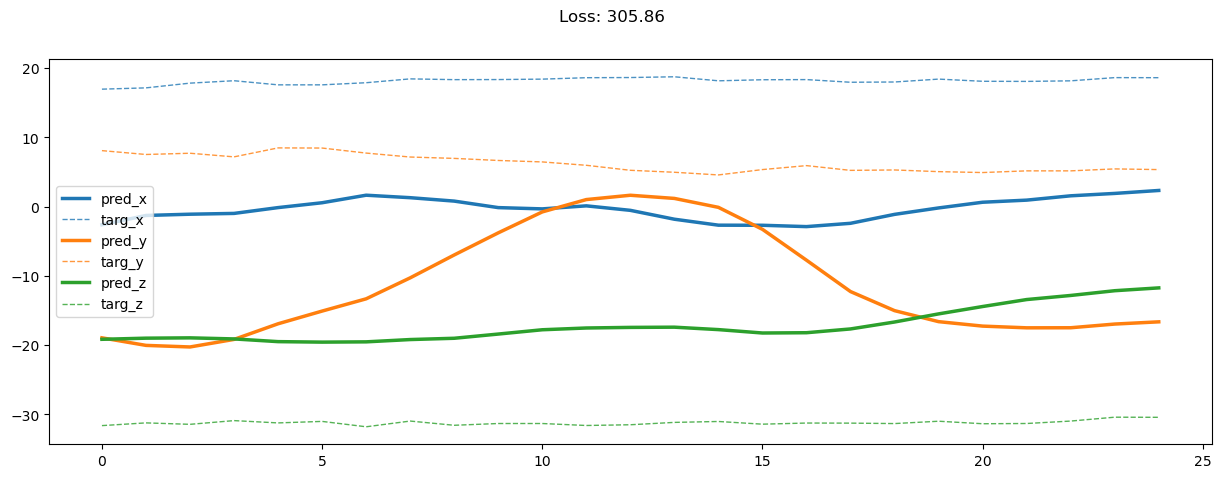

01299: train loss:  32.468, imu loss:  0.699, mag loss:  31.769, div loss:  62.981
       valid loss:  337.716, imu loss:  0.430, mag loss:  337.286, div loss:  242.101
01319: train loss:  32.536, imu loss:  0.700, mag loss:  31.837, div loss:  63.068
       valid loss:  339.069, imu loss:  0.430, mag loss:  338.639, div loss:  241.889
01339: train loss:  32.454, imu loss:  0.700, mag loss:  31.754, div loss:  62.866
       valid loss:  336.255, imu loss:  0.430, mag loss:  335.825, div loss:  241.801


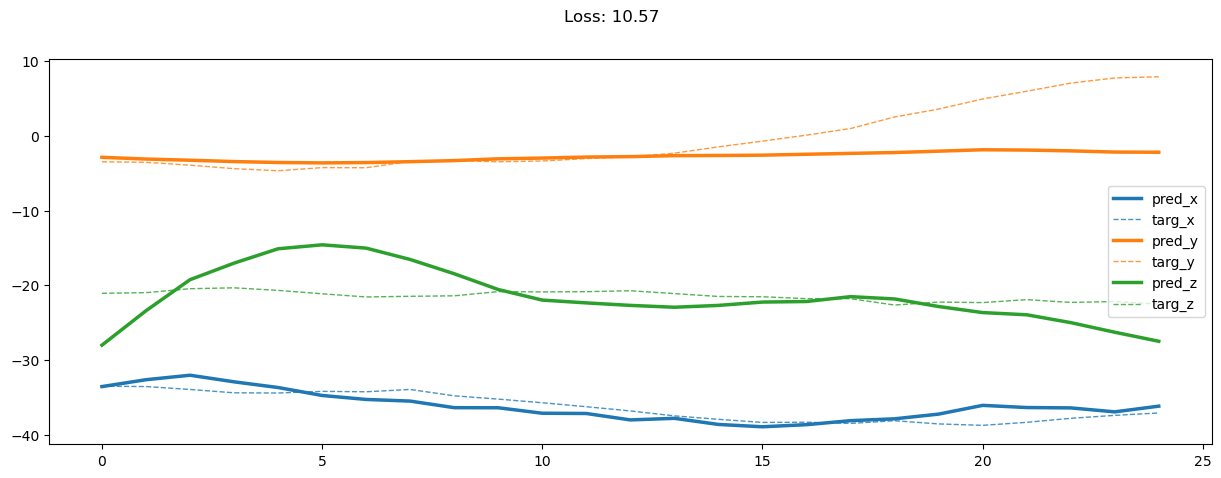

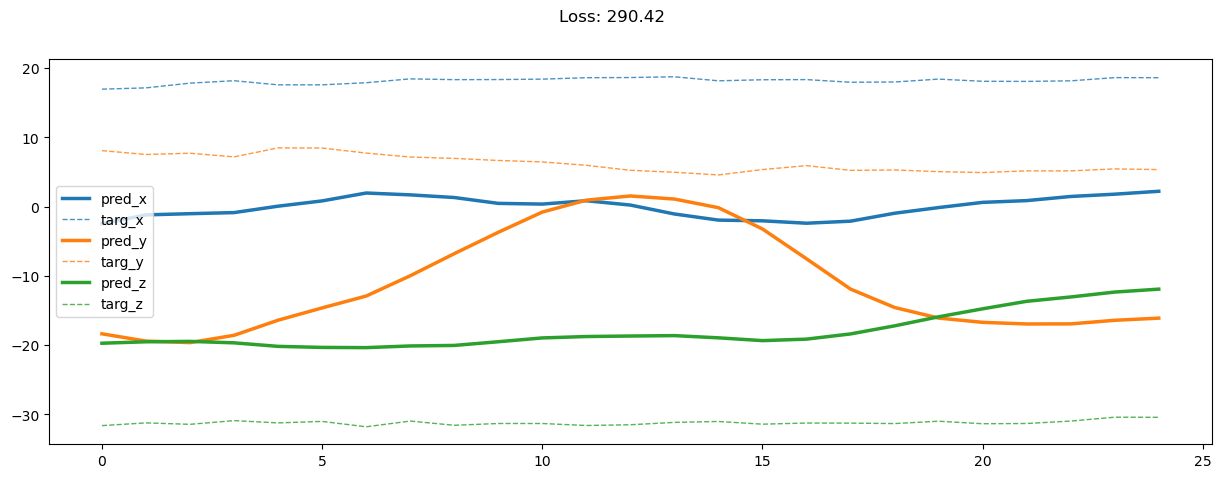

01359: train loss:  32.163, imu loss:  0.700, mag loss:  31.463, div loss:  62.211
       valid loss:  336.175, imu loss:  0.430, mag loss:  335.745, div loss:  243.823
01379: train loss:  32.261, imu loss:  0.699, mag loss:  31.562, div loss:  62.563
       valid loss:  338.464, imu loss:  0.430, mag loss:  338.034, div loss:  243.740


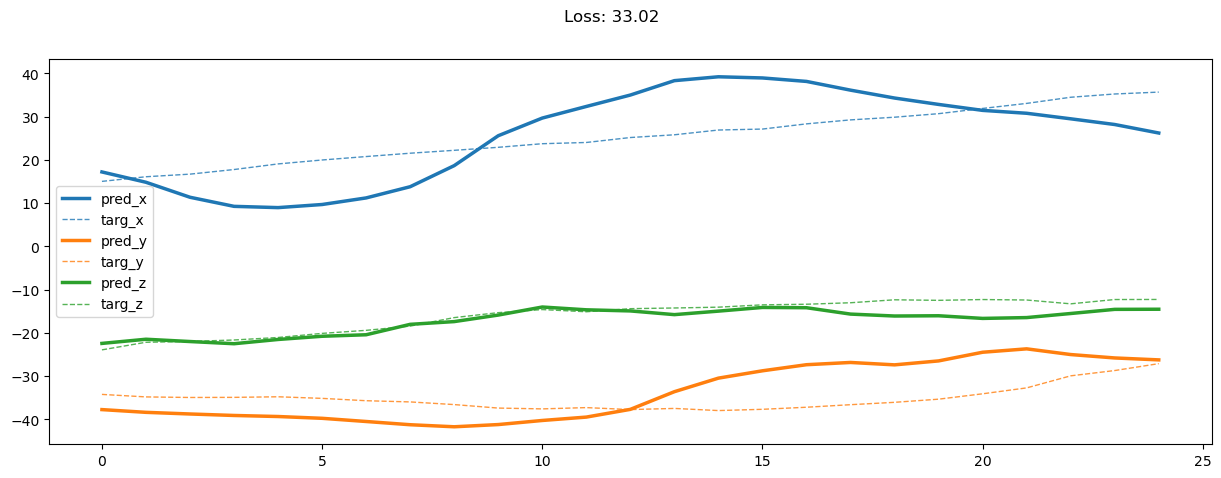

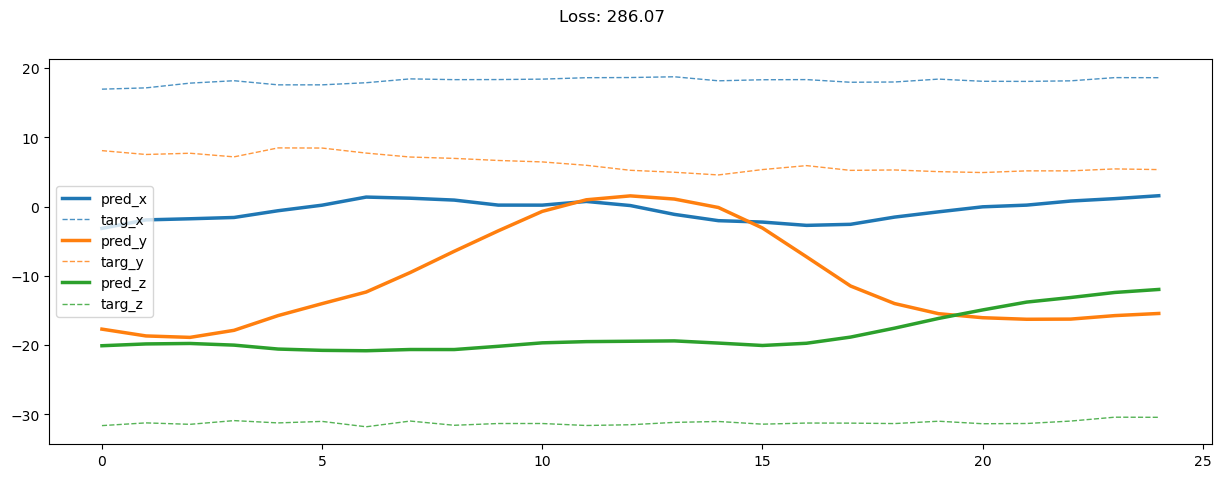

01399: train loss:  32.334, imu loss:  0.698, mag loss:  31.636, div loss:  62.537
       valid loss:  337.626, imu loss:  0.430, mag loss:  337.196, div loss:  243.080
01419: train loss:  31.625, imu loss:  0.701, mag loss:  30.923, div loss:  61.640
       valid loss:  340.973, imu loss:  0.430, mag loss:  340.543, div loss:  244.224
01439: train loss:  31.673, imu loss:  0.700, mag loss:  30.973, div loss:  61.350
       valid loss:  338.854, imu loss:  0.430, mag loss:  338.424, div loss:  244.145


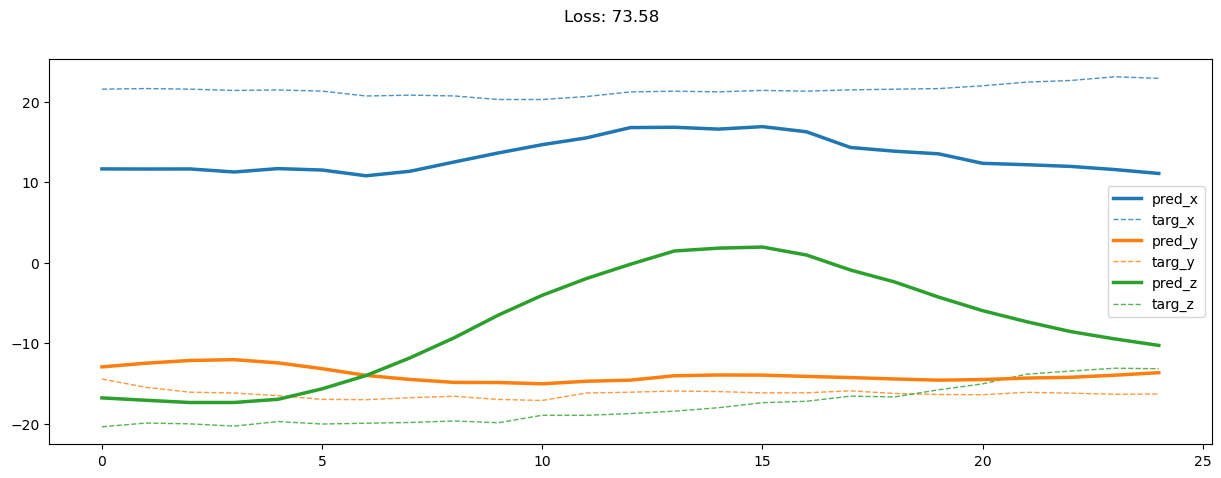

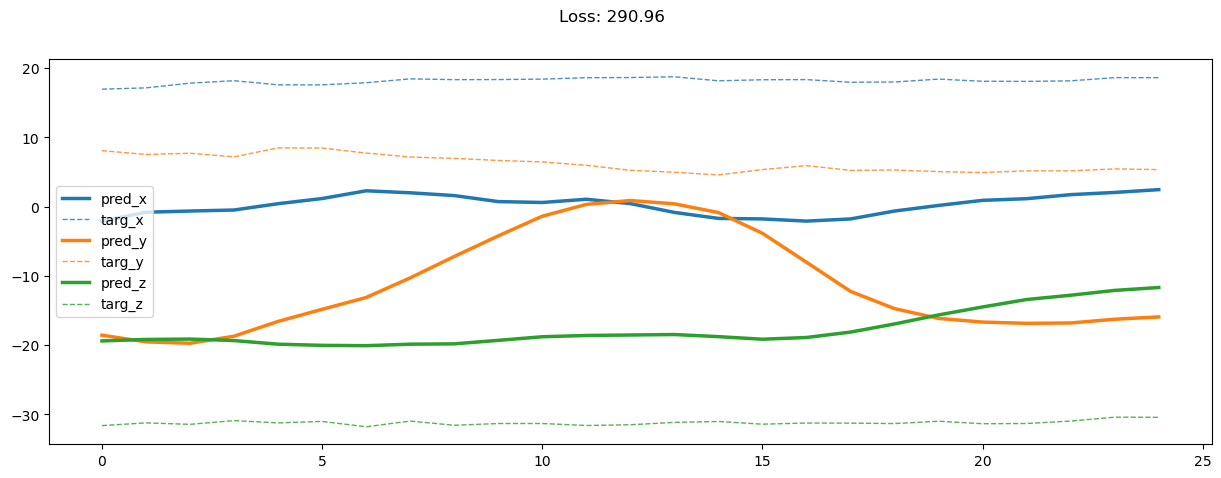

01459: train loss:  31.513, imu loss:  0.698, mag loss:  30.815, div loss:  61.345
       valid loss:  337.213, imu loss:  0.430, mag loss:  336.783, div loss:  243.349
01479: train loss:  31.188, imu loss:  0.699, mag loss:  30.489, div loss:  60.385
       valid loss:  340.349, imu loss:  0.430, mag loss:  339.919, div loss:  243.803


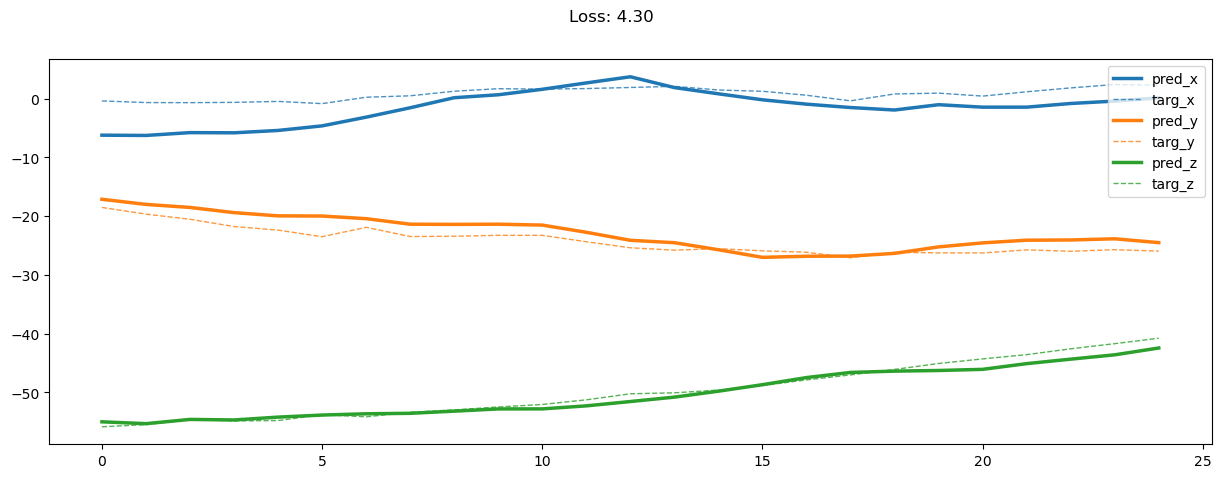

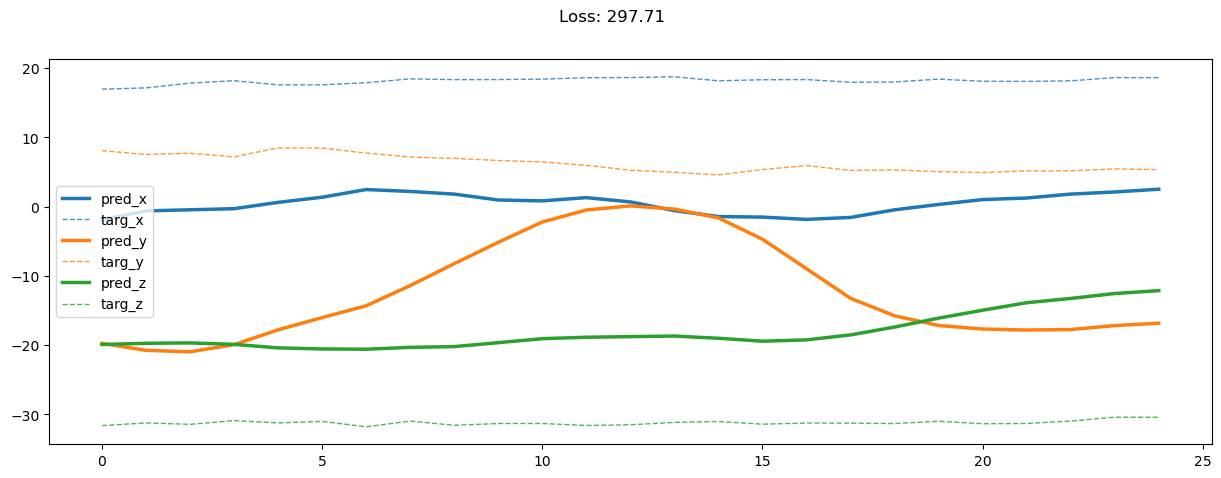

01499: train loss:  31.385, imu loss:  0.699, mag loss:  30.686, div loss:  60.880
       valid loss:  336.753, imu loss:  0.430, mag loss:  336.323, div loss:  243.346
01519: train loss:  31.135, imu loss:  0.702, mag loss:  30.434, div loss:  60.311
       valid loss:  338.880, imu loss:  0.430, mag loss:  338.450, div loss:  244.060
01539: train loss:  31.580, imu loss:  0.701, mag loss:  30.879, div loss:  61.109
       valid loss:  341.654, imu loss:  0.430, mag loss:  341.224, div loss:  244.775


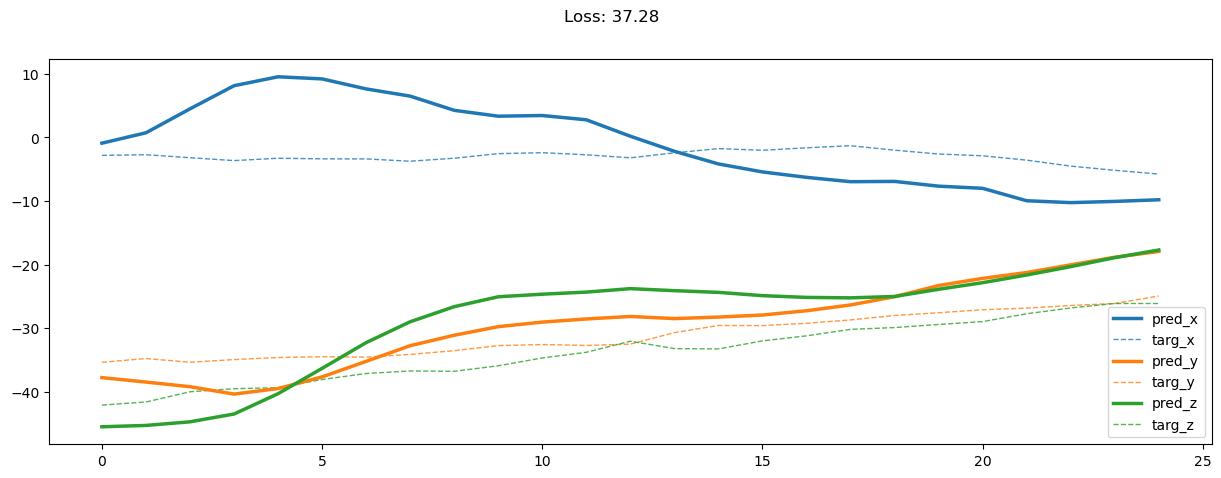

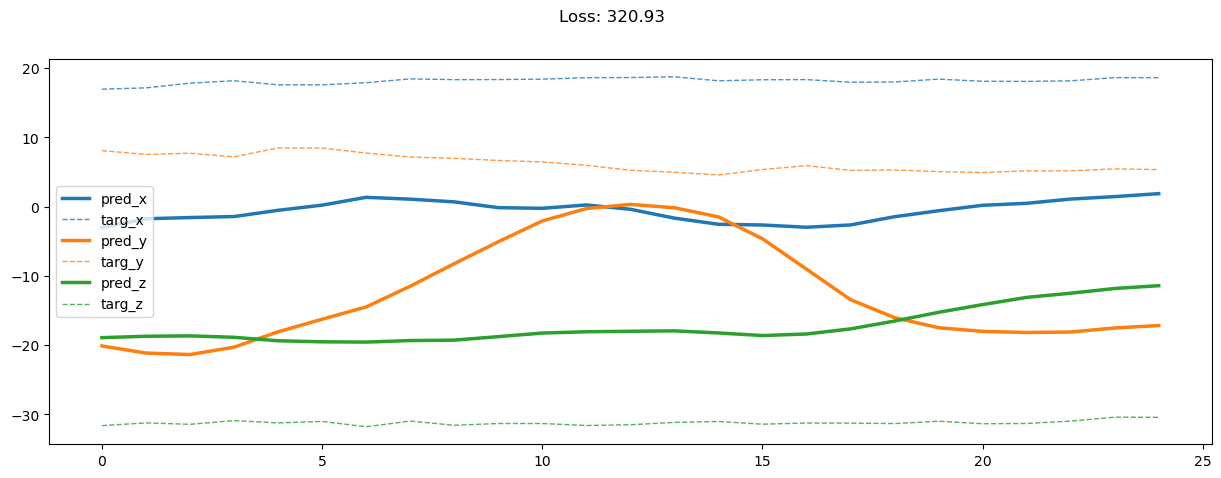

01559: train loss:  31.028, imu loss:  0.704, mag loss:  30.325, div loss:  60.045
       valid loss:  338.871, imu loss:  0.430, mag loss:  338.441, div loss:  245.041
01579: train loss:  30.869, imu loss:  0.699, mag loss:  30.170, div loss:  59.680
       valid loss:  339.323, imu loss:  0.430, mag loss:  338.893, div loss:  246.564


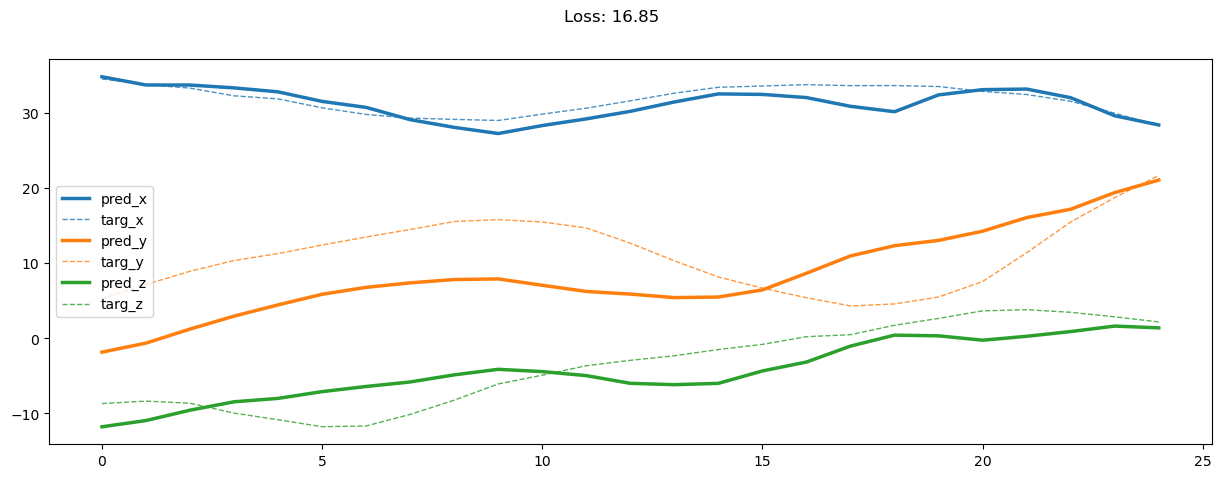

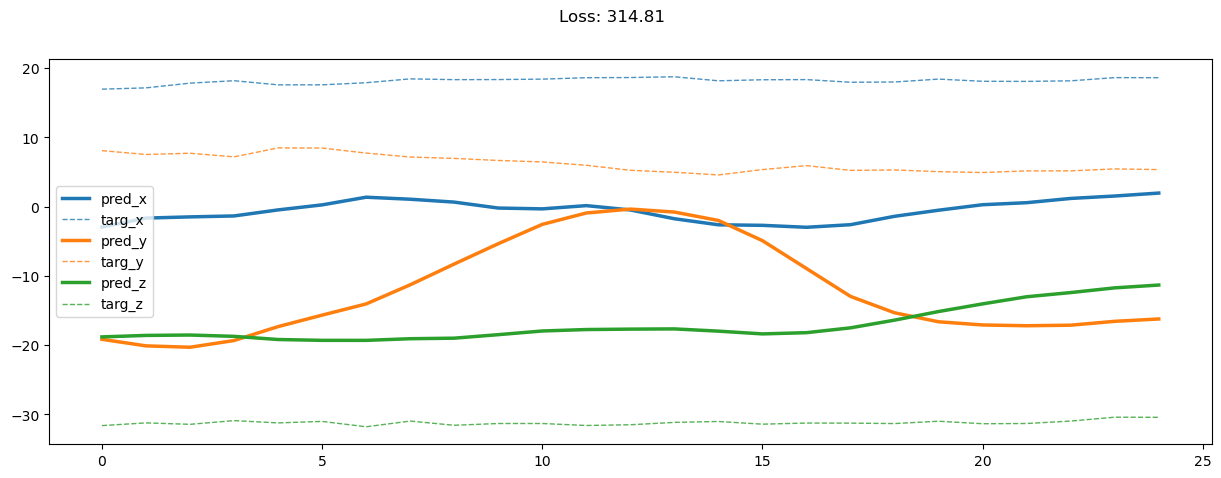

01599: train loss:  31.001, imu loss:  0.700, mag loss:  30.301, div loss:  59.890
       valid loss:  341.568, imu loss:  0.430, mag loss:  341.138, div loss:  247.057
01619: train loss:  30.942, imu loss:  0.700, mag loss:  30.242, div loss:  59.732
       valid loss:  341.208, imu loss:  0.430, mag loss:  340.779, div loss:  245.590
01639: train loss:  30.587, imu loss:  0.699, mag loss:  29.888, div loss:  59.371
       valid loss:  342.856, imu loss:  0.430, mag loss:  342.427, div loss:  244.750


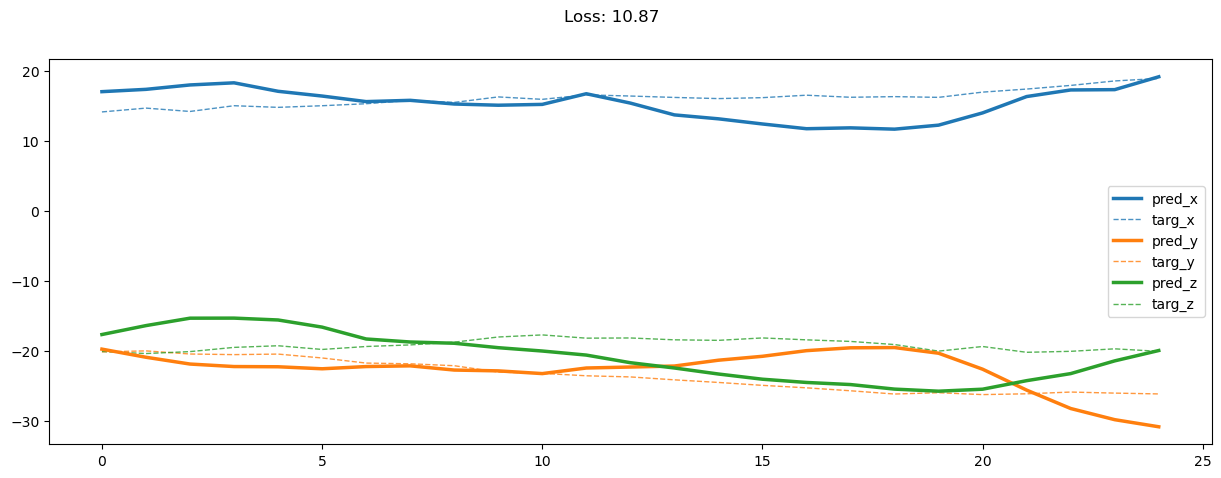

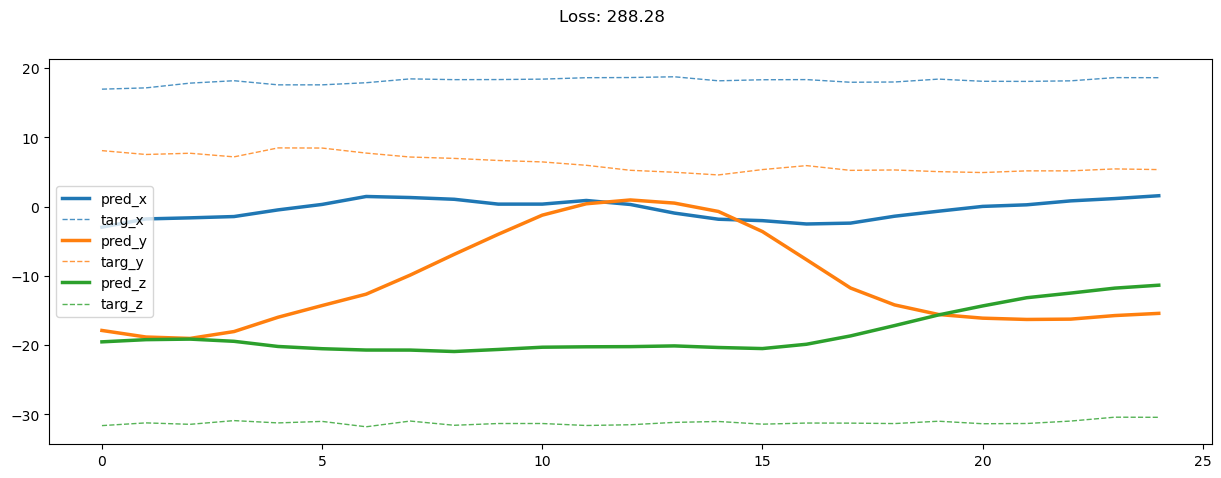

01659: train loss:  30.738, imu loss:  0.700, mag loss:  30.038, div loss:  59.701
       valid loss:  342.314, imu loss:  0.430, mag loss:  341.884, div loss:  246.525
01679: train loss:  30.378, imu loss:  0.700, mag loss:  29.678, div loss:  58.527
       valid loss:  344.705, imu loss:  0.430, mag loss:  344.275, div loss:  247.269


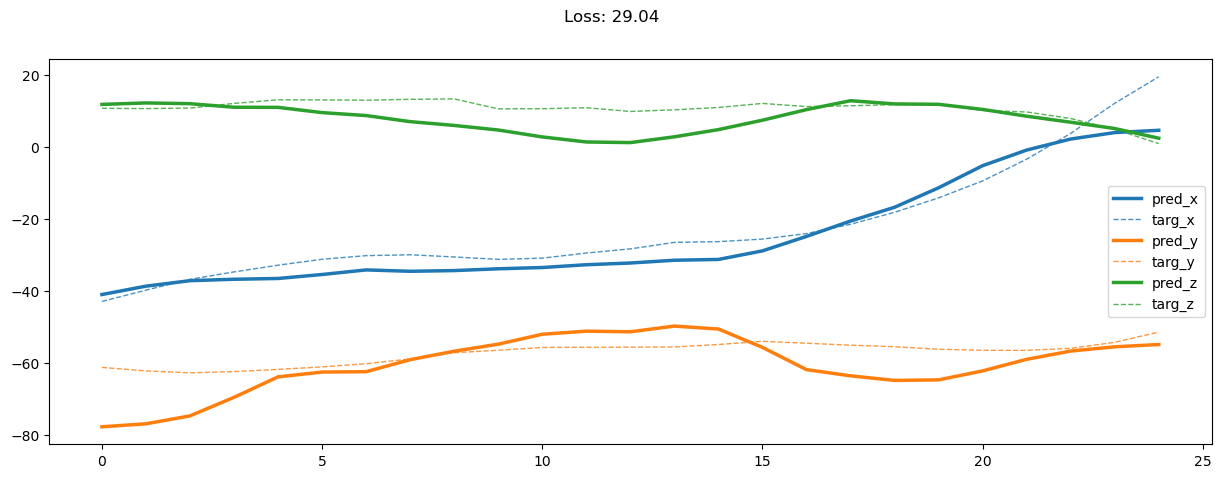

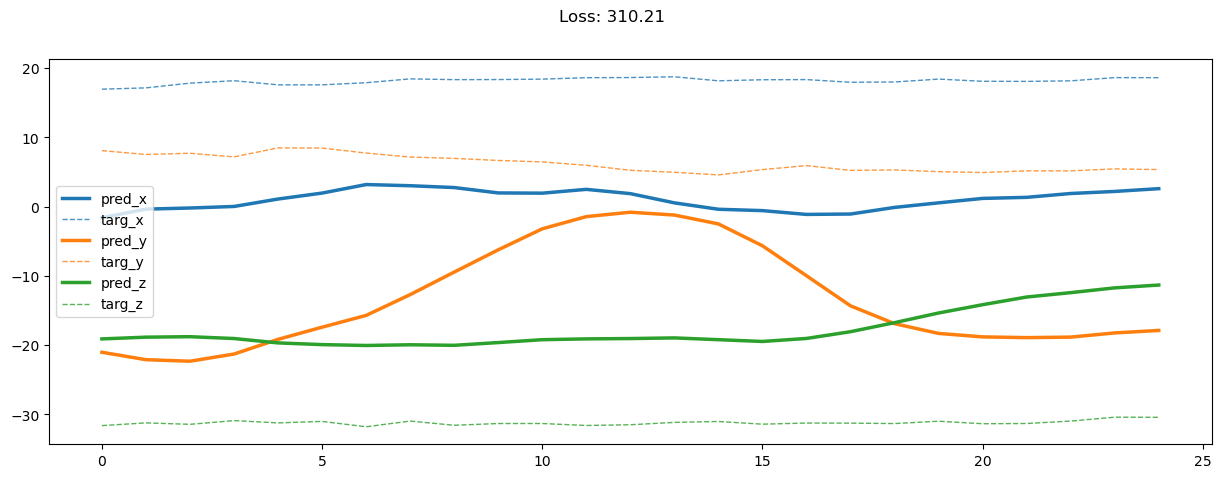

01699: train loss:  30.200, imu loss:  0.701, mag loss:  29.500, div loss:  58.314
       valid loss:  340.009, imu loss:  0.430, mag loss:  339.579, div loss:  247.134
01719: train loss:  30.166, imu loss:  0.700, mag loss:  29.466, div loss:  58.432
       valid loss:  347.141, imu loss:  0.430, mag loss:  346.711, div loss:  249.391
01739: train loss:  30.215, imu loss:  0.698, mag loss:  29.517, div loss:  58.689
       valid loss:  344.527, imu loss:  0.430, mag loss:  344.098, div loss:  247.505


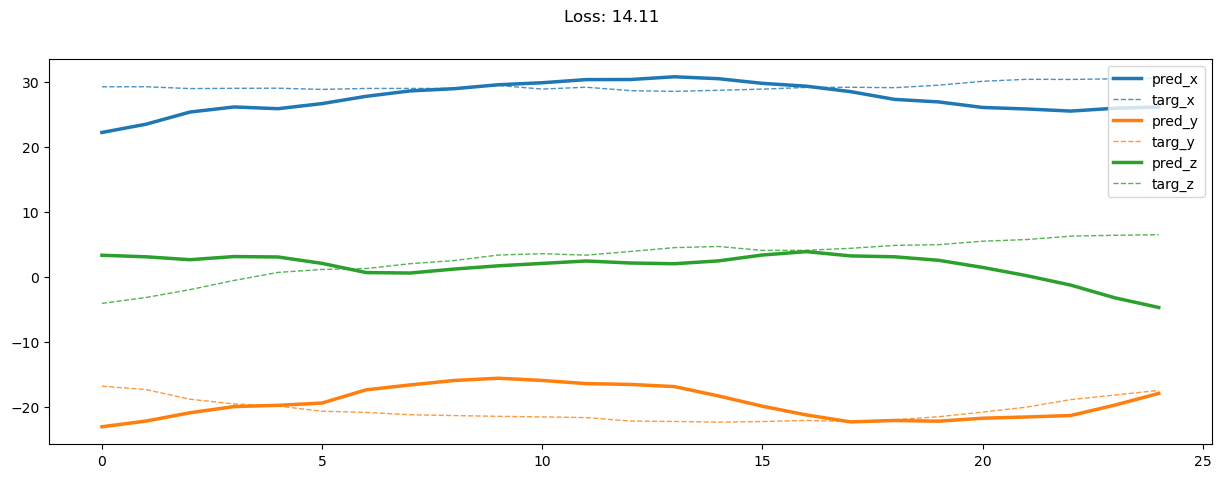

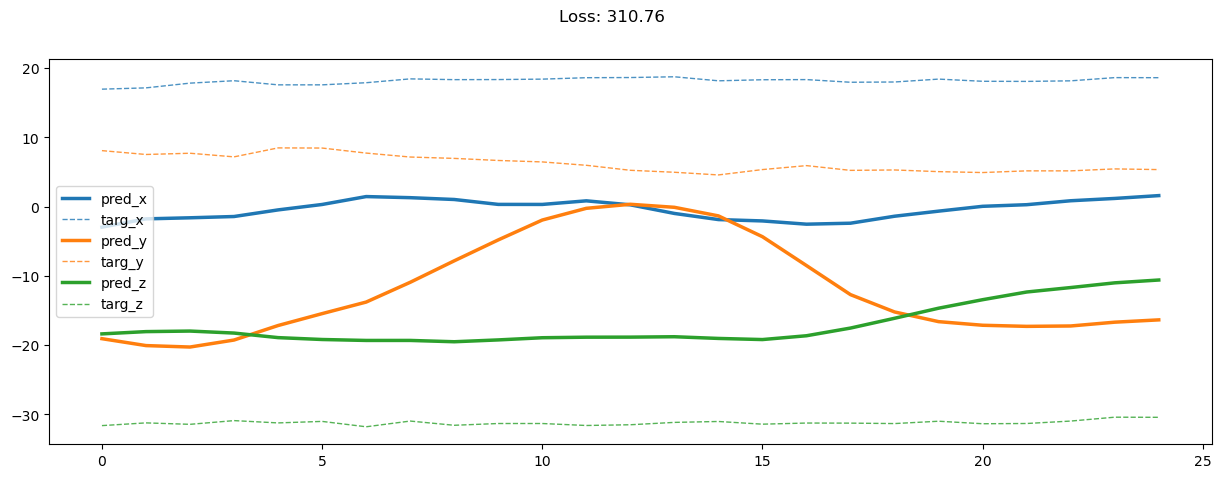

01759: train loss:  29.888, imu loss:  0.699, mag loss:  29.189, div loss:  57.612
       valid loss:  340.845, imu loss:  0.430, mag loss:  340.415, div loss:  245.400
01779: train loss:  30.161, imu loss:  0.699, mag loss:  29.462, div loss:  58.487
       valid loss:  339.524, imu loss:  0.430, mag loss:  339.094, div loss:  245.552


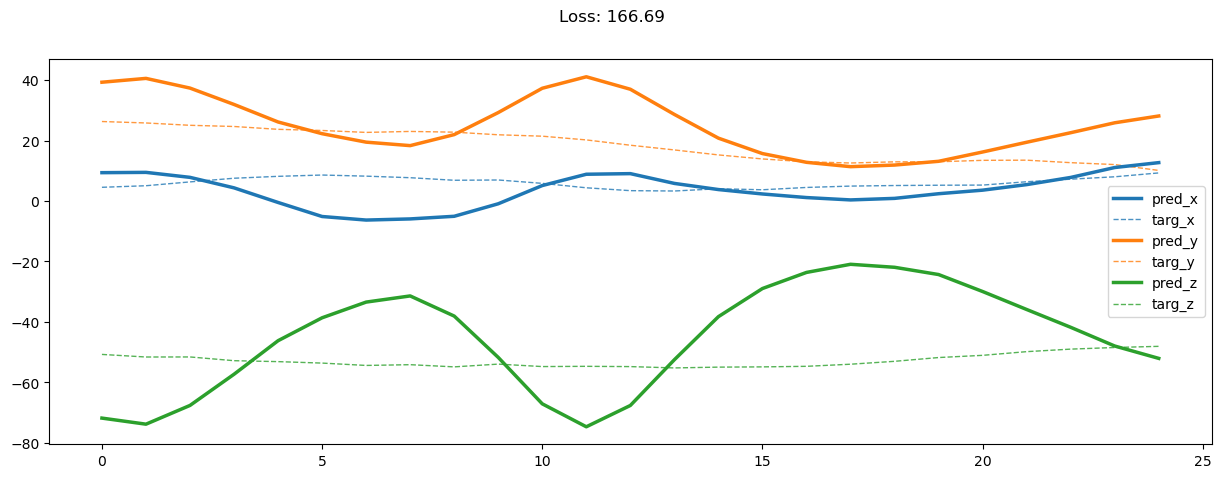

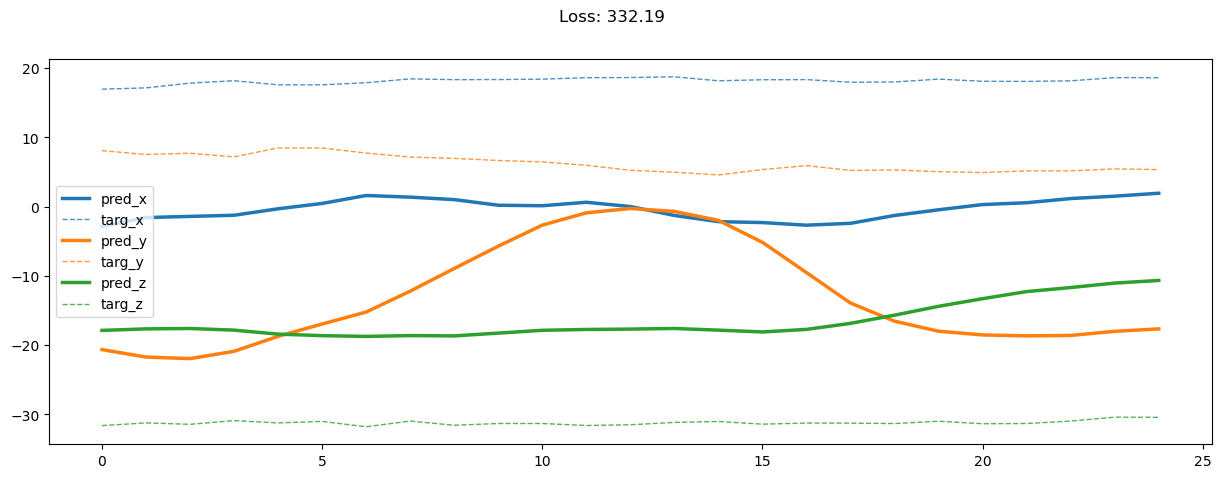

01799: train loss:  29.752, imu loss:  0.697, mag loss:  29.055, div loss:  57.670
       valid loss:  345.631, imu loss:  0.430, mag loss:  345.201, div loss:  246.230
01819: train loss:  29.643, imu loss:  0.701, mag loss:  28.942, div loss:  57.876
       valid loss:  348.325, imu loss:  0.430, mag loss:  347.895, div loss:  249.199
01839: train loss:  29.443, imu loss:  0.697, mag loss:  28.746, div loss:  57.125
       valid loss:  340.561, imu loss:  0.430, mag loss:  340.131, div loss:  246.676


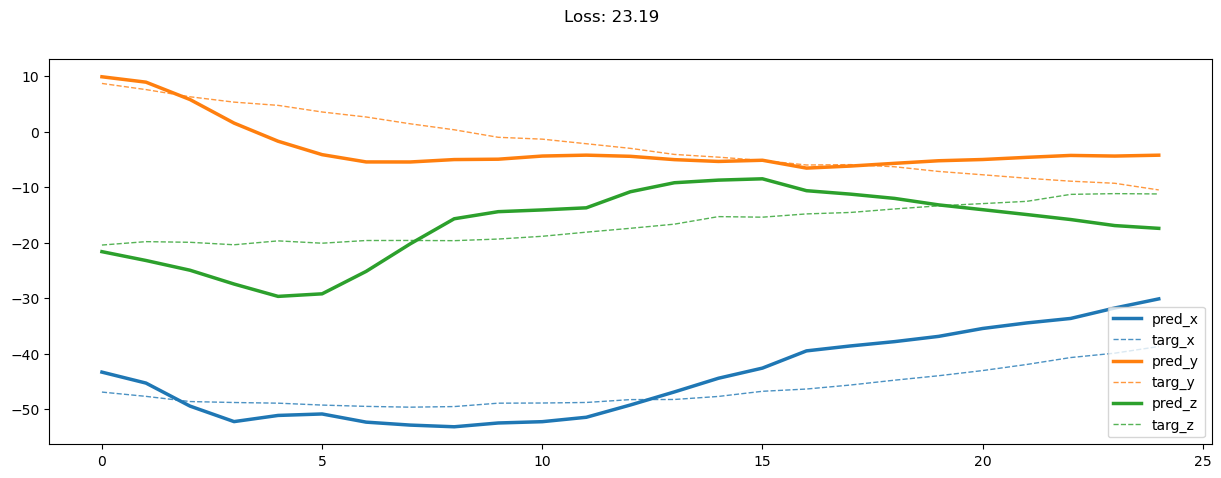

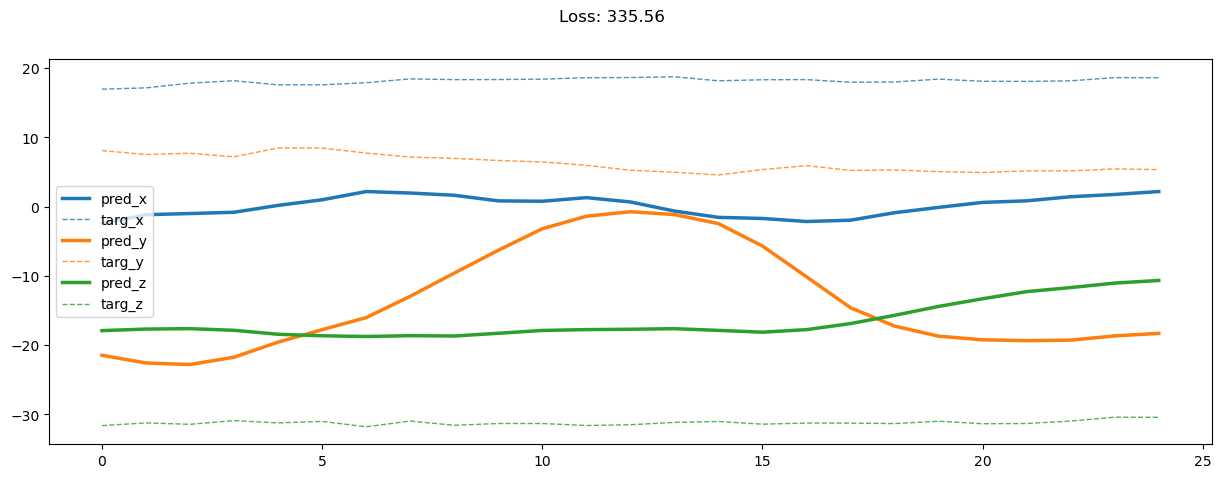

01859: train loss:  29.271, imu loss:  0.698, mag loss:  28.573, div loss:  56.477
       valid loss:  339.476, imu loss:  0.430, mag loss:  339.046, div loss:  246.523
01879: train loss:  29.568, imu loss:  0.699, mag loss:  28.869, div loss:  57.509
       valid loss:  349.039, imu loss:  0.430, mag loss:  348.609, div loss:  249.665


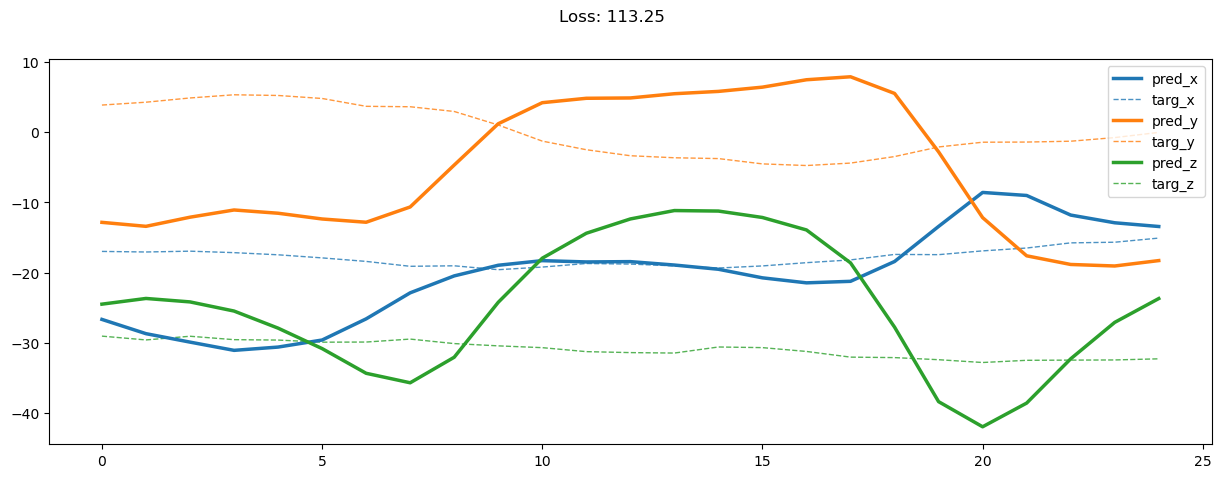

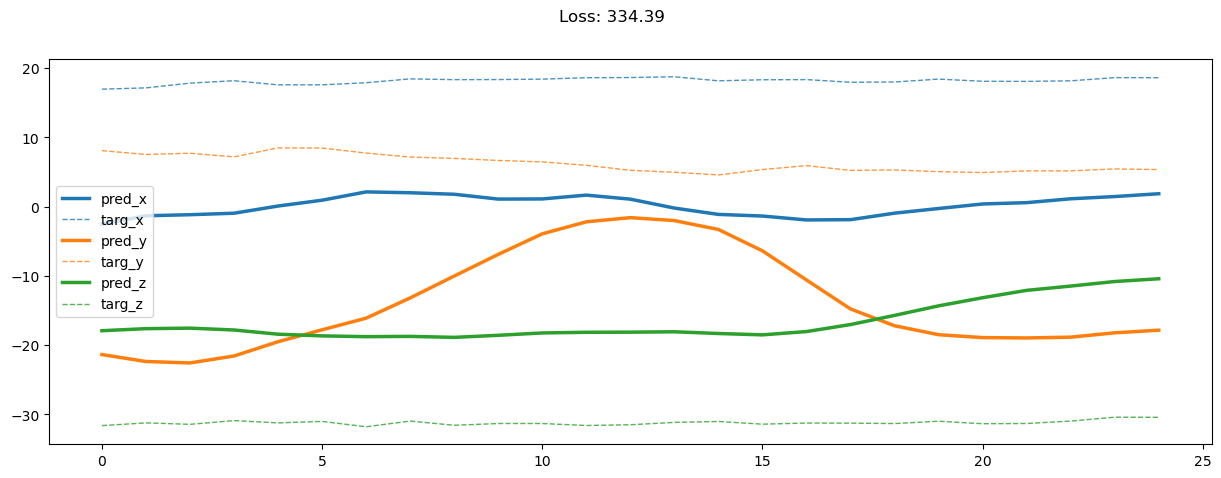

01899: train loss:  29.258, imu loss:  0.698, mag loss:  28.559, div loss:  56.559
       valid loss:  343.526, imu loss:  0.430, mag loss:  343.096, div loss:  249.210
01919: train loss:  29.190, imu loss:  0.701, mag loss:  28.489, div loss:  56.368
       valid loss:  343.058, imu loss:  0.430, mag loss:  342.629, div loss:  248.201
01939: train loss:  29.323, imu loss:  0.701, mag loss:  28.622, div loss:  57.038
       valid loss:  345.365, imu loss:  0.430, mag loss:  344.935, div loss:  249.898


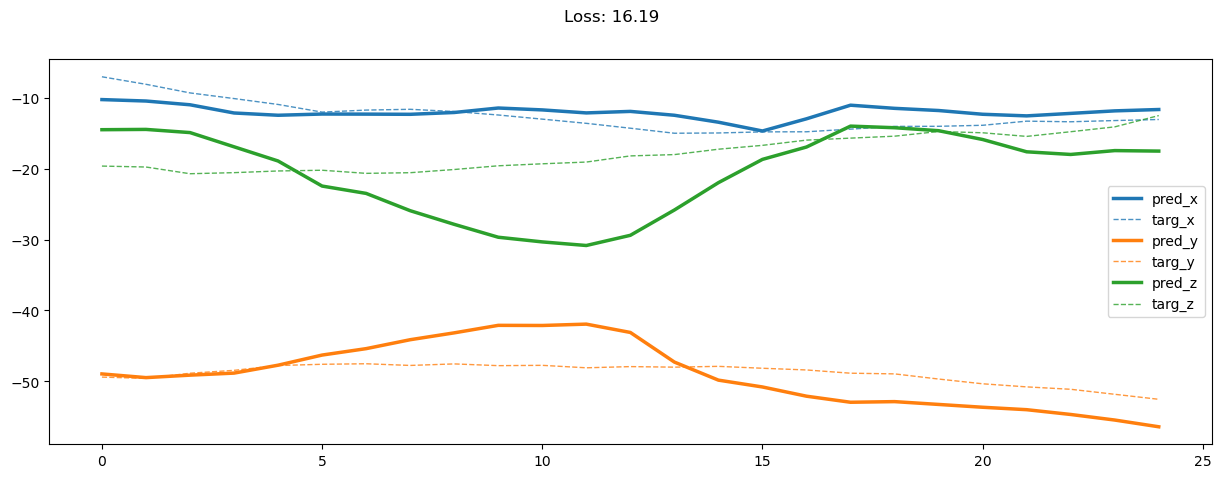

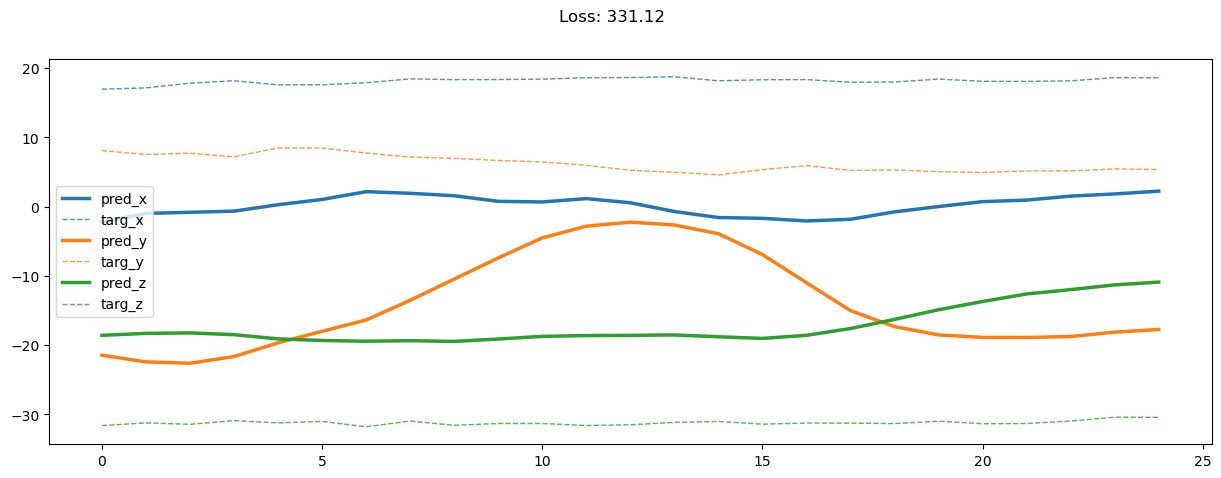

01959: train loss:  28.973, imu loss:  0.699, mag loss:  28.274, div loss:  56.094
       valid loss:  346.373, imu loss:  0.430, mag loss:  345.944, div loss:  250.417
01979: train loss:  29.083, imu loss:  0.696, mag loss:  28.386, div loss:  56.223
       valid loss:  347.289, imu loss:  0.430, mag loss:  346.859, div loss:  249.875


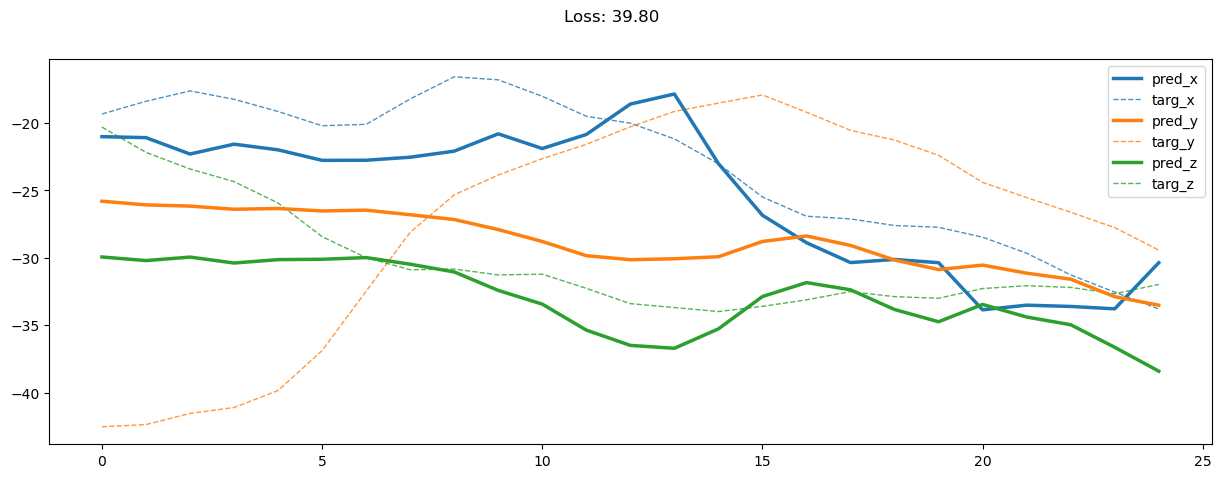

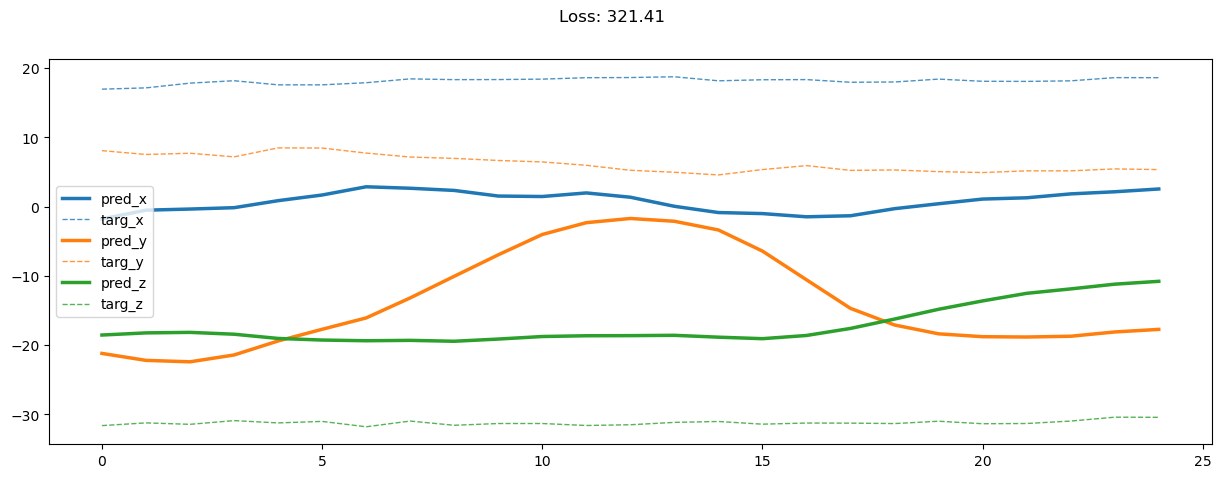

01999: train loss:  28.741, imu loss:  0.699, mag loss:  28.041, div loss:  55.453
       valid loss:  349.752, imu loss:  0.430, mag loss:  349.322, div loss:  249.859


In [52]:
draw = False

for epoch in range(EPOCH):
    
    if (epoch + 1) % 50 == 0:
        draw = True
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss = train(train_loader, draw)
    valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss = evalute(valid_loader, draw)
    
    draw = False
    
    if (epoch + 1) % 20 == 0:
        ep = str(epoch).zfill(5)
        print(f'{ep:>5}: train loss: {train_loss: 2.3f}, imu loss: {train_imu_loss: 2.3f}, mag loss: {train_mag_loss: 2.3f}, div loss: {t_d1_loss: 2.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss: 2.3f}, imu loss: {valid_imu_loss: 2.3f}, mag loss: {valid_mag_loss: 2.3f}, div loss: {v_d1_loss: 2.3f}')

In [42]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :6]
            source_mag = source_data[:, :, 6:9]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :6]
            target_mag = target_data[:, :, 6:9]
            
            class_result = classifier.predict_label(source_imu)

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag, class_result)
            

            # generator loss
#             gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            predict_mag = predict_mag.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            
            results.extend(zip(predict_mag, target_mag, source_label))
            
            diff = np.power(predict_mag.reshape(len(predict_mag), -1, 3) - target_mag.reshape(len(target_mag), -1, 3), 2).mean(axis=1)
            class_results.extend(diff)
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [53]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    source_label = result[2]
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
#     for i in range(0, chunk_size+1):
#         plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'{classes[source_label]}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

(7896, 3) (7896,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:    23.14    16.22    13.91    17.76
         pocket loss:    18.23    19.85    15.56    17.88
          swing loss:    22.28    32.63    30.08    28.33
        average loss:    21.22    22.75    19.70    21.22


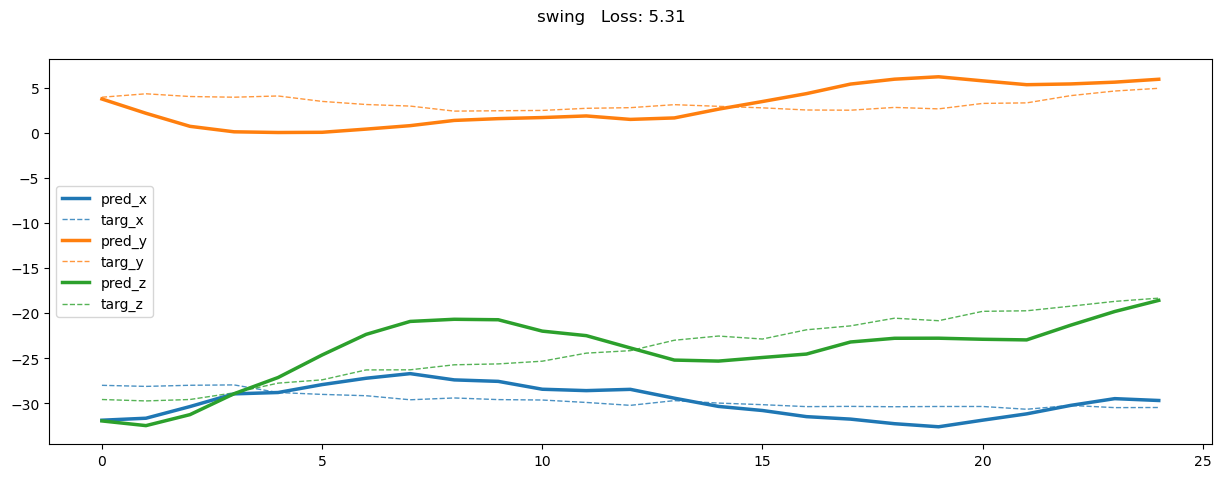

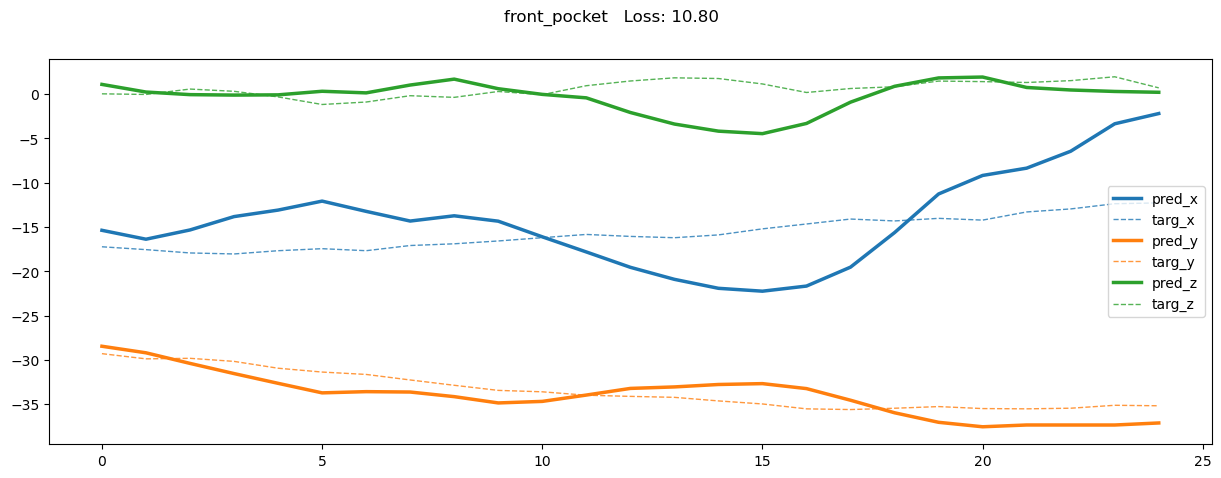

In [54]:
results, cres, clabel = output_eval(model, train_loader)
print(cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::5000]:
    plot_result(rs)

(1224, 3) (1224,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:    56.74    44.71    43.08    48.18
         pocket loss:   584.48   597.50   509.31   563.76
          swing loss:   217.25   417.22   506.06   380.18
        average loss:   272.57   338.07   339.50   316.71


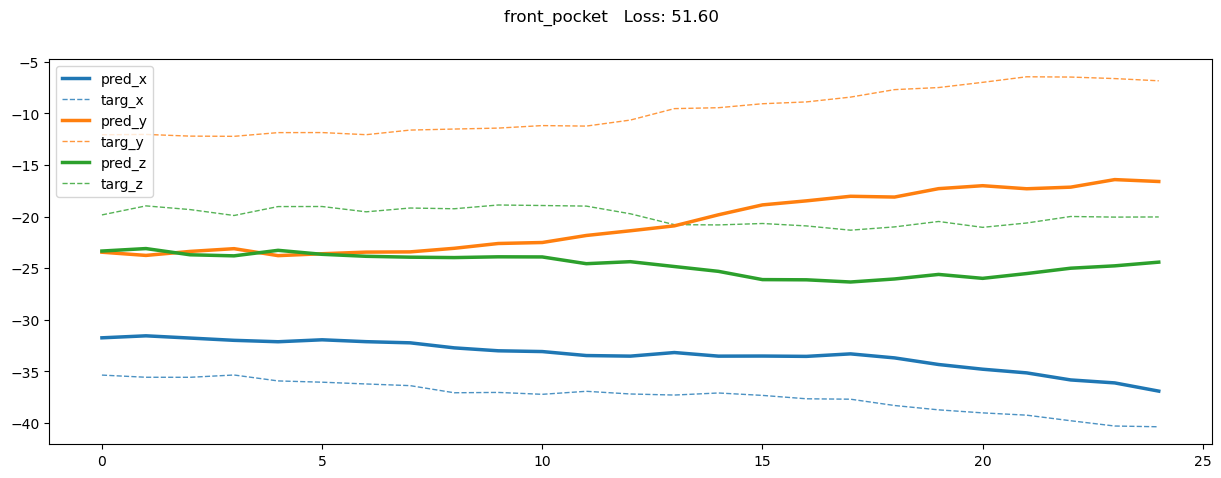

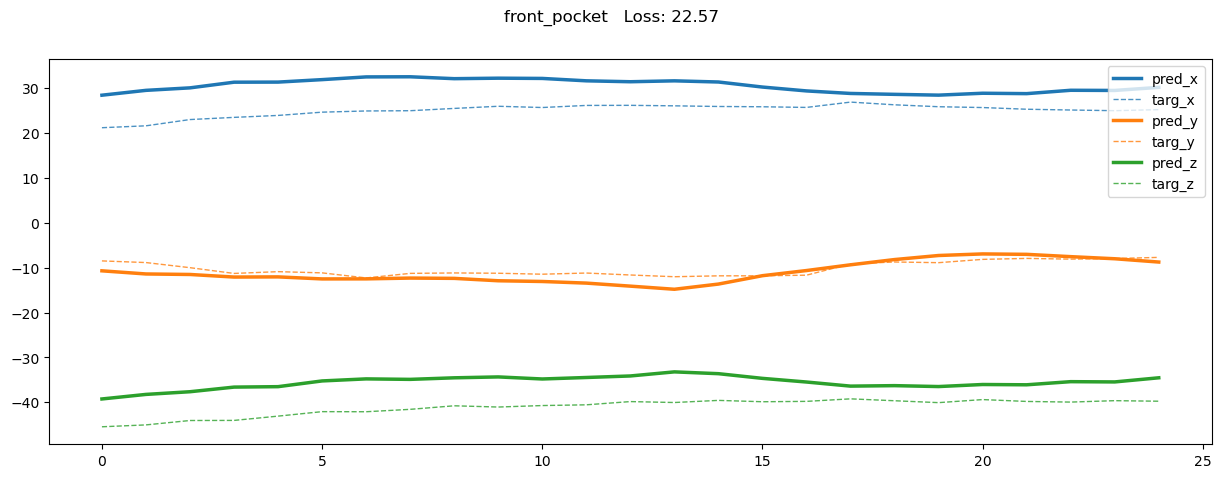

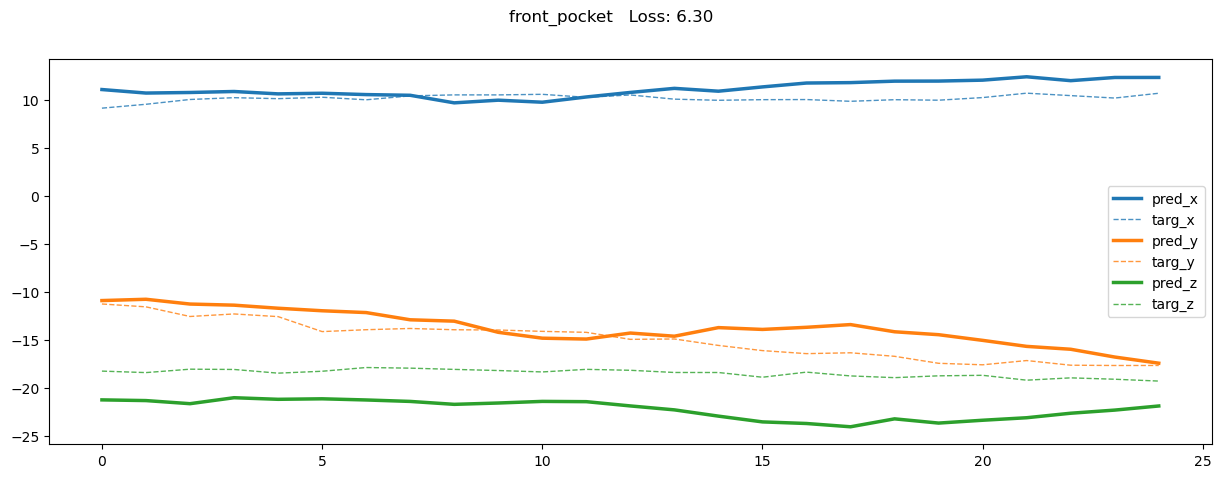

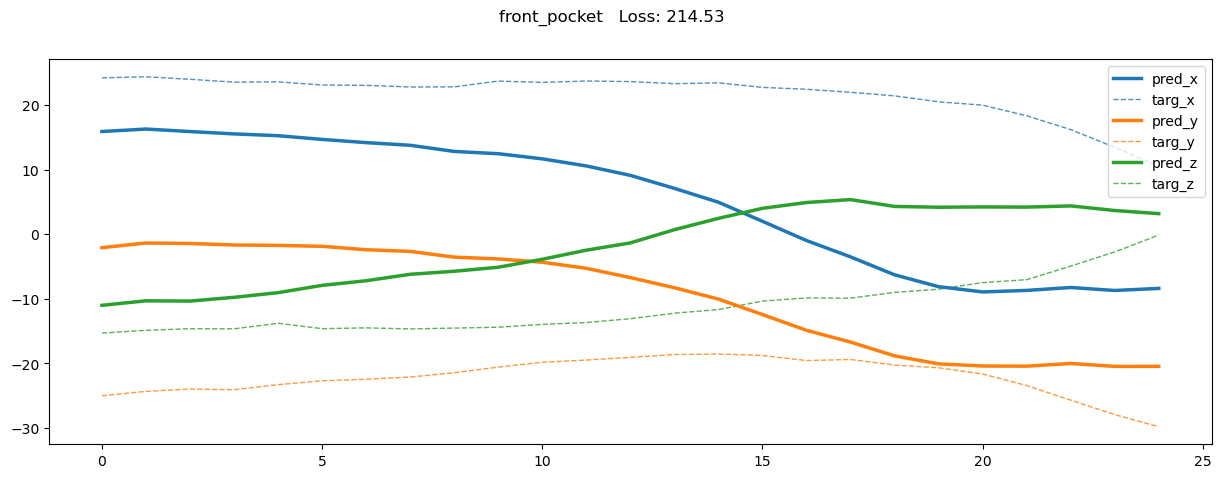

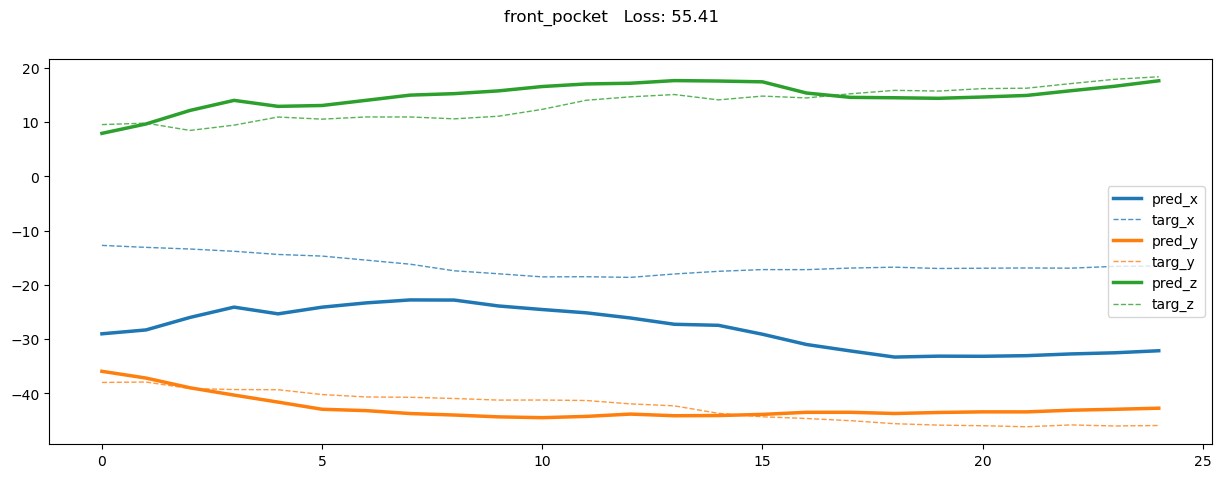

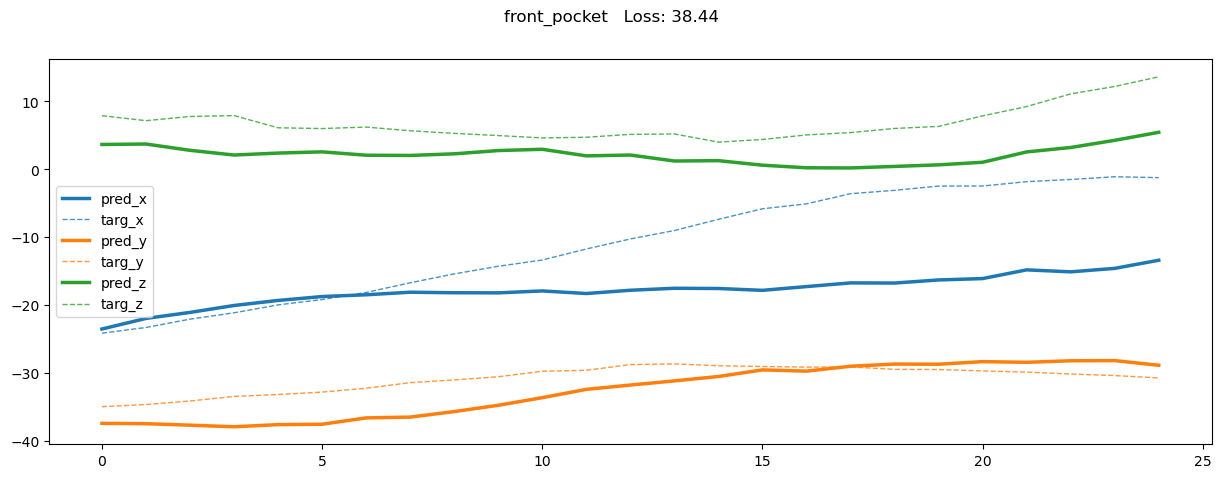

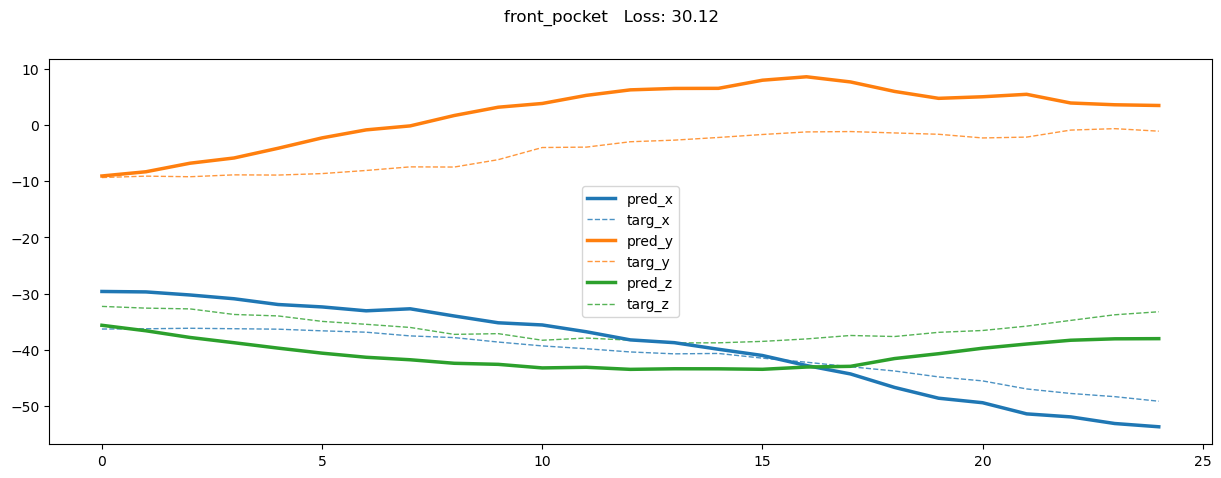

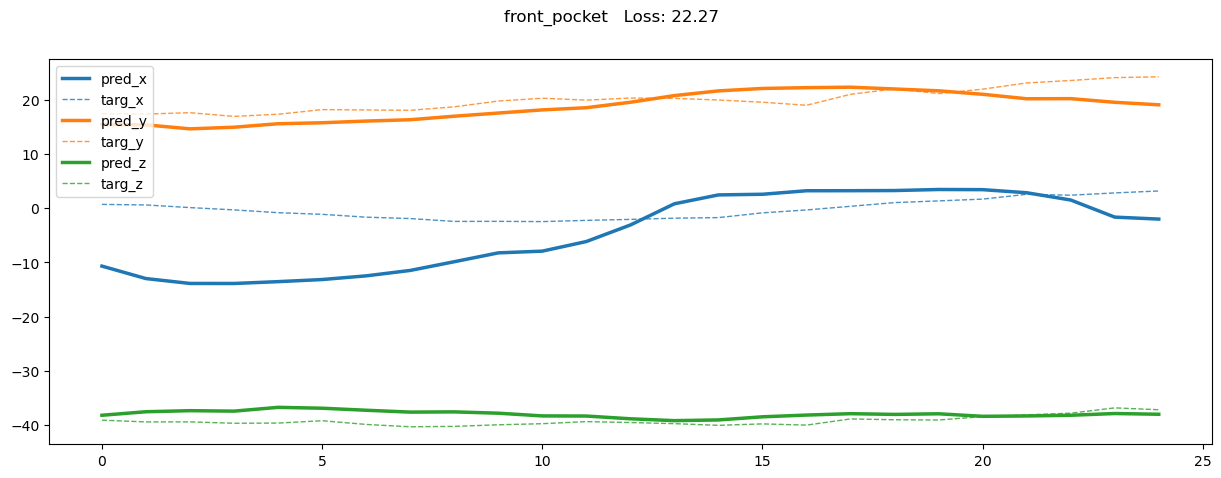

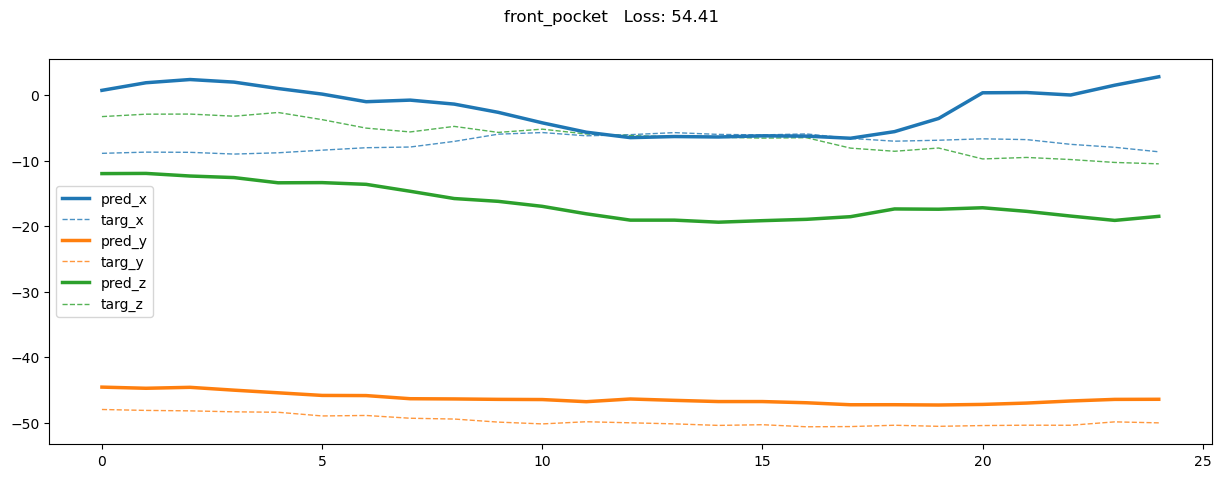

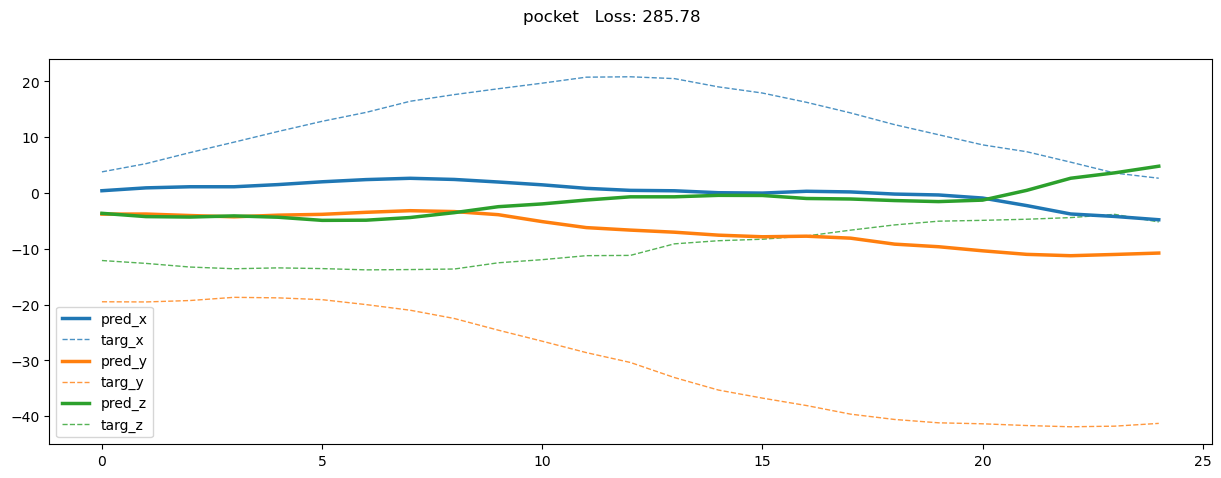

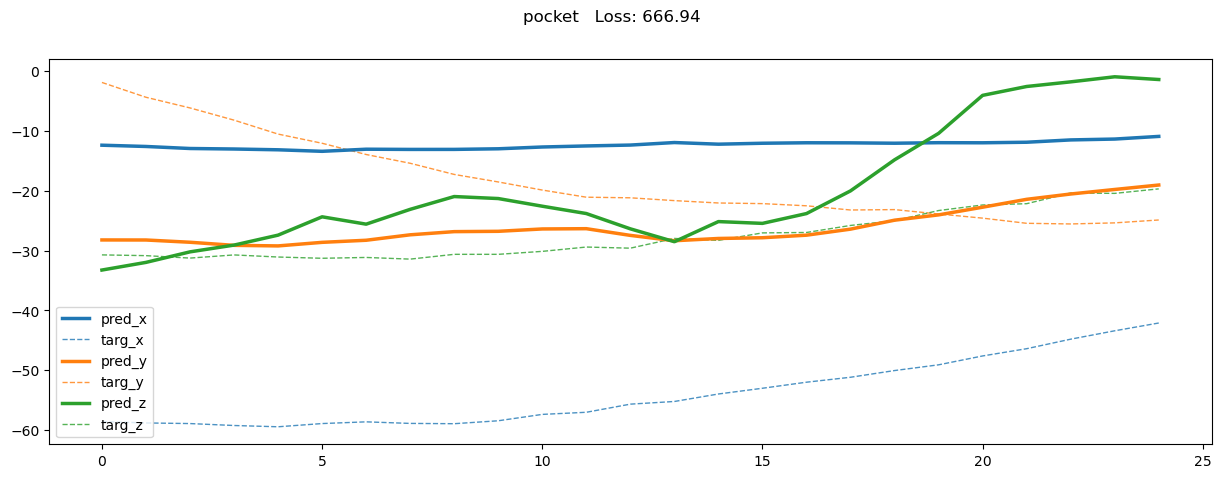

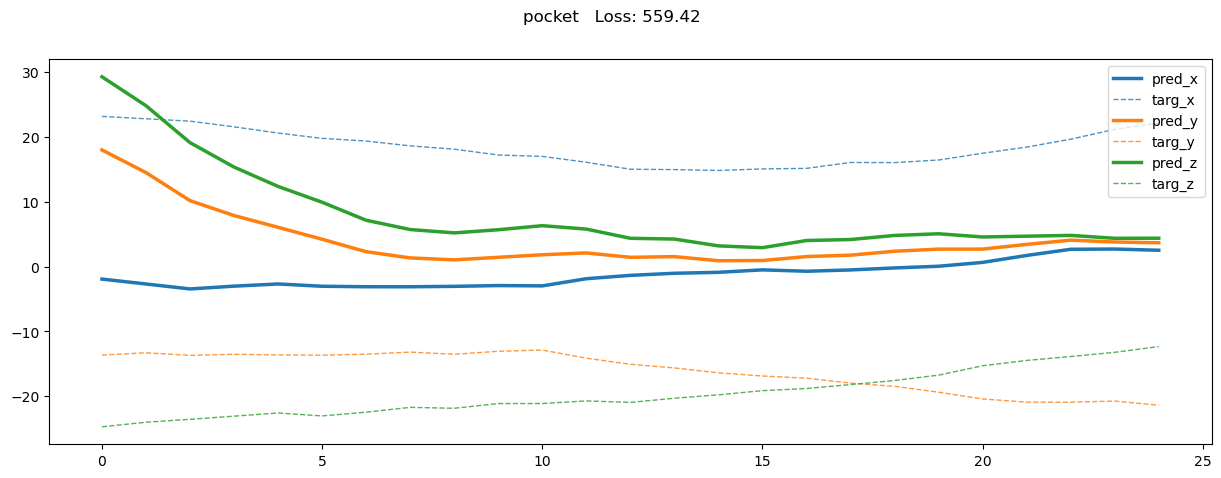

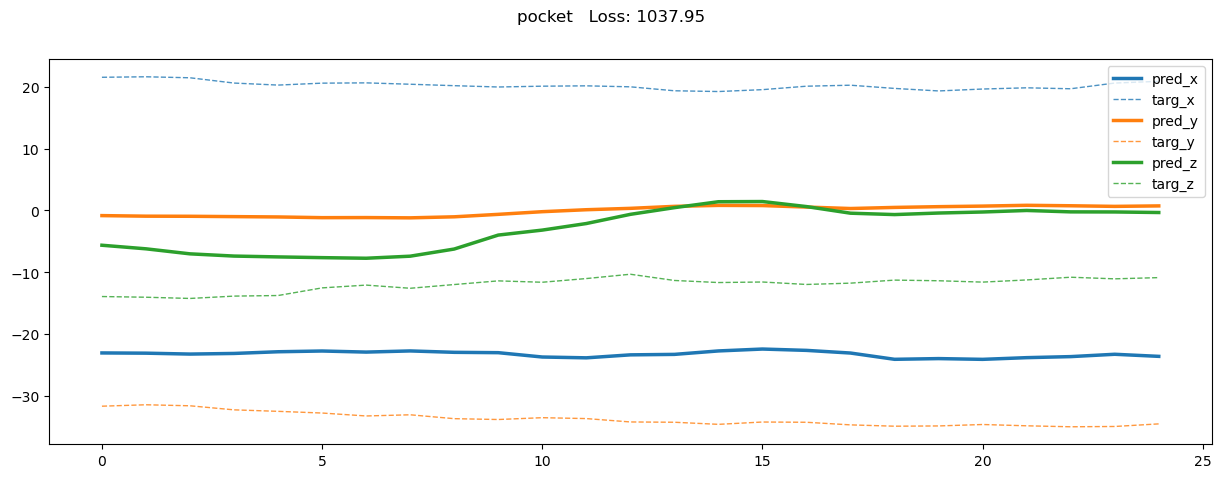

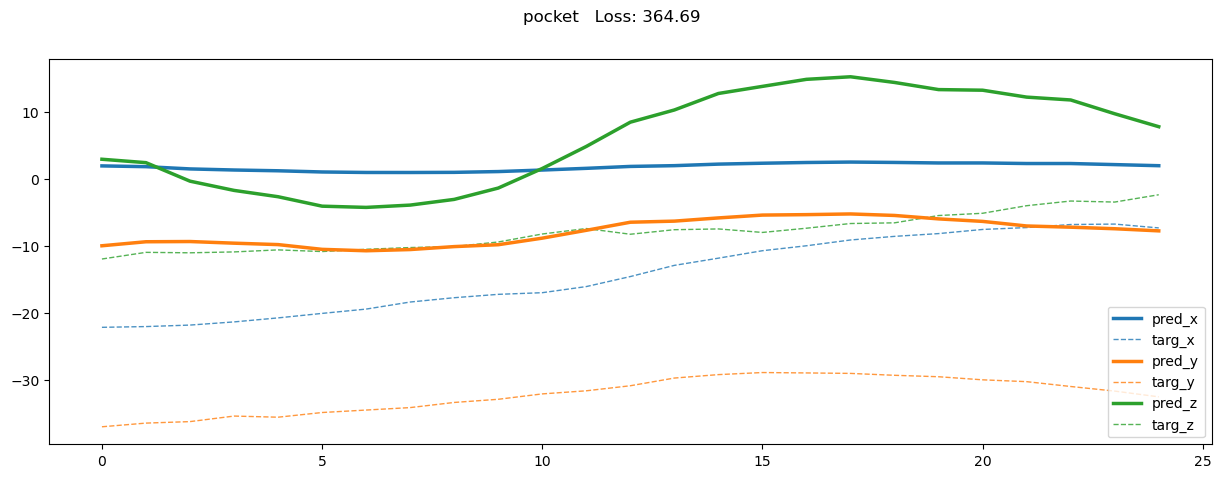

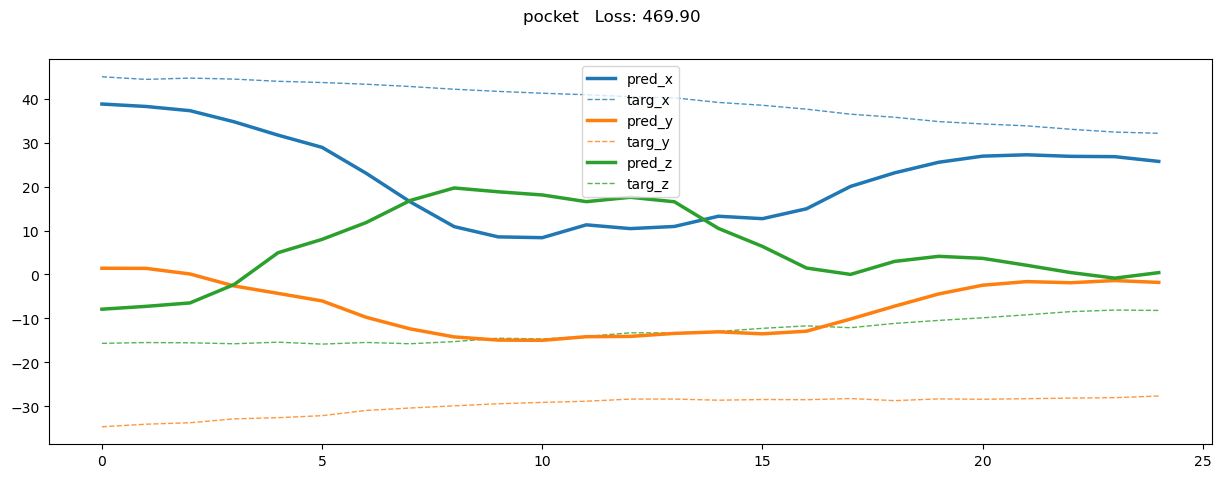

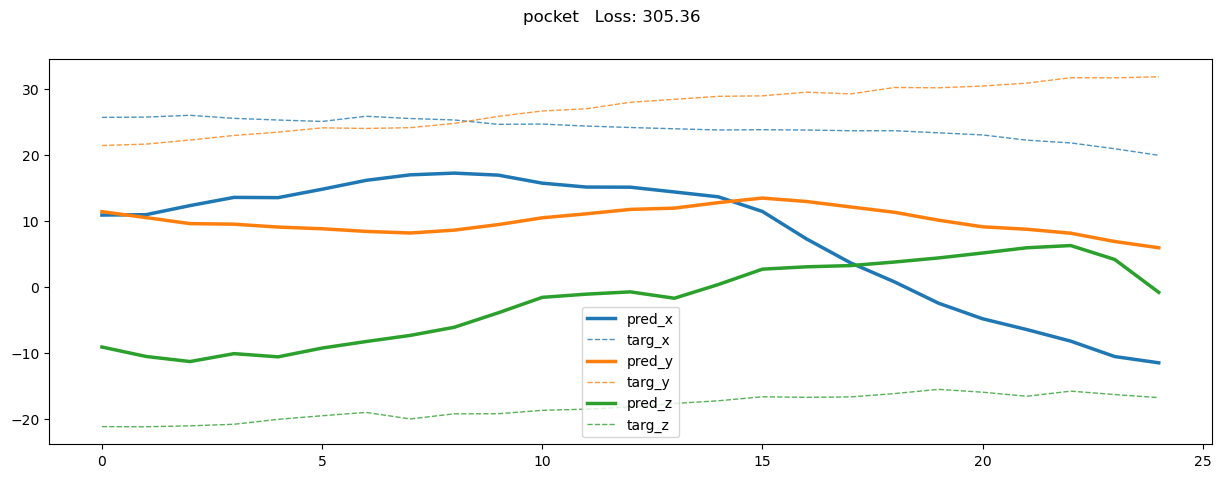

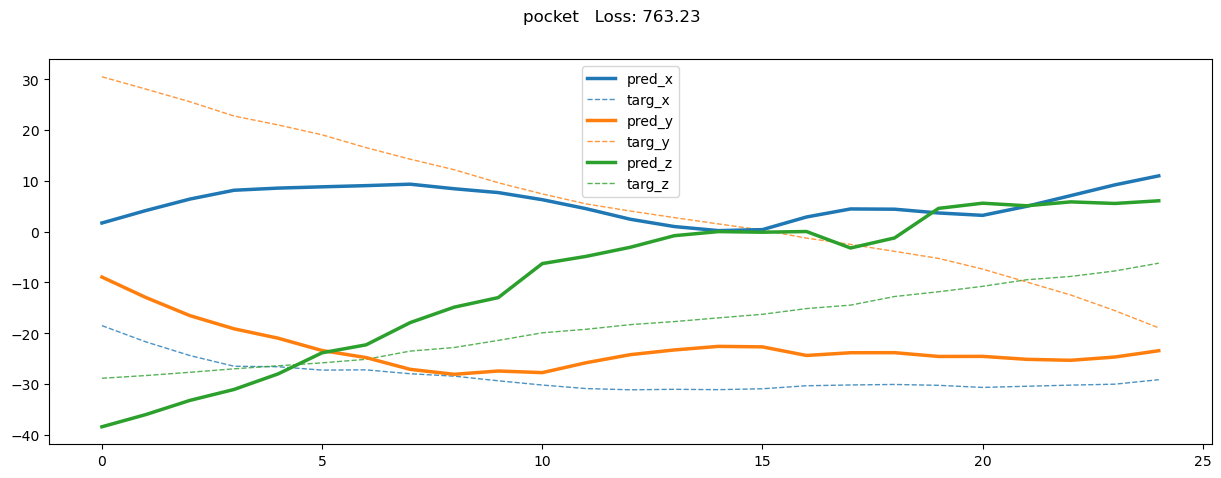

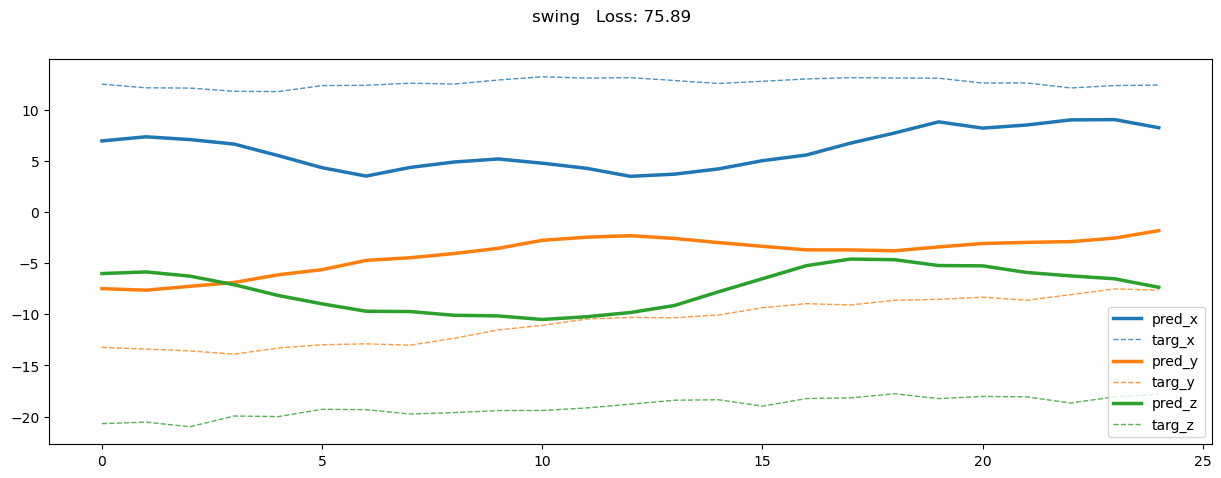

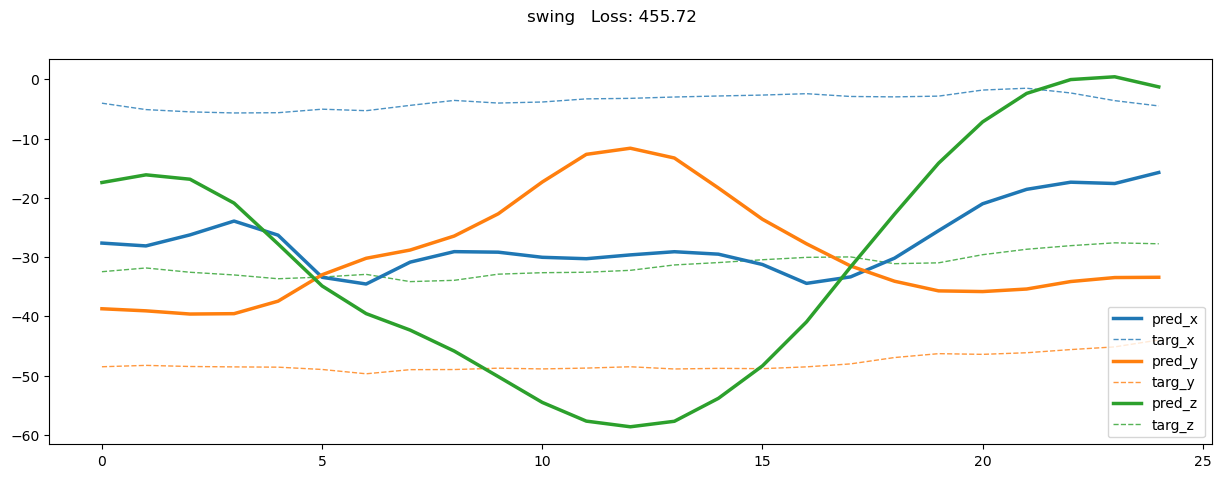

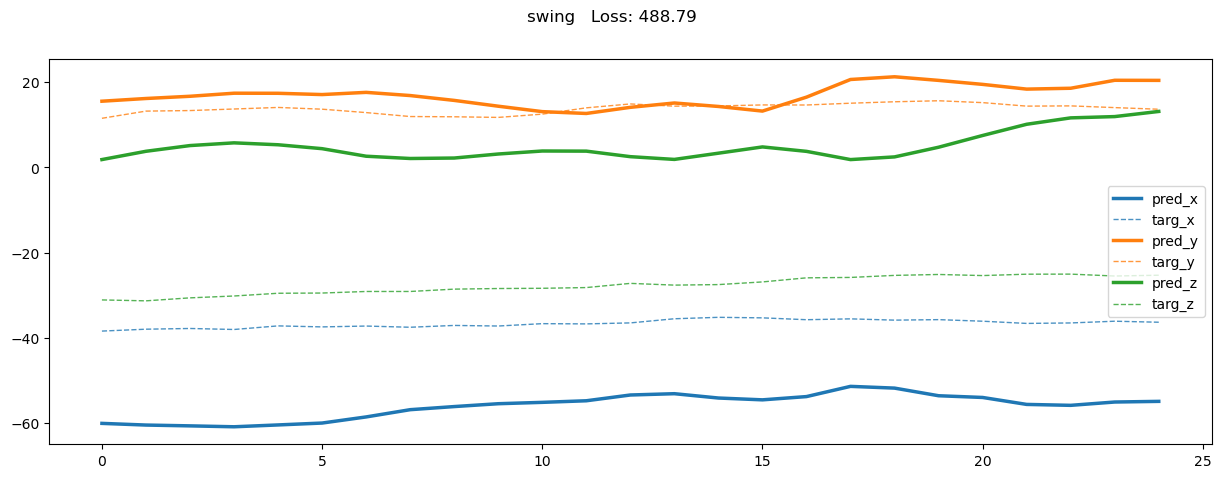

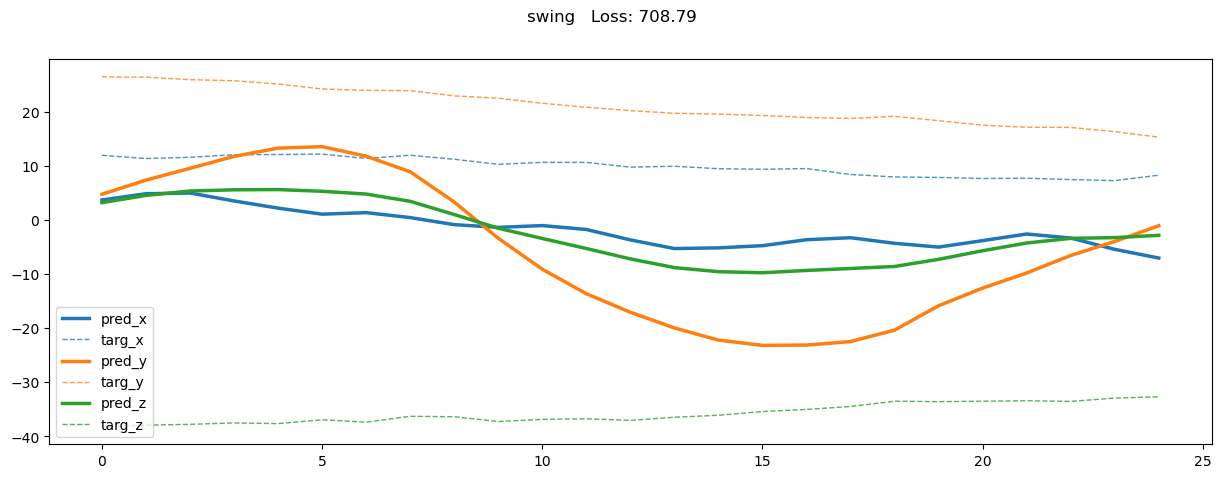

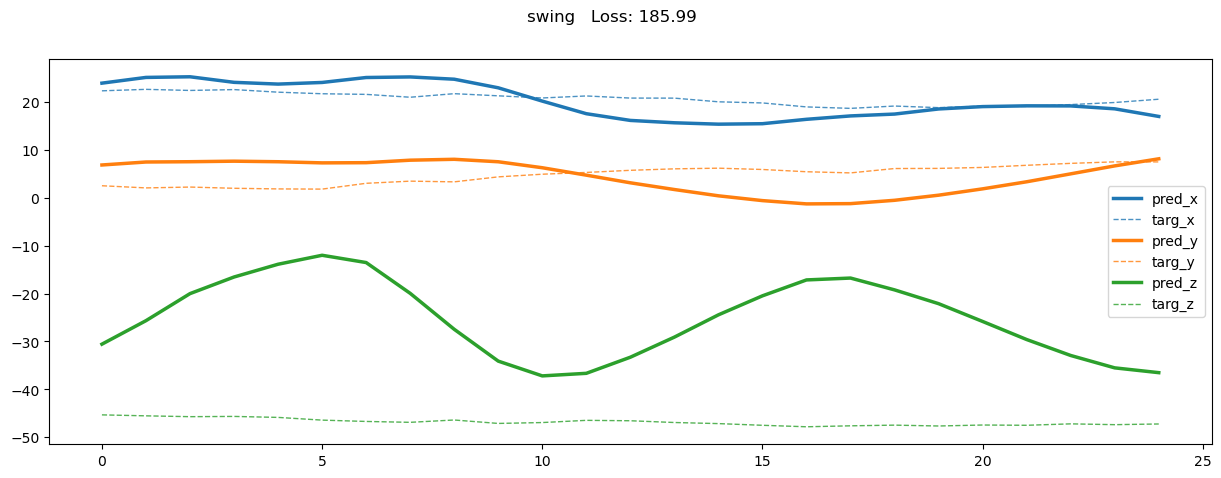

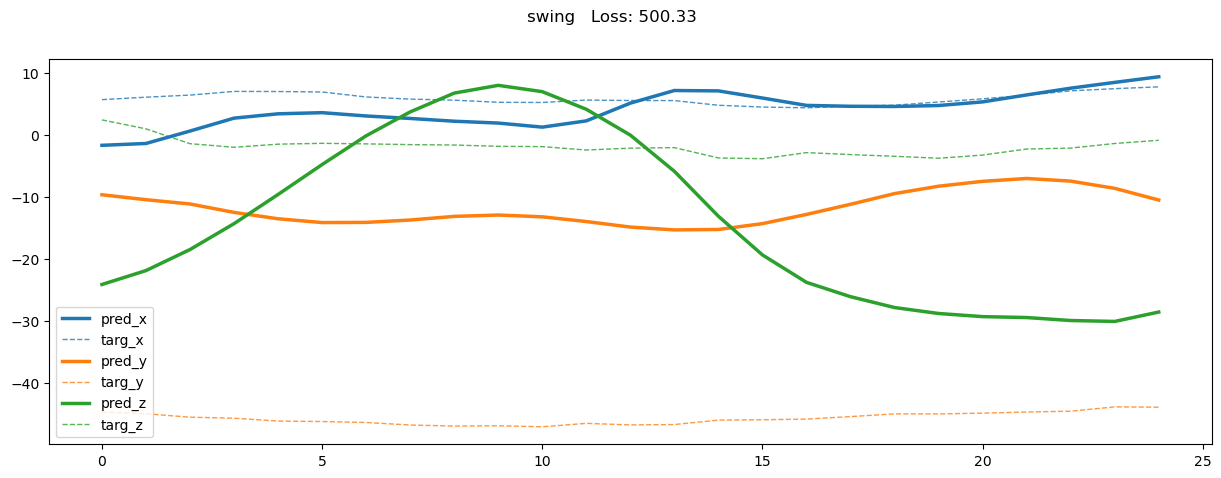

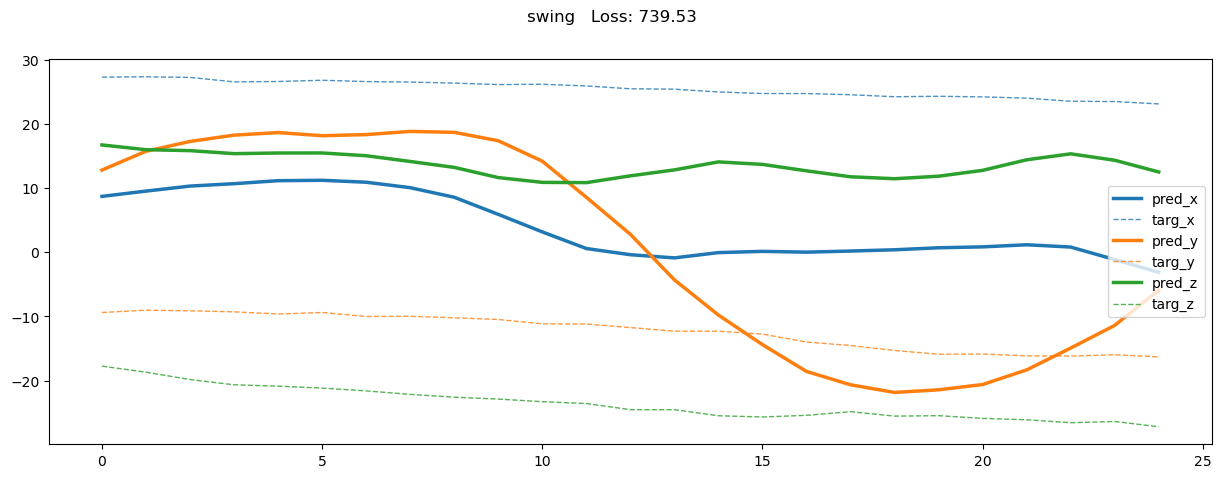

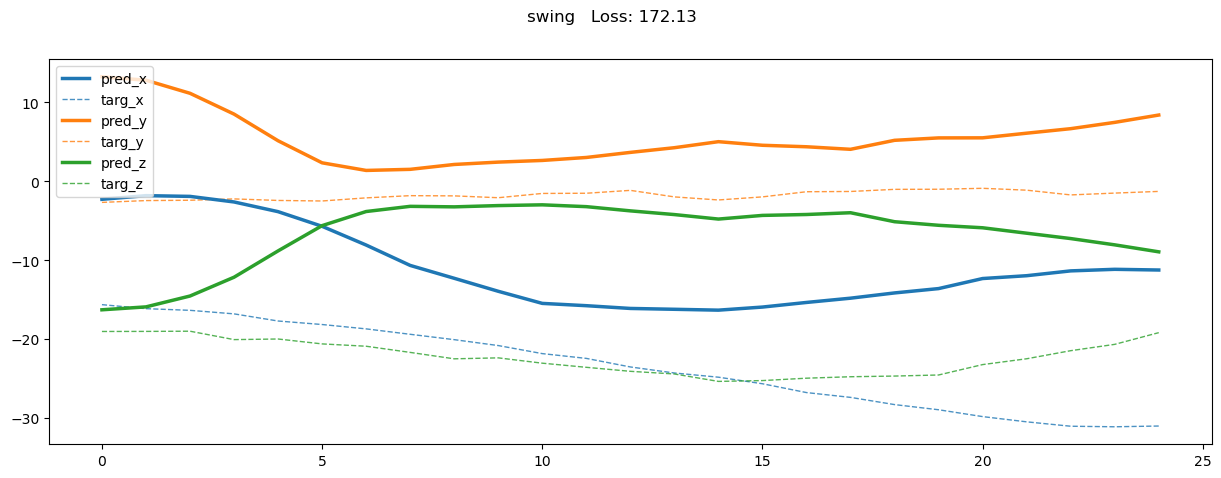

In [55]:
results, cres, clabel = output_eval(model, valid_loader)
print(cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::50]:
    plot_result(rs)